# FR - Mini Lab 2

The question we are looking to answer today is whether house prices are affected by their proximity to educational institutions.

Building on data from the previous lab, we will need to perform additional data munging in order to enrich the current dataset of historical resale house pricing transaction data 

In [161]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from googlemaps import Client as GoogleMaps
import folium
import math

## Enrich current HDB Data Set with Lat/Long data for each house

In [162]:
#import cleaned HDB Resale Transaction Data (2015-2020 )

hdb = pd.read_csv('hdb 2015-2020 cleaned.csv', index_col = 'idx')
hdb

FileNotFoundError: [Errno 2] File hdb 2015-2020 cleaned.csv does not exist: 'hdb 2015-2020 cleaned.csv'

In [166]:
#create full address column to prepare for lookup on Google Maps API

hdb['full address'] = hdb['block'] +str(' ') + hdb['street_name']+' , Singapore' 
hdb.T


idx                                            709054  \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             174   
street_name                          ANG MO KIO AVE 4   
storey_range                                        5   
floor_area_sqm                                     60   
flat_model                                   Improved   
lease_commence_date                              1986   
resale_price                                   255000   
price_per_sqm                                    4250   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    65   
trx_year                                         2015   
full address         174 ANG MO KIO AVE 4 , Singapore   

idx                                             709055  \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              541   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1981   
resale_price                                    275000   
price_per_sqm                                  4044.12   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                                     60   
trx_year                                          2015   
full address         541 ANG MO KIO AVE 10 , Singapore   

idx                                            709056  \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             163   
street_name                          ANG MO KIO AVE 4   
storey_range                                        1   
floor_area_sqm                                     69   
flat_model                             New Generation   
lease_commence_date                              1980   
resale_price                                   285000   
price_per_sqm                                 4130.43   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    59   
trx_year                                         2015   
full address         163 ANG MO KIO AVE 4 , Singapore   

idx                                             709057  \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              446   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1979   
resale_price                                    290000   
price_per_sqm                                  4264.71   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                

In [18]:
gmlookup = pd.DataFrame (hdb['full address'])
gmlookup

full address
idx                          
709054   174 ANG MO KIO AVE 4
709055  541 ANG MO KIO AVE 10
709056   163 ANG MO KIO AVE 4
709057  446 ANG MO KIO AVE 10
709058  557 ANG MO KIO AVE 10
...                       ...
819522     326 YISHUN RING RD
819523       281 YISHUN ST 22
819524       611 YISHUN ST 61
819525       611 YISHUN ST 61
819526       828 YISHUN ST 81

[110473 rows x 1 columns]

In [19]:
#add lat long columns
gmlookup['lat'] = ""
gmlookup['long'] = ""
gmlookup

full address lat long
idx                                   
709054   174 ANG MO KIO AVE 4         
709055  541 ANG MO KIO AVE 10         
709056   163 ANG MO KIO AVE 4         
709057  446 ANG MO KIO AVE 10         
709058  557 ANG MO KIO AVE 10         
...                       ...  ..  ...
819522     326 YISHUN RING RD         
819523       281 YISHUN ST 22         
819524       611 YISHUN ST 61         
819525       611 YISHUN ST 61         
819526       828 YISHUN ST 81         

[110473 rows x 3 columns]

In [21]:
gmlookup = gmlookup.drop_duplicates()
gmlookup

full address lat long
idx                                    
709054    174 ANG MO KIO AVE 4         
709055   541 ANG MO KIO AVE 10         
709056    163 ANG MO KIO AVE 4         
709057   446 ANG MO KIO AVE 10         
709058   557 ANG MO KIO AVE 10         
...                        ...  ..  ...
818774      470A FERNVALE LINK         
818819  469A SENGKANG WEST WAY         
818899      412 SERANGOON CTRL         
818980     858B TAMPINES AVE 5         
819083          128 SIMEI ST 1         

[8897 rows x 3 columns]

In [30]:
gmlookup['full address'] =  gmlookup['full address'].astype(str) + ' , Singapore' 
gmlookup

full address lat long
idx                                                
709054    174 ANG MO KIO AVE 4 , Singapore         
709055   541 ANG MO KIO AVE 10 , Singapore         
709056    163 ANG MO KIO AVE 4 , Singapore         
709057   446 ANG MO KIO AVE 10 , Singapore         
709058   557 ANG MO KIO AVE 10 , Singapore         
...                                    ...  ..  ...
818774      470A FERNVALE LINK , Singapore         
818819  469A SENGKANG WEST WAY , Singapore         
818899      412 SERANGOON CTRL , Singapore         
818980     858B TAMPINES AVE 5 , Singapore         
819083          128 SIMEI ST 1 , Singapore         

[8897 rows x 3 columns]

In [116]:
#Check google maps API for individual lat longs
gmaps = GoogleMaps('yourkeyhere')

i=0
for x in gmlookup['full address']:
        geocode_result = gmaps.geocode(str(x))
        if not geocode_result :
            print("no data found for line "+str(i))
            i+=1
        else:
            gmlookup['lat'].iloc[i] = geocode_result[0]['geometry']['location'] ['lat']
            gmlookup['long'].iloc[i]= geocode_result[0]['geometry']['location']['lng']
            print('line '+ str(i) +" "+str(geocode_result[0]['geometry']['location'] ['lat'])+"," 
              + str(geocode_result[0]['geometry']['location']['lng'])  +' done')
            i += 1



line 0 1.3752431,103.8374311 done
line 1 1.373289,103.8560821 done
line 2 1.3735762,103.837598 done
line 3 1.3678117,103.8551856 done
line 4 1.3716063,103.8577221 done
line 5 1.380163,103.8357101 done
line 6 1.3711528,103.8476668 done
line 7 1.3613131,103.8516526 done
line 8 1.3701494,103.8376575 done
line 9 1.3697651,103.8593528 done
line 10 1.3651811,103.8415977 done
line 11 1.3720459,103.8577221 done
line 12 1.3755222,103.8397861 done
line 13 1.3634808,103.8567256 done
line 14 1.3679694,103.8532832 done
line 15 1.3707919,103.8591716 done
line 16 1.3616045,103.8519244 done
line 17 1.3653349,103.8528303 done
line 18 1.3743701,103.8487538 done
line 19 1.3795472,103.8406919 done
line 20 1.3763871,103.8422318 done
line 21 1.3656873,103.8551856 done
line 22 1.3712314,103.8591716 done
line 23 1.3688441,103.8415977 done
line 24 1.376693,103.8400579 done
line 25 1.3619223,103.8508147 done
line 26 1.3697115,103.8435905 done
line 27 1.3703816,103.8417789 done
line 28 1.3794551,103.8438623 done

line 243 1.2735829,103.8118904 done
line 244 1.281697,103.807681 done
line 245 1.2857166,103.8257516 done
line 246 1.2829258,103.8279207 done
line 247 1.2869521,103.8170676 done
line 248 1.2868666,103.8160563 done
line 249 1.2870113,103.816328 done
line 250 1.2851341,103.8258441 done
line 251 1.2864806,103.8300157 done
line 252 1.2822539,103.8246208 done
line 253 1.2865532,103.8330834 done
line 254 1.2876985,103.8110754 done
line 255 1.2806786,103.8107192 done
line 256 1.2884916,103.8329475 done
line 257 1.2874326,103.8194978 done
line 258 1.2811332,103.8274694 done
line 259 1.2890041,103.8163053 done
line 260 1.2827761,103.8285547 done
line 261 1.2869202,103.8328117 done
line 262 1.3774315,103.7677264 done
line 263 1.3765519,103.7677264 done
line 264 1.3803091,103.7738601 done
line 265 1.3823247,103.7677038 done
line 266 1.3739991,103.7749465 done
line 267 1.3859742,103.7704198 done
line 268 1.3830364,103.7682244 done
line 269 1.3869107,103.7732263 done
line 270 1.3754452,103.7689486 

line 478 1.3697882,103.8794633 done
line 479 1.378808,103.894272 done
line 480 1.3774627,103.8955947 done
line 481 1.3658638,103.8874395 done
line 482 1.370122,103.8937132 done
line 483 1.320352,103.7417238 done
line 484 1.3211588,103.7414522 done
line 485 1.3446131,103.7390105 done
line 486 1.3437201,103.7414541 done
line 487 1.3411873,103.7380354 done
line 488 1.3426102,103.7421764 done
line 489 1.3391271,103.7364741 done
line 490 1.338446,103.742658 done
line 491 1.3361946,103.7381939 done
line 492 1.344785,103.7345756 done
line 493 1.3388218,103.7386464 done
line 494 1.3452967,103.7347567 done
line 495 1.3219768,103.7391894 done
line 496 1.3404134,103.7420858 done
line 497 1.341847,103.7379449 done
line 498 1.348473,103.7301415 done
line 499 1.3406555,103.744575 done
line 500 1.3418796,103.7450502 done
line 501 1.3187027,103.748603 done
line 502 1.3410206,103.7415654 done
line 503 1.341042,103.7474263 done
line 504 1.3421346,103.745529 done
line 505 1.3414644,103.745519 done
line 5

line 716 1.3942935,103.9115443 done
line 717 1.3981809,103.906593 done
line 718 1.3991522,103.9164728 done
line 719 1.399966,103.90568 done
line 720 1.3999057,103.9089013 done
line 721 1.398466,103.908585 done
line 722 1.397783,103.916257 done
line 723 1.3975103,103.9157647 done
line 724 1.399299,103.9075189 done
line 725 1.39697,103.915662 done
line 726 1.3962603,103.9106273 done
line 727 1.3956609,103.9157132 done
line 728 1.3953655,103.9160757 done
line 729 1.403091,103.904967 done
line 730 1.3945818,103.9123599 done
line 731 1.2906724,103.8023356 done
line 732 1.3048,103.8004804 done
line 733 1.3024191,103.7983862 done
line 734 1.296245,103.799522 done
no data found for line 735
line 736 1.296245,103.799522 done
line 737 1.3070288,103.7846116 done
line 738 1.3123313,103.7883466 done
line 739 1.291904,103.8026439 done
line 740 1.3121173,103.7873506 done
line 741 1.3124126,103.7868979 done
line 742 1.306882,103.7945038 done
line 743 1.3090796,103.794051 done
line 744 1.303137,103.782

line 948 1.3459136,103.9559589 done
line 949 1.3570215,103.9341123 done
line 950 1.3586014,103.9579987 done
line 951 1.3514326,103.9477774 done
line 952 1.3540588,103.9581874 done
line 953 1.356367,103.938986 done
line 954 1.3540562,103.9528766 done
line 955 1.3513691,103.936741 done
line 956 1.3463532,103.9558682 done
line 957 1.3447278,103.9584973 done
line 958 1.3506312,103.9377381 done
line 959 1.3569233,103.9383726 done
line 960 1.356362,103.938405 done
line 961 1.3530793,103.9322089 done
line 962 1.3586475,103.9497416 done
line 963 1.3595756,103.9479813 done
line 964 1.3592589,103.9495751 done
line 965 1.3543021,103.9359252 done
line 966 1.3529026,103.9373755 done
line 967 1.3554707,103.9363784 done
line 968 1.3391609,103.8454928 done
line 969 1.330963,103.8581751 done
line 970 1.3305218,103.8588934 done
line 971 1.3334723,103.8790165 done
line 972 1.3412893,103.8445869 done
line 973 1.3377525,103.8524876 done
line 974 1.3414985,103.8463986 done
line 975 1.3353723,103.855095 done

line 1173 1.3639116,103.8519697 done
line 1174 1.3744348,103.8502032 done
line 1175 1.3777697,103.8438623 done
line 1176 1.3691411,103.8533738 done
line 1177 1.3785357,103.8382463 done
line 1178 1.3792723,103.8376122 done
line 1179 1.3723448,103.8567256 done
line 1180 1.3656625,103.8469421 done
line 1181 1.3732261,103.8563633 done
line 1182 1.3699527,103.8461722 done
line 1183 1.3274812,103.9420891 done
line 1184 1.3279202,103.9420891 done
line 1185 1.3326826,103.9282207 done
line 1186 1.3290909,103.9257561 done
line 1187 1.332718,103.9380402 done
line 1188 1.3365333,103.9203354 done
line 1189 1.3359348,103.9226012 done
line 1190 1.3293183,103.9225179 done
line 1191 1.3279447,103.9378287 done
line 1192 1.3302395,103.9268158 done
line 1193 1.3287254,103.9419985 done
line 1194 1.3342292,103.9264986 done
line 1195 1.3298653,103.909188 done
line 1196 1.332461,103.9412733 done
line 1197 1.3340175,103.925139 done
line 1198 1.3237706,103.9249492 done
line 1199 1.3219076,103.9331111 done
line 

line 1397 1.3201778,103.7661195 done
line 1398 1.3170708,103.7654405 done
line 1399 1.3174403,103.7648068 done
line 1400 1.3140671,103.762702 done
line 1401 1.3031124,103.7620004 done
line 1402 1.321114,103.7623626 done
line 1403 1.3135373,103.7690618 done
line 1404 1.3123679,103.7687902 done
line 1405 1.3159413,103.7710535 done
line 1406 1.3194755,103.7673417 done
line 1407 1.3214601,103.7658932 done
line 1408 1.3245029,103.7715062 done
line 1409 1.318802,103.7699671 done
line 1410 1.320819,103.7622449 done
line 1411 1.3141228,103.7690618 done
line 1412 1.320908,103.7631999 done
line 1413 1.3216613,103.8853555 done
line 1414 1.322677,103.8867146 done
line 1415 1.3169724,103.8756402 done
line 1416 1.32189,103.8826353 done
line 1417 1.3238223,103.9044705 done
line 1418 1.3112025,103.8976789 done
line 1419 1.3181788,103.8799942 done
line 1420 1.3168171,103.8800598 done
line 1421 1.319113,103.8829083 done
line 1422 1.3206345,103.9017341 done
line 1423 1.3260055,103.8996273 done
line 1424 

line 1621 1.3658038,103.9595852 done
line 1622 1.363829,103.9592226 done
line 1623 1.3679374,103.9578627 done
line 1624 1.3666781,103.9603105 done
line 1625 1.3717232,103.9615797 done
line 1626 1.364184,103.9641862 done
line 1627 1.3759909,103.93608 done
line 1628 1.3734738,103.9627583 done
line 1629 1.3662104,103.9620104 done
line 1630 1.3637434,103.9613077 done
line 1631 1.370569,103.961374 done
line 1632 1.3732503,103.9633929 done
line 1633 1.3696853,103.950225 done
line 1634 1.374292,103.957766 done
line 1635 1.3934819,103.9124505 done
line 1636 1.397707,103.908513 done
line 1637 1.3980701,103.9080165 done
line 1638 1.393284,103.911078 done
line 1639 1.395244,103.906758 done
line 1640 1.3992421,103.9152172 done
line 1641 1.3956723,103.91381 done
line 1642 1.3942784,103.9149583 done
line 1643 1.3929717,103.9119974 done
line 1644 1.393712,103.911087 done
line 1645 1.3933572,103.9097454 done
line 1646 1.3972751,103.90986 done
line 1647 1.3997971,103.9099423 done
line 1648 1.3983645,10

line 1846 1.3555647,103.957772 done
line 1847 1.3463433,103.9512902 done
line 1848 1.354309,103.93664 done
line 1849 1.3529734,103.9627583 done
line 1850 1.3429686,103.9495451 done
line 1851 1.3517641,103.9567748 done
line 1852 1.3591367,103.935472 done
line 1853 1.3564233,103.9487065 done
line 1854 1.3437233,103.9519021 done
line 1855 1.3563154,103.9386044 done
line 1856 1.3479728,103.9417265 done
line 1857 1.3641439,103.9524007 done
line 1858 1.3411909,103.9505387 done
line 1859 1.3427598,103.9571374 done
line 1860 1.3561139,103.9515168 done
line 1861 1.3514083,103.9425423 done
line 1862 1.3308918,103.8450399 done
line 1863 1.3305263,103.8449493 done
line 1864 1.3306876,103.8418707 done
line 1865 1.3377393,103.8508373 done
line 1866 1.3391094,103.8558209 done
line 1867 1.3347919,103.8541891 done
line 1868 1.3328732,103.8569068 done
line 1869 1.3363212,103.8628473 done
line 1870 1.3383213,103.8458101 done
line 1871 1.339583,103.8484821 done
line 1872 1.3356868,103.8458059 done
line 18

line 2070 1.331648,103.915742 done
line 2071 1.3357141,103.9132888 done
line 2072 1.3284868,103.9198822 done
line 2073 1.3321736,103.9403668 done
line 2074 1.3362352,103.9339311 done
line 2075 1.3294215,103.935472 done
line 2076 1.3245266,103.9215136 done
line 2077 1.3246615,103.9107286 done
line 2078 1.3192785,103.9451712 done
line 2079 1.3256163,103.9100942 done
line 2080 1.3552091,103.8363302 done
line 2081 1.346648,103.849912 done
line 2082 1.3502539,103.8517432 done
line 2083 1.3509243,103.8382498 done
line 2084 1.345939,103.8508373 done
line 2085 1.3610015,103.8446233 done
line 2086 1.3465292,103.8504832 done
line 2087 1.3582718,103.8456739 done
line 2088 1.3442455,103.8524679 done
line 2089 1.3461695,103.8521282 done
line 2090 1.3468208,103.850664 done
line 2091 1.3573779,103.8435163 done
line 2092 1.3580546,103.8483688 done
line 2093 1.3493674,103.8524758 done
line 2094 1.3641186,103.7476073 done
line 2095 1.3515578,103.7539472 done
line 2096 1.3644956,103.745797 done
line 2097

line 2294 1.3535533,103.888708 done
line 2295 1.3548591,103.8907921 done
line 2296 1.3567566,103.8918795 done
line 2297 1.3734161,103.8825132 done
line 2298 1.3544325,103.8886174 done
line 2299 1.353003,103.8826371 done
line 2300 1.3708499,103.887304 done
line 2301 1.3601941,103.8926044 done
line 2302 1.3701923,103.8862615 done
line 2303 1.3724597,103.8992195 done
line 2304 1.3659296,103.888708 done
line 2305 1.3743338,103.8796471 done
line 2306 1.3739675,103.8796471 done
line 2307 1.3775618,103.8912452 done
line 2308 1.3552948,103.8914264 done
line 2309 1.3698518,103.8819123 done
line 2310 1.3767413,103.882368 done
line 2311 1.3791327,103.895188 done
line 2312 1.3737244,103.8959572 done
line 2313 1.3778812,103.8868052 done
line 2314 1.3662771,103.888776 done
line 2315 1.379503,103.893866 done
line 2316 1.3517961,103.888708 done
line 2317 1.3754906,103.894598 done
line 2318 1.3786196,103.8963258 done
line 2319 1.380449,103.8796898 done
line 2320 1.3730745,103.8820029 done
line 2321 1.3

line 2518 1.3079724,103.7957715 done
line 2519 1.2921875,103.8027214 done
line 2520 1.3070686,103.7971071 done
line 2521 1.3058533,103.7821896 done
line 2522 1.3074368,103.7836157 done
line 2523 1.3093758,103.7934172 done
line 2524 1.2958479,103.8043626 done
line 2525 1.2951912,103.8051391 done
line 2526 1.3076785,103.782914 done
line 2527 1.2947137,103.8087887 done
line 2528 1.4527712,103.8207389 done
line 2529 1.4499623,103.8164186 done
line 2530 1.4561222,103.8175959 done
line 2531 1.4564961,103.8165091 done
line 2532 1.4463021,103.8177091 done
line 2533 1.4456703,103.818977 done
line 2534 1.4460028,103.8186148 done
line 2535 1.4492497,103.8158978 done
line 2536 1.4457787,103.8203006 done
line 2537 1.4551514,103.8171838 done
line 2538 1.4497532,103.8175733 done
line 2539 1.449724,103.8193166 done
line 2540 1.4499075,103.81343 done
line 2541 1.4499768,103.8170299 done
line 2542 1.4448619,103.8191129 done
line 2543 1.45232,103.8180261 done
line 2544 1.4515191,103.8169393 done
line 254

line 2742 1.4367129,103.7985786 done
line 2743 1.4379792,103.7812586 done
line 2744 1.4467543,103.8010235 done
line 2745 1.4375948,103.7983975 done
line 2746 1.4448954,103.7988955 done
line 2747 1.4453219,103.7952282 done
line 2748 1.4372051,103.7901575 done
line 2749 1.4365587,103.7938247 done
line 2750 1.4415663,103.7971298 done
line 2751 1.4355798,103.7918779 done
line 2752 1.4453348,103.7990766 done
line 2753 1.4323082,103.7868073 done
line 2754 1.4339973,103.7866262 done
line 2755 1.4448456,103.8010235 done
line 2756 1.4315971,103.7950471 done
line 2757 1.4441357,103.8079611 done
line 2758 1.4442487,103.7907008 done
line 2759 1.4460555,103.7953187 done
line 2760 1.4278898,103.7952735 done
line 2761 1.4349362,103.7950924 done
line 2762 1.4343815,103.7957715 done
line 2763 1.4297691,103.7939605 done
line 2764 1.4347162,103.8010235 done
line 2765 1.4410489,103.7858113 done
line 2766 1.4284571,103.7925117 done
line 2767 1.4339273,103.7980353 done
line 2768 1.4389732,103.8010235 done
l

line 2966 1.2883406,103.8271961 done
line 2967 1.2739914,103.8209274 done
line 2968 1.2780633,103.8213997 done
line 2969 1.2724325,103.8209836 done
line 2970 1.2732267,103.8246613 done
line 2971 1.2746874,103.8404881 done
line 2972 1.2748311,103.8108943 done
line 2973 1.283066,103.826076 done
line 2974 1.2849226,103.8310578 done
line 2975 1.2847416,103.8310535 done
line 2976 1.2735811,103.8224539 done
line 2977 1.2904366,103.8217393 done
line 2978 1.2873284,103.810896 done
line 2979 1.2735257,103.8100806 done
line 2980 1.2773322,103.8213997 done
line 2981 1.2774773,103.808268 done
line 2982 1.2767298,103.8084605 done
line 2983 1.2778231,103.8218752 done
line 2984 1.2897957,103.8153318 done
line 2985 1.2803779,103.8288552 done
line 2986 1.2738709,103.8394238 done
line 2987 1.2880406,103.8153318 done
line 2988 1.2869491,103.8192741 done
line 2989 1.2837249,103.8154498 done
line 2990 1.288588,103.8089019 done
line 2991 1.2921357,103.8285547 done
line 2992 1.2893195,103.8288194 done
line 2

line 3190 1.340364,103.7379223 done
line 3191 1.3407292,103.7381033 done
line 3192 1.3412649,103.7468832 done
line 3193 1.3188461,103.7491461 done
line 3194 1.3211268,103.7394103 done
line 3195 1.3503014,103.7306848 done
line 3196 1.3488455,103.7290555 done
line 3197 1.343968,103.7109545 done
line 3198 1.3490888,103.7122226 done
line 3199 1.3481291,103.7262498 done
line 3200 1.3426921,103.689417 done
line 3201 1.3339298,103.7233499 done
line 3202 1.3507967,103.7210011 done
line 3203 1.3492,103.7183764 done
line 3204 1.3492177,103.7152995 done
line 3205 1.3509625,103.7176526 done
line 3206 1.3528118,103.7261563 done
line 3207 1.3446572,103.6897132 done
line 3208 1.3508208,103.7040787 done
line 3209 1.3443335,103.6982863 done
line 3210 1.3474966,103.6928354 done
line 3211 1.3431147,103.6955923 done
line 3212 1.3458767,103.6974723 done
line 3213 1.3434041,103.6930362 done
line 3214 1.3511113,103.7045311 done
line 3215 1.3523811,103.7246177 done
line 3216 1.3444104,103.6976529 done
line 32

line 3414 1.3883984,103.9042309 done
line 3415 1.3685077,103.87267 done
line 3416 1.3538272,103.8668722 done
line 3417 1.3534605,103.8669628 done
line 3418 1.3585568,103.8714062 done
line 3419 1.3524705,103.8732135 done
line 3420 1.3660252,103.8716774 done
line 3421 1.3742952,103.8726702 done
line 3422 1.3563478,103.8732104 done
line 3423 1.3519807,103.8695902 done
line 3424 1.3551271,103.8691367 done
line 3425 1.3479338,103.8765669 done
line 3426 1.3550337,103.8725778 done
line 3427 1.3466157,103.873033 done
line 3428 1.3491725,103.8740296 done
line 3429 1.3746619,103.8725794 done
line 3430 1.3669083,103.8711344 done
line 3431 1.368783,103.8754811 done
line 3432 1.3469122,103.8723988 done
line 3433 1.368282,103.875571 done
line 3434 1.3525888,103.8659566 done
line 3435 1.3582022,103.9449899 done
line 3436 1.3581696,103.9505196 done
line 3437 1.3596093,103.9546897 done
line 3438 1.3524714,103.9360159 done
line 3439 1.3579473,103.9509729 done
line 3440 1.3540502,103.9546342 done
line 34

line 3638 1.428921,103.8484821 done
line 3639 1.4176952,103.836797 done
line 3640 1.433214,103.831219 done
line 3641 1.4148379,103.8362536 done
line 3642 1.4188635,103.8327295 done
line 3643 1.421744,103.8373836 done
line 3644 1.4361479,103.8346548 done
line 3645 1.4318616,103.8363313 done
line 3646 1.4225886,103.8338752 done
line 3647 1.431806,103.837363 done
line 3648 1.4117023,103.8332645 done
line 3649 1.4167918,103.8345779 done
line 3650 1.4291651,103.8445869 done
line 3651 1.426573,103.829741 done
line 3652 1.4277638,103.8457645 done
line 3653 1.4150778,103.8329928 done
line 3654 1.4218846,103.8382126 done
line 3655 1.3768568,103.8371593 done
line 3656 1.3799029,103.8425036 done
line 3657 1.3662627,103.8569974 done
line 3658 1.3734782,103.8530779 done
line 3659 1.3746947,103.8558197 done
line 3660 1.3617045,103.8536003 done
line 3661 1.3759507,103.8531971 done
line 3662 1.3714234,103.8558242 done
line 3663 1.3709152,103.8382463 done
line 3664 1.3654677,103.8426847 done
line 3665 

line 3862 1.373934,103.8945753 done
line 3863 1.365683,103.8948305 done
line 3864 1.3720476,103.8983059 done
line 3865 1.3692612,103.8818192 done
line 3866 1.3789361,103.8827304 done
line 3867 1.3493178,103.8868052 done
line 3868 1.3667326,103.8891611 done
line 3869 1.379654,103.889735 done
line 3870 1.3778321,103.8920106 done
line 3871 1.3786803,103.8934239 done
line 3872 1.3768717,103.8840869 done
line 3873 1.3771868,103.8903456 done
line 3874 1.3741064,103.8963876 done
line 3875 1.377029,103.8961012 done
line 3876 1.3795519,103.891404 done
line 3877 1.3502585,103.888708 done
line 3878 1.3785289,103.891831 done
line 3879 1.3714884,103.8900672 done
line 3880 1.3690042,103.88349 done
line 3881 1.3765273,103.8798257 done
line 3882 1.3728597,103.8812722 done
line 3883 1.3703453,103.8851742 done
line 3884 1.3743287,103.880457 done
line 3885 1.366379,103.898155 done
line 3886 1.3733065,103.8953909 done
line 3887 1.3692422,103.8952096 done
line 3888 1.3727063,103.8946886 done
line 3889 1.37

line 4087 1.3889896,103.8752331 done
line 4088 1.392383,103.897668 done
line 4089 1.3935475,103.8952717 done
line 4090 1.396363,103.898608 done
line 4091 1.395093,103.9004881 done
line 4092 1.3858607,103.8972032 done
line 4093 1.3679231,103.8723981 done
line 4094 1.3713674,103.8722169 done
line 4095 1.3745773,103.8744855 done
line 4096 1.3579657,103.8721298 done
line 4097 1.3537012,103.8656527 done
line 4098 1.3529041,103.8736675 done
line 4099 1.3529374,103.8687748 done
line 4100 1.3463945,103.8733048 done
line 4101 1.3678333,103.8751195 done
line 4102 1.3726962,103.8710439 done
line 4103 1.3488077,103.8740246 done
line 4104 1.3717449,103.8727538 done
line 4105 1.351129,103.867686 done
line 4106 1.3487434,103.9351094 done
line 4107 1.3547898,103.9526046 done
line 4108 1.3494891,103.9327527 done
line 4109 1.3460914,103.93801 done
line 4110 1.3520624,103.9308493 done
line 4111 1.3465551,103.9463496 done
line 4112 1.3504572,103.9549617 done
line 4113 1.3590631,103.9510862 done
line 4114 

line 4312 1.3200234,103.9429035 done
line 4313 1.3297831,103.9361971 done
line 4314 1.3349542,103.9149881 done
line 4315 1.3214265,103.9396401 done
line 4316 1.3373472,103.9187946 done
line 4317 1.336814,103.92242 done
line 4318 1.331668,103.91381 done
line 4319 1.3210603,103.9397313 done
line 4320 1.3313891,103.9368316 done
line 4321 1.3193589,103.9435005 done
line 4322 1.3275586,103.9345016 done
line 4323 1.3353932,103.9118388 done
line 4324 1.326364,103.9200635 done
line 4325 1.3329865,103.9326168 done
line 4326 1.3208647,103.9355622 done
line 4327 1.3280646,103.9225418 done
line 4328 1.336151,103.9358346 done
line 4329 1.3314701,103.935472 done
line 4330 1.332131,103.905875 done
line 4331 1.3326533,103.9079192 done
line 4332 1.3375619,103.9254634 done
line 4333 1.3313262,103.9064035 done
line 4334 1.3298615,103.9352907 done
line 4335 1.3241496,103.9111766 done
line 4336 1.3300765,103.9297163 done
line 4337 1.3200054,103.9332045 done
line 4338 1.3249182,103.9425423 done
line 4339 1.

line 4536 1.3499919,103.6953015 done
line 4537 1.3404958,103.6891455 done
line 4538 1.3439232,103.6963634 done
line 4539 1.3499814,103.72263 done
line 4540 1.3473801,103.7257366 done
line 4541 1.3422499,103.6898694 done
line 4542 1.3527395,103.7164502 done
line 4543 1.3436305,103.6961359 done
line 4544 1.3523521,103.7169253 done
line 4545 1.3519304,103.725707 done
line 4546 1.3369603,103.7226949 done
line 4547 1.3393051,103.6956375 done
line 4548 1.3462706,103.708625 done
line 4549 1.3422214,103.7076949 done
line 4550 1.3520927,103.7229014 done
line 4551 1.3411687,103.7028311 done
line 4552 1.3366579,103.6953889 done
line 4553 1.342673,103.70498 done
line 4554 1.34633,103.7206383 done
line 4555 1.3505958,103.7049836 done
line 4556 1.3466882,103.6964772 done
line 4557 1.3499597,103.7009115 done
line 4558 1.3440873,103.7029009 done
line 4559 1.3365102,103.7020395 done
line 4560 1.3338062,103.7224675 done
line 4561 1.336203,103.695777 done
line 4562 1.3438553,103.7146421 done
line 4563 1.

line 4760 1.3358021,103.8567256 done
line 4761 1.3322871,103.8454896 done
line 4762 1.3350292,103.8517446 done
line 4763 1.3350245,103.8678461 done
line 4764 1.3344885,103.8687748 done
line 4765 1.3356536,103.843904 done
line 4766 1.3358198,103.8791035 done
line 4767 1.3362748,103.8514672 done
line 4768 1.4411312,103.7784392 done
line 4769 1.4406299,103.7757377 done
line 4770 1.4360928,103.7740864 done
line 4771 1.4353947,103.7742222 done
line 4772 1.4333428,103.773679 done
line 4773 1.4339862,103.7764856 done
line 4774 1.4435408,103.7734972 done
line 4775 1.4438674,103.7922546 done
line 4776 1.4425639,103.7722757 done
line 4777 1.4464231,103.7952282 done
line 4778 1.4319685,103.7943227 done
line 4779 1.4439831,103.7980353 done
line 4780 1.4425116,103.7985786 done
line 4781 1.4291098,103.7937794 done
line 4782 1.4387069,103.7965865 done
line 4783 1.4371343,103.8016574 done
line 4784 1.4361204,103.793825 done
line 4785 1.4457024,103.793055 done
line 4786 1.429359,103.772663 done
line 47

line 4985 1.3129909,103.7685643 done
line 4986 1.3134143,103.7648974 done
line 4987 1.316748,103.7707819 done
line 4988 1.3184252,103.7653953 done
line 4989 1.3115735,103.766889 done
line 4990 1.3161701,103.7694239 done
line 4991 1.326992,103.887077 done
line 4992 1.3255373,103.8855366 done
line 4993 1.3233405,103.8857164 done
line 4994 1.3214068,103.8844057 done
line 4995 1.3098859,103.8851727 done
line 4996 1.3265763,103.9021646 done
line 4997 1.3258806,103.8991448 done
line 4998 1.3174298,103.8763029 done
line 4999 1.3171801,103.9013037 done
line 5000 1.3302133,103.8868052 done
line 5001 1.3094763,103.8826158 done
line 5002 1.3173888,103.8976548 done
line 5003 1.3176769,103.8984588 done
line 5004 1.3226178,103.8842681 done
line 5005 1.3238987,103.903388 done
line 5006 1.3533485,103.8861709 done
line 5007 1.3524122,103.8864497 done
line 5008 1.351509,103.8877113 done
line 5009 1.3711398,103.887077 done
line 5010 1.371304,103.8840869 done
line 5011 1.3663744,103.8878019 done
line 5012

line 5209 1.3424025,103.8451531 done
line 5210 1.3316917,103.842588 done
line 5211 1.3363688,103.8474016 done
line 5212 1.3343451,103.8692235 done
line 5213 1.3332643,103.8661493 done
line 5214 1.3365471,103.8802883 done
line 5215 1.3373096,103.862802 done
line 5216 1.3317893,103.8672346 done
line 5217 1.3320999,103.8581702 done
line 5218 1.3357049,103.8658404 done
line 5219 1.337092,103.859005 done
line 5220 1.3345944,103.8557908 done
line 5221 1.3356652,103.8487085 done
line 5222 1.4419798,103.7782831 done
line 5223 1.4358059,103.773 done
line 5224 1.4394594,103.7750008 done
line 5225 1.4357992,103.7740864 done
line 5226 1.4400784,103.7934739 done
line 5227 1.4434725,103.7926349 done
line 5228 1.430215,103.793055 done
line 5229 1.4359388,103.7961563 done
line 5230 1.4411976,103.7974014 done
line 5231 1.4300719,103.7804694 done
line 5232 1.4439226,103.7959526 done
line 5233 1.4429438,103.7957076 done
line 5234 1.4402336,103.8033568 done
line 5235 1.4361964,103.7990313 done
line 5236 1

line 5433 1.3693517,103.8983586 done
line 5434 1.3775852,103.8934653 done
line 5435 1.3792078,103.892022 done
line 5436 1.3763384,103.8875301 done
line 5437 1.3723054,103.8881644 done
line 5438 1.3789251,103.8868278 done
line 5439 1.3694025,103.8959572 done
line 5440 1.3626974,103.8903391 done
line 5441 1.3737543,103.8970899 done
line 5442 1.3719093,103.880825 done
line 5443 1.320568,103.7423574 done
line 5444 1.3201163,103.7400046 done
line 5445 1.3441689,103.739825 done
line 5446 1.3391962,103.7468153 done
line 5447 1.3411155,103.7441903 done
line 5448 1.3203086,103.7494177 done
line 5449 1.3383251,103.7358405 done
line 5450 1.3521946,103.7175617 done
line 5451 1.3500085,103.717924 done
line 5452 1.3500231,103.7153901 done
line 5453 1.3457972,103.6985581 done
line 5454 1.3487277,103.7263394 done
line 5455 1.3503318,103.6999162 done
line 5456 1.3355715,103.7212952 done
line 5457 1.3385779,103.7216326 done
line 5458 1.340938,103.7015416 done
line 5459 1.3495424,103.7225394 done
line 54

line 5657 1.3318081,103.9148975 done
line 5658 1.3333543,103.9259548 done
line 5659 1.3200746,103.9466203 done
line 5660 1.3190559,103.9456246 done
line 5661 1.3328801,103.9066505 done
line 5662 1.3230884,103.9112671 done
line 5663 1.3234906,103.9112673 done
line 5664 1.3311356,103.9300335 done
line 5665 1.3325399,103.9402762 done
line 5666 1.326608,103.9412733 done
line 5667 1.3203432,103.9436754 done
line 5668 1.3213731,103.9361959 done
line 5669 1.3311947,103.9038638 done
line 5670 1.3318818,103.9052684 done
line 5671 1.3437958,103.8542797 done
line 5672 1.35872,103.8316342 done
line 5673 1.3558179,103.8488671 done
line 5674 1.3483366,103.8509053 done
line 5675 1.3585004,103.8472818 done
line 5676 1.348388,103.849097 done
line 5677 1.3513108,103.758926 done
line 5678 1.3477971,103.7578754 done
line 5679 1.3574483,103.7479694 done
line 5680 1.3454729,103.7487412 done
line 5681 1.3485949,103.7471578 done
line 5682 1.3622966,103.7521786 done
line 5683 1.3451175,103.7596038 done
line 56

line 5881 1.3553922,103.9622144 done
line 5882 1.3531584,103.9312118 done
line 5883 1.3516225,103.9559589 done
line 5884 1.3453764,103.9602198 done
line 5885 1.3630493,103.954871 done
line 5886 1.3491524,103.9402762 done
line 5887 1.3575283,103.9475281 done
line 5888 1.343658,103.9512787 done
line 5889 1.3559199,103.9471655 done
line 5890 1.3629841,103.9535112 done
line 5891 1.3588226,103.9504721 done
line 5892 1.3546649,103.9364691 done
line 5893 1.345796,103.950313 done
line 5894 1.344584,103.9558937 done
line 5895 1.3455685,103.9398229 done
line 5896 1.3564571,103.95852 done
line 5897 1.357587,103.9375568 done
line 5898 1.362376,103.958136 done
line 5899 1.3571596,103.9479813 done
line 5900 1.3592294,103.9568406 done
line 5901 1.359296,103.9332966 done
line 5902 1.3527868,103.9571374 done
line 5903 1.3637249,103.9520607 done
line 5904 1.3516141,103.9448992 done
line 5905 1.3339136,103.8798375 done
line 5906 1.3412736,103.8473045 done
line 5907 1.336738,103.8504932 done
line 5908 1.3

line 6105 1.3685883,103.884993 done
line 6106 1.3415064,103.7430815 done
line 6107 1.318564,103.7472453 done
line 6108 1.3416891,103.7367456 done
line 6109 1.3372922,103.7383752 done
line 6110 1.3198704,103.7492367 done
line 6111 1.346997,103.7320419 done
line 6112 1.3409328,103.7409092 done
line 6113 1.3390811,103.7445298 done
line 6114 1.347343,103.7100505 done
line 6115 1.3512046,103.7265218 done
line 6116 1.3502664,103.727223 done
line 6117 1.3521109,103.7206357 done
line 6118 1.3426797,103.6915885 done
line 6119 1.3469858,103.6956628 done
line 6120 1.3468191,103.6991918 done
line 6121 1.3532631,103.717785 done
line 6122 1.3473363,103.723987 done
line 6123 1.3355629,103.6945741 done
line 6124 1.3373286,103.7194715 done
line 6125 1.3414215,103.7034645 done
line 6126 1.3424401,103.6886479 done
line 6127 1.3417637,103.6940193 done
line 6128 1.3338698,103.7208167 done
line 6129 1.34477,103.705011 done
line 6130 1.3332834,103.7209072 done
line 6131 1.3368488,103.7004561 done
line 6132 1

line 6329 1.3777257,103.7644447 done
line 6330 1.3830599,103.7704424 done
line 6331 1.3867016,103.7652142 done
line 6332 1.3889679,103.7725021 done
line 6333 1.376583,103.7717778 done
line 6334 1.3753213,103.7651011 done
line 6335 1.3384688,103.7747655 done
line 6336 1.284947,103.8456099 done
line 6337 1.306934,103.8502212 done
line 6338 1.3916098,103.744104 done
line 6339 1.3776457,103.753129 done
line 6340 1.3786508,103.7494902 done
line 6341 1.3772363,103.7354785 done
line 6342 1.3934599,103.7446203 done
line 6343 1.380963,103.7375602 done
line 6344 1.3830561,103.743172 done
line 6345 1.3778993,103.7349354 done
line 6346 1.3806151,103.7374923 done
line 6347 1.3747237,103.7389179 done
line 6348 1.4021189,103.7465409 done
line 6349 1.3958547,103.7488746 done
line 6350 1.401663,103.7465211 done
line 6351 1.3957747,103.7438509 done
line 6352 1.3958785,103.7448918 done
line 6353 1.3140024,103.7644447 done
line 6354 1.3119389,103.7669796 done
line 6355 1.314864,103.764058 done
line 6356 1

line 6553 1.28583,103.8321092 done
line 6554 1.281999,103.8297426 done
line 6555 1.2753539,103.8099914 done
line 6556 1.2875487,103.8117093 done
line 6557 1.2757603,103.8092221 done
line 6558 1.3753386,103.7715062 done
line 6559 1.3879371,103.7732263 done
line 6560 1.3894105,103.7720494 done
line 6561 1.3856848,103.7640544 done
line 6562 1.3742291,103.7763272 done
line 6563 1.3819614,103.76406 done
line 6564 1.287701,103.838623 done
line 6565 1.276057,103.8423628 done
line 6566 1.3785319,103.7395515 done
line 6567 1.3930467,103.7431946 done
line 6568 1.3788441,103.7581304 done
line 6569 1.3800416,103.7446203 done
line 6570 1.383822,103.741111 done
line 6571 1.4039525,103.7468048 done
line 6572 1.3798737,103.748241 done
line 6573 1.3954785,103.7500281 done
line 6574 1.3957823,103.7456386 done
line 6575 1.397925,103.7460685 done
line 6576 1.3180889,103.7666174 done
line 6577 1.3089821,103.7591941 done
line 6578 1.3145929,103.764704 done
line 6579 1.3150911,103.7660743 done
line 6580 1.31

line 6777 1.3407321,103.6990985 done
line 6778 1.3359592,103.7055457 done
line 6779 1.3428809,103.6948458 done
line 6780 1.3445851,103.7055253 done
line 6781 1.3482252,103.7222677 done
line 6782 1.3155668,103.8503844 done
line 6783 1.3279799,103.855095 done
line 6784 1.3169626,103.8493879 done
line 6785 1.3164673,103.8617448 done
line 6786 1.3285642,103.854732 done
line 6787 1.3058461,103.9137193 done
line 6788 1.305166,103.9176164 done
line 6789 1.3043411,103.9082817 done
line 6790 1.3807343,103.9366504 done
line 6791 1.3817485,103.9385539 done
line 6792 1.3711051,103.9546897 done
line 6793 1.3807091,103.9378061 done
line 6794 1.3644804,103.9604918 done
line 6795 1.3735308,103.9585616 done
line 6796 1.3644494,103.962645 done
line 6797 1.3821213,103.9374662 done
line 6798 1.3831584,103.9366975 done
line 6799 1.4057338,103.9070653 done
line 6800 1.3945432,103.9099812 done
line 6801 1.39617,103.9112169 done
line 6802 1.2938744,103.8117546 done
line 6803 1.4538036,103.8155808 done
line 68

line 7001 1.3747433,103.7761461 done
line 7002 1.3844904,103.7610046 done
line 7003 1.3796314,103.7737922 done
line 7004 1.3830589,103.7675227 done
line 7005 1.3058666,103.856862 done
line 7006 1.3063,103.857566 done
line 7007 1.3835597,103.7448013 done
line 7008 1.395123,103.748603 done
line 7009 1.4004699,103.7497798 done
line 7010 1.3945911,103.7424705 done
line 7011 1.3811045,103.750866 done
line 7012 1.3809835,103.7465211 done
line 7013 1.3948458,103.7458875 done
line 7014 1.3928005,103.7414296 done
line 7015 1.3977136,103.7446203 done
line 7016 1.37987,103.7488746 done
line 7017 1.3844869,103.7460912 done
line 7018 1.3125343,103.7717325 done
line 7019 1.322102,103.7688807 done
line 7020 1.3214811,103.7621815 done
line 7021 1.3282302,103.904045 done
line 7022 1.3080484,103.8880935 done
line 7023 1.382211,103.8798612 done
line 7024 1.3751515,103.8869184 done
line 7025 1.3710335,103.8791007 done
line 7026 1.3777969,103.8896904 done
line 7027 1.3511339,103.8892517 done
line 7028 1.37

line 7225 1.381375,103.896538 done
line 7226 1.3919653,103.8890373 done
line 7227 1.392916,103.905784 done
line 7228 1.3943368,103.9034604 done
line 7229 1.390083,103.905738 done
line 7230 1.394689,103.895101 done
line 7231 1.3687656,103.8704735 done
line 7232 1.3537767,103.9506103 done
line 7233 1.3578605,103.9536588 done
line 7234 1.347669,103.9561402 done
line 7235 1.3473389,103.9374662 done
line 7236 1.3530532,103.9491598 done
line 7237 1.3418527,103.9526726 done
line 7238 1.3432198,103.9589604 done
line 7239 1.3425278,103.9584231 done
line 7240 1.3428905,103.9593151 done
line 7241 1.3529374,103.9564122 done
line 7242 1.3460403,103.9593132 done
line 7243 1.3623906,103.9517208 done
line 7244 1.3615065,103.9535418 done
line 7245 1.3429481,103.9582028 done
line 7246 1.3524001,103.9606731 done
line 7247 1.340041,103.845221 done
line 7248 1.3382729,103.8484816 done
line 7249 1.3337034,103.8666935 done
line 7250 1.3417584,103.8447361 done
line 7251 1.4318833,103.7807343 done
line 7252 1.

line 7450 1.3266996,103.9029145 done
line 7451 1.3162818,103.8854927 done
line 7452 1.3801212,103.8793727 done
line 7453 1.3774347,103.8879831 done
line 7454 1.3512862,103.888255 done
line 7455 1.376106,103.8954 done
line 7456 1.3761811,103.8893423 done
line 7457 1.3701345,103.8960478 done
line 7458 1.3522697,103.8828184 done
line 7459 1.3410179,103.7356369 done
line 7460 1.3413966,103.7366551 done
line 7461 1.3456884,103.7175611 done
line 7462 1.3471872,103.7244395 done
line 7463 1.3436249,103.6937598 done
line 7464 1.3519114,103.7158423 done
line 7465 1.3468512,103.6935818 done
line 7466 1.3451572,103.7079687 done
line 7467 1.3420801,103.70679 done
line 7468 1.3442221,103.6921335 done
line 7469 1.3453583,103.6934588 done
line 7470 1.3207077,103.8699009 done
line 7471 1.3121503,103.8738257 done
line 7472 1.3161086,103.8502139 done
line 7473 1.37958,103.940668 done
line 7474 1.379976,103.9378967 done
line 7475 1.3659518,103.9593132 done
line 7476 1.3660929,103.9602198 done
line 7477 1.

line 7675 1.3876073,103.8912379 done
line 7676 1.39098,103.884141 done
line 7677 1.392562,103.892359 done
line 7678 1.3530815,103.9532402 done
line 7679 1.3591401,103.9473468 done
line 7680 1.3559446,103.95852 done
line 7681 1.3335739,103.8492063 done
line 7682 1.3303182,103.8423244 done
line 7683 1.3354694,103.8500266 done
line 7684 1.4385132,103.7803788 done
line 7685 1.4344785,103.8361132 done
line 7686 1.4325977,103.8344931 done
line 7687 1.4319472,103.8336268 done
line 7688 1.4210032,103.8372992 done
line 7689 1.4166652,103.8315957 done
line 7690 1.4228305,103.8451231 done
line 7691 1.4251788,103.8366159 done
line 7692 1.3665629,103.8397661 done
line 7693 1.3720186,103.8530341 done
line 7694 1.3720758,103.8526491 done
line 7695 1.3718689,103.8535776 done
line 7696 1.3775071,103.8386992 done
line 7697 1.3345261,103.9130849 done
line 7698 1.3197012,103.9466216 done
line 7699 1.3196374,103.9449899 done
line 7700 1.3465717,103.8553668 done
line 7701 1.3563043,103.8439529 done
line 770

line 7900 1.403084,103.8986369 done
line 7901 1.4038654,103.8973249 done
line 7902 1.4012116,103.9032447 done
line 7903 1.402623,103.901403 done
line 7904 1.402259,103.902171 done
line 7905 1.4019839,103.9124505 done
line 7906 1.401454,103.912106 done
line 7907 1.3934424,103.8761325 done
line 7908 1.394363,103.8761814 done
line 7909 1.388298,103.897587 done
line 7910 1.3681279,103.8749385 done
line 7911 1.352896,103.935495 done
line 7912 1.3568279,103.9545991 done
line 7913 1.3369237,103.8540048 done
line 7914 1.3359802,103.8497523 done
line 7915 1.4381517,103.7794734 done
line 7916 1.4361542,103.8029025 done
line 7917 1.4427049,103.7880976 done
line 7918 1.4154318,103.8350761 done
line 7919 1.4230275,103.8405108 done
line 7920 1.4188467,103.8404202 done
line 7921 1.3675144,103.8559103 done
line 7922 1.3359217,103.9248671 done
line 7923 1.3561849,103.7510471 done
line 7924 1.2736121,103.8065474 done
line 7925 1.28705,103.8126376 done
line 7926 1.2907508,103.8327447 done
line 7927 1.384

line 8125 1.391792,103.873344 done
line 8126 1.37124,103.875443 done
line 8127 1.3363236,103.8439085 done
line 8128 1.3367523,103.8454887 done
line 8129 1.331723,103.858321 done
line 8130 1.431689,103.7899991 done
line 8131 1.4383825,103.7777532 done
line 8132 1.4380917,103.7773005 done
line 8133 1.3325797,103.9387935 done
line 8134 1.3546501,103.8481877 done
line 8135 1.3506309,103.7593107 done
line 8136 1.2898051,103.8268338 done
line 8137 1.384937,103.759229 done
line 8138 1.3103017,103.770836 done
line 8139 1.3603475,103.8914264 done
line 8140 1.3806419,103.8878839 done
line 8141 1.3777738,103.8799163 done
line 8142 1.3372962,103.7376511 done
line 8143 1.3296884,103.7220837 done
line 8144 1.3642313,103.962373 done
line 8145 1.3645692,103.9578627 done
line 8146 1.3994588,103.9117357 done
line 8147 1.3079149,103.7929645 done
line 8148 1.3018312,103.7971121 done
line 8149 1.392604,103.873258 done
line 8150 1.3554289,103.93659 done
line 8151 1.3616112,103.9504289 done
line 8152 1.35633

line 8349 1.3937529,103.873475 done
line 8350 1.3942122,103.8776645 done
line 8351 1.3505453,103.9399136 done
line 8352 1.432968,103.7749465 done
line 8353 1.4308119,103.7794734 done
line 8354 1.4262315,103.8444058 done
line 8355 1.4370249,103.8372726 done
line 8356 1.367338,103.8395759 done
line 8357 1.3859247,103.7694918 done
line 8358 1.3805032,103.7721716 done
line 8359 1.379378,103.742822 done
line 8360 1.3049124,103.7672512 done
line 8361 1.3794154,103.8783107 done
line 8362 1.378947,103.891757 done
line 8363 1.37218,103.899501 done
line 8364 1.3523926,103.7226267 done
line 8365 1.3651764,103.9573414 done
line 8366 1.3651088,103.9563895 done
line 8367 1.4009644,103.8992195 done
line 8368 1.401765,103.8999251 done
line 8369 1.4002764,103.9000788 done
line 8370 1.3899096,103.9093692 done
line 8371 1.3939569,103.877224 done
line 8372 1.3891201,103.9096637 done
line 8373 1.3708646,103.8710439 done
line 8374 1.3548212,103.9586726 done
line 8375 1.3526971,103.9599479 done
line 8376 1.4

line 8573 1.4477408,103.8032795 done
line 8574 1.4491747,103.8013857 done
line 8575 1.448315,103.8009103 done
line 8576 1.4383398,103.7817143 done
line 8577 1.422952,103.8490538 done
line 8578 1.432123,103.8447335 done
line 8579 1.4211079,103.8486545 done
line 8580 1.4320377,103.8427753 done
line 8581 1.431855,103.8450124 done
line 8582 1.4324057,103.8425941 done
line 8583 1.4326242,103.8454922 done
line 8584 1.3328772,103.9174099 done
line 8585 1.3888587,103.7690346 done
line 8586 1.3882214,103.7699056 done
line 8587 1.3888878,103.7696255 done
line 8588 1.383088,103.7534857 done
line 8589 1.379178,103.9019715 done
line 8590 1.3785293,103.9010319 done
line 8591 1.3781143,103.9009254 done
line 8592 1.3516459,103.7253452 done
line 8593 1.4098076,103.9016989 done
line 8594 1.4516305,103.8283448 done
line 8595 1.4498167,103.8266701 done
line 8596 1.3860772,103.8916303 done
line 8597 1.3952304,103.8910639 done
line 8598 1.394172,103.892174 done
line 8599 1.3952082,103.8913419 done
line 8600

line 8796 1.4019207,103.9153018 done
line 8797 1.3905228,103.8803694 done
line 8798 1.3902473,103.8799924 done
line 8799 1.3616218,103.9513266 done
line 8800 1.355424,103.935123 done
line 8801 1.3349664,103.8652188 done
line 8802 1.4398804,103.778727 done
line 8803 1.4188202,103.8447681 done
line 8804 1.336289,103.9211329 done
line 8805 1.3366197,103.9206533 done
line 8806 1.2717906,103.8098756 done
line 8807 1.3757274,103.7677038 done
line 8808 1.3196004,103.7658312 done
line 8809 1.3198266,103.7657547 done
line 8810 1.3190461,103.7656216 done
line 8811 1.3762625,103.9003069 done
line 8812 1.3793168,103.9040773 done
line 8813 1.3275243,103.8570111 done
line 8814 1.3696144,103.9478702 done
line 8815 1.4074156,103.9112724 done
line 8816 1.4069768,103.9110911 done
line 8817 1.4064543,103.9126318 done
line 8818 1.4011744,103.91489 done
line 8819 1.4036407,103.8963596 done
line 8820 1.4048314,103.8967361 done
line 8821 1.4047619,103.8967952 done
line 8822 1.3900331,103.8796244 done
line 88

In [117]:
gmlookup

full address       lat        long
idx                                                             
709054    174 ANG MO KIO AVE 4 , Singapore  1.375243  103.837431
709055   541 ANG MO KIO AVE 10 , Singapore  1.373289  103.856082
709056    163 ANG MO KIO AVE 4 , Singapore  1.373576  103.837598
709057   446 ANG MO KIO AVE 10 , Singapore  1.367812  103.855186
709058   557 ANG MO KIO AVE 10 , Singapore  1.371606  103.857722
...                                    ...       ...         ...
818774      470A FERNVALE LINK , Singapore  1.396387  103.879463
818819  469A SENGKANG WEST WAY , Singapore  1.395961  103.878016
818899      412 SERANGOON CTRL , Singapore  1.348351  103.873184
818980     858B TAMPINES AVE 5 , Singapore  1.354301  103.938593
819083          128 SIMEI ST 1 , Singapore  1.346902  103.954847

[8897 rows x 3 columns]

In [120]:
#lookup cases where lat long couldn't be matched
gmlookup[gmlookup['lat'] == 0]

full address  lat  long
idx                                            
709859  98 C'WEALTH CRES , Singapore  0.0   0.0
712308    84 C'WEALTH CL , Singapore  0.0   0.0
713818    87 C'WEALTH CL , Singapore  0.0   0.0
737409  99 C'WEALTH CRES , Singapore  0.0   0.0

In [130]:
#lookup address manually and replace with correct values

gmlookup.loc[gmlookup['full address'] == "98 C'WEALTH CRES , Singapore", 'lat' ] = 1.3069215
gmlookup.loc[gmlookup['full address'] == "98 C'WEALTH CRES , Singapore", 'long' ] = 103.7992876

gmlookup.loc[gmlookup['full address'] == "84 C'WEALTH CL , Singapore", 'lat' ] = 1.3033876
gmlookup.loc[gmlookup['full address'] == "84 C'WEALTH CL , Singapore", 'long' ] = 103.7995903

gmlookup.loc[gmlookup['full address'] == "87 C'WEALTH CL , Singapore", 'lat' ] = 1.3047388
gmlookup.loc[gmlookup['full address'] == "87 C'WEALTH CL , Singapore", 'long' ] = 103.7971143

gmlookup.loc[gmlookup['full address'] == "99 C'WEALTH CRES , Singapore", 'lat' ] = 1.3073499
gmlookup.loc[gmlookup['full address'] == "99 C'WEALTH CRES , Singapore", 'long' ] = 103.7987544

gmlookup[gmlookup['lat'] == 0]

Empty DataFrame
Columns: [full address, lat, long]
Index: []

In [156]:
#append ", Singapore" to full address in HDB DF
hdb['full address'] =  hdb['full address'].astype(str) + ' , Singapore' 
hdb.T

idx                                            709054  \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             174   
street_name                          ANG MO KIO AVE 4   
storey_range                                        5   
floor_area_sqm                                     60   
flat_model                                   Improved   
lease_commence_date                              1986   
resale_price                                   255000   
price_per_sqm                                    4250   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    65   
trx_year                                         2015   
full address         174 ANG MO KIO AVE 4 , Singapore   

idx                                             709055  \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              541   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1981   
resale_price                                    275000   
price_per_sqm                                  4044.12   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                                     60   
trx_year                                          2015   
full address         541 ANG MO KIO AVE 10 , Singapore   

idx                                            709056  \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             163   
street_name                          ANG MO KIO AVE 4   
storey_range                                        1   
floor_area_sqm                                     69   
flat_model                             New Generation   
lease_commence_date                              1980   
resale_price                                   285000   
price_per_sqm                                 4130.43   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    59   
trx_year                                         2015   
full address         163 ANG MO KIO AVE 4 , Singapore   

idx                                             709057  \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              446   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1979   
resale_price                                    290000   
price_per_sqm                                  4264.71   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                

In [157]:
gmlookup = pd.read_csv('gmlookup.csv', index_col='idx')
gmlookup

full address       lat        long
idx                                                             
709054    174 ANG MO KIO AVE 4 , Singapore  1.375243  103.837431
709055   541 ANG MO KIO AVE 10 , Singapore  1.373289  103.856082
709056    163 ANG MO KIO AVE 4 , Singapore  1.373576  103.837598
709057   446 ANG MO KIO AVE 10 , Singapore  1.367812  103.855186
709058   557 ANG MO KIO AVE 10 , Singapore  1.371606  103.857722
...                                    ...       ...         ...
818774      470A FERNVALE LINK , Singapore  1.396387  103.879463
818819  469A SENGKANG WEST WAY , Singapore  1.395961  103.878016
818899      412 SERANGOON CTRL , Singapore  1.348351  103.873184
818980     858B TAMPINES AVE 5 , Singapore  1.354301  103.938593
819083          128 SIMEI ST 1 , Singapore  1.346902  103.954847

[8897 rows x 3 columns]

In [167]:
#merge 2 DFs to have Lat Long data from gmlookup DF

hdb = hdb.merge(gmlookup,how = 'left', on='full address')

In [168]:
hdb.T

0       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             174   
street_name                          ANG MO KIO AVE 4   
storey_range                                        5   
floor_area_sqm                                     60   
flat_model                                   Improved   
lease_commence_date                              1986   
resale_price                                   255000   
price_per_sqm                                    4250   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    65   
trx_year                                         2015   
full address         174 ANG MO KIO AVE 4 , Singapore   
lat                                           1.37524   
long                                          103.837   

                                                1       \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              541   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1981   
resale_price                                    275000   
price_per_sqm                                  4044.12   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                                     60   
trx_year                                          2015   
full address         541 ANG MO KIO AVE 10 , Singapore   
lat                                            1.37329   
long                                           103.856   

                                               2       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             163   
street_name                          ANG MO KIO AVE 4   
storey_range                                        1   
floor_area_sqm                                     69   
flat_model                             New Generation   
lease_commence_date                              1980   
resale_price                                   285000   
price_per_sqm                                 4130.43   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    59   
trx_year                                         2015   
full address         163 ANG MO KIO AVE 4 , Singapore   
lat                                           1.37358   
long                                          103.838   

                                                3       \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              446   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1979   
resale_price            

In [169]:
hdb.to_csv('hdb_cleaned.csv')

- KMeans, KNN , 
- Use data to predict BTO launch site, need to grow that estate and suburb
- May need to look at historical BTO launch data, to see where
- Autoscraper, do a check for it

## Create list of educational institutions

Most of the tables are taken from their respective wikipedia links below : 
- https://en.wikipedia.org/wiki/List_of_primary_schools_in_Singapore
- https://en.wikipedia.org/wiki/List_of_secondary_schools_in_Singapore
- https://en.wikipedia.org/wiki/List_of_schools_in_Singapore

In the interest of time, I just copy pasted the tables to ms-word and again to my clipboard to ensure I could run the pd.read_clipboard command, which is significantly faster than using beautiful soup to scrape data from wikipedia

In [104]:
testo = pd.read_clipboard(sep='\t')
testo

Name
0            Admiralty Secondary School
1        Ahmad Ibrahim Secondary School
2             Anderson Secondary School
3                  Anglican High School
4    Anglo-Chinese School (Barker Road)
..                                  ...
145              Yuhua Secondary School
146        Yusof Ishak Secondary School
147             Yuying Secondary School
148           Zhenghua Secondary School
149           Zhonghua Secondary School

[150 rows x 1 columns]

In [105]:
testo['School Type'] ='Secondary'
testo.to_csv('testo.csv')

In [106]:
ssch = testo.copy()

In [107]:
ssch

Name School Type
0            Admiralty Secondary School   Secondary
1        Ahmad Ibrahim Secondary School   Secondary
2             Anderson Secondary School   Secondary
3                  Anglican High School   Secondary
4    Anglo-Chinese School (Barker Road)   Secondary
..                                  ...         ...
145              Yuhua Secondary School   Secondary
146        Yusof Ishak Secondary School   Secondary
147             Yuying Secondary School   Secondary
148           Zhenghua Secondary School   Secondary
149           Zhonghua Secondary School   Secondary

[150 rows x 2 columns]

In [108]:
psch = pd.read_clipboard(sep = '\t')
psch

Name
0        Admiralty Primary School
1    Ahmad Ibrahim Primary School
2                  Ai Tong School
3        Alexandra Primary School
4     Anchor Green Primary School
..                            ...
186          Yuhua Primary School
187          Yumin Primary School
188        Zhangde Primary School
189       Zhenghua Primary School
190       Zhonghua Primary School

[191 rows x 1 columns]

In [109]:
psch['School Type'] = 'Primary'

In [110]:
psch

Name School Type
0        Admiralty Primary School     Primary
1    Ahmad Ibrahim Primary School     Primary
2                  Ai Tong School     Primary
3        Alexandra Primary School     Primary
4     Anchor Green Primary School     Primary
..                            ...         ...
186          Yuhua Primary School     Primary
187          Yumin Primary School     Primary
188        Zhangde Primary School     Primary
189       Zhenghua Primary School     Primary
190       Zhonghua Primary School     Primary

[191 rows x 2 columns]

In [112]:
jcsch = pd.read_clipboard(sep='\t')
jcsch

Anderson Serangoon Junior College
0       Anglo-Chinese Junior College
1    Anglo-Chinese IB Junior College
2            Catholic Junior College
3                 Dunman High School
4              Eunoia Junior College
5           Hwa Chong Junior College
6      Jurong Pioneer Junior College
7             Nanyang Junior College
8            National Junior College
9             Raffles Junior College
10       River Valley Junior College
11     Saint Andrew's Junior College
12       St. Joseph's Junior College
13  Tampines Meridian Junior College
14            Temasek Junior College
15           Victoria Junior College
16      Yishun Innova Junior College

In [113]:
jcsch['School Type'] = 'Junior College'
jcsch

Anderson Serangoon Junior College     School Type
0       Anglo-Chinese Junior College  Junior College
1    Anglo-Chinese IB Junior College  Junior College
2            Catholic Junior College  Junior College
3                 Dunman High School  Junior College
4              Eunoia Junior College  Junior College
5           Hwa Chong Junior College  Junior College
6      Jurong Pioneer Junior College  Junior College
7             Nanyang Junior College  Junior College
8            National Junior College  Junior College
9             Raffles Junior College  Junior College
10       River Valley Junior College  Junior College
11     Saint Andrew's Junior College  Junior College
12       St. Joseph's Junior College  Junior College
13  Tampines Meridian Junior College  Junior College
14            Temasek Junior College  Junior College
15           Victoria Junior College  Junior College
16      Yishun Innova Junior College  Junior College

In [116]:
new_row = {'Anderson Serangoon Junior College':'Anderson Serangoon Junior College', 
           'School Type':'Junior College'}
jcsch = jcsch.append(new_row, ignore_index=True)

In [118]:
jcsch.rename(columns={'Anderson Serangoon Junior College' : 'Name'},inplace = True)

In [120]:
jcsch

Name     School Type
0        Anglo-Chinese Junior College  Junior College
1     Anglo-Chinese IB Junior College  Junior College
2             Catholic Junior College  Junior College
3                  Dunman High School  Junior College
4               Eunoia Junior College  Junior College
5            Hwa Chong Junior College  Junior College
6       Jurong Pioneer Junior College  Junior College
7              Nanyang Junior College  Junior College
8             National Junior College  Junior College
9              Raffles Junior College  Junior College
10        River Valley Junior College  Junior College
11      Saint Andrew's Junior College  Junior College
12        St. Joseph's Junior College  Junior College
13   Tampines Meridian Junior College  Junior College
14             Temasek Junior College  Junior College
15            Victoria Junior College  Junior College
16       Yishun Innova Junior College  Junior College
17  Anderson Serangoon Junior College  Junior College

In [ ]:
jcsch.reset_index()

In [122]:
punid = {'Name': ['Singapore Polytechnic', 'Ngee Ann Polytechnic', 'Temasek Polytechnic', 'Nanyang Polytechnic', 
                  'Republic Polytechnic', 'ITE College Central', 'ITE College West', 'ITE College East',
                 'National University of Singapore', 'Nanyang Technological University', 'Singapore Management University',
                 'Singapore University of Technology and Design', 'Singapore Institute of Technology',
                 'Singapore University of Social Sciences'], 
         'School Type': ['Polytechnic', 'Polytechnic', 'Polytechnic', 'Polytechnic', 'Polytechnic', 'ITE', 'ITE', 'ITE',
                        'University', 'University', 'University', 'University', 'University', 'University' ]}
puni = pd.DataFrame(data=punid)

In [123]:
puni

Name  School Type
0                           Singapore Polytechnic  Polytechnic
1                            Ngee Ann Polytechnic  Polytechnic
2                             Temasek Polytechnic  Polytechnic
3                             Nanyang Polytechnic  Polytechnic
4                            Republic Polytechnic  Polytechnic
5                             ITE College Central          ITE
6                                ITE College West          ITE
7                                ITE College East          ITE
8                National University of Singapore   University
9                Nanyang Technological University   University
10                Singapore Management University   University
11  Singapore University of Technology and Design   University
12              Singapore Institute of Technology   University
13        Singapore University of Social Sciences   University

In [126]:
prv = pd.read_clipboard(sep='\t')
prv

Institution
0                  Auston Institute of Management
1                DIMENSIONS International College
2        East Asia Institute of Management (EASB)
3                                   ERC Institute
4                             Informatics Academy
5                              ITC School of Laws
6                 Kaplan Higher Education Academy
7   Management Development Institute of Singapore
8                 Nanyang Institute of Management
9                                Ngee Ann Academy
10                                    PSB Academy
11            Raffles College of Higher Education
12                                  SDH Institute
13              Singapore Institute of Management
14                Singapore Raffles Music College
15                                    TMC Academy

In [127]:
prv['School Type'] = 'University'

In [129]:
prv.rename(columns = {'Institution' : 'Name'}, inplace=True)
prv

Name School Type
0                  Auston Institute of Management  University
1                DIMENSIONS International College  University
2        East Asia Institute of Management (EASB)  University
3                                   ERC Institute  University
4                             Informatics Academy  University
5                              ITC School of Laws  University
6                 Kaplan Higher Education Academy  University
7   Management Development Institute of Singapore  University
8                 Nanyang Institute of Management  University
9                                Ngee Ann Academy  University
10                                    PSB Academy  University
11            Raffles College of Higher Education  University
12                                  SDH Institute  University
13              Singapore Institute of Management  University
14                Singapore Raffles Music College  University
15                                    TMC Academy  University

In [137]:
#Concatenate all school lists into one : psch,ssch,jcsch,puni,prv
education = pd.concat([psch, ssch, jcsch, puni, prv], ignore_index=True)
education

Name School Type
0               Admiralty Primary School     Primary
1           Ahmad Ibrahim Primary School     Primary
2                         Ai Tong School     Primary
3               Alexandra Primary School     Primary
4            Anchor Green Primary School     Primary
..                                   ...         ...
384  Raffles College of Higher Education  University
385                        SDH Institute  University
386    Singapore Institute of Management  University
387      Singapore Raffles Music College  University
388                          TMC Academy  University

[389 rows x 2 columns]

In [145]:
education

Name School Type lat long
0               Admiralty Primary School     Primary         
1           Ahmad Ibrahim Primary School     Primary         
2                         Ai Tong School     Primary         
3               Alexandra Primary School     Primary         
4            Anchor Green Primary School     Primary         
..                                   ...         ...  ..  ...
384  Raffles College of Higher Education  University         
385                        SDH Institute  University         
386    Singapore Institute of Management  University         
387      Singapore Raffles Music College  University         
388                          TMC Academy  University         

[389 rows x 4 columns]

In [146]:
def gmlatlong(df):
    gmaps = GoogleMaps('yourkeyhere')
    i=0
    for x in df['Name']:
        geocode_result = gmaps.geocode(str(x))
        if not geocode_result :
            print("no data found for line "+str(i))
            i+=1
        else:
            df['lat'].iloc[i] = geocode_result[0]['geometry']['location'] ['lat']
            df['long'].iloc[i]= geocode_result[0]['geometry']['location']['lng']
            print('line '+ str(i) +" "+str(geocode_result[0]['geometry']['location'] ['lat'])+"," 
              + str(geocode_result[0]['geometry']['location']['lng'])  +' done')
            i += 1


In [147]:
gmlatlong(education)

line 0 1.4430452,103.8003087 done
line 1 1.4337349,103.8327825 done
line 2 1.3610364,103.8326038 done
line 3 1.2912968,103.8235297 done
line 4 1.3909254,103.8874074 done
line 5 33.67176329999999,-79.8208787 done
line 6 1.3090345,103.8416385 done
no data found for line 7
no data found for line 8
line 9 1.3693469,103.839815 done
line 10 1.3255988,103.8444124 done
line 11 1.384235,103.77377 done
line 12 1.3238817,103.937779 done
line 13 1.322193,103.8650808 done
line 14 1.2761957,103.8086755 done
line 15 1.3434436,103.712979 done
no data found for line 16
line 17 1.337385,103.766768 done
line 18 1.3459352,103.75348 done
no data found for line 19
line 20 1.3266355,103.8818964 done
line 21 1.2753328,103.8397984 done
line 22 1.3725006,103.9570205 done
line 23 30.4406909,-91.1566872 done
line 24 1.3356131,103.8754605 done
line 25 1.3405005,103.952168 done
no data found for line 26
line 27 1.2749325,103.8279734 done
line 28 1.3574239,103.8637879 done
line 29 1.3735318,103.897543 done
line 30 1

line 237 1.3017827,103.7844805 done
line 238 1.3755092,103.7645411 done
line 239 1.4302916,103.7769467 done
line 240 1.347278,103.7265636 done
line 241 1.2893316,103.8237338 done
line 242 1.3174867,103.8822403 done
line 243 1.3974271,103.9118624 done
line 244 1.3820599,103.7738085 done
line 245 1.344693,103.850566 done
line 246 1.3745291,103.9551952 done
line 247 1.3527623,103.7528841 done
line 248 33.9079409,-84.4150343 done
line 249 1.3521827,103.7271021 done
line 250 1.3775817,103.8823967 done
line 251 1.3527239,103.7216378 done
line 252 1.3259054,103.805715 done
line 253 1.3533278,103.9335232 done
line 254 1.330365,103.724282 done
line 255 1.3358625,103.7016785 done
line 256 1.3516392,103.7291022 done
line 257 1.3395385,103.6871958 done
line 258 1.3013766,103.7649426 done
line 259 1.3906192,103.7415227 done
line 260 1.349824,103.8549463 done
line 261 1.3668644,103.9568413 done
line 262 1.3275139,103.9013217 done
line 263 1.341737,103.8782839 done
line 264 1.4381054,103.7763303 done

In [148]:
education.to_csv('education.csv')

In [151]:
education = pd.read_csv('education.csv',index_col =None,header = 0)

In [154]:
education.drop(columns = ['Unnamed: 0'], inplace=True)
educati

In [155]:
education

Name School Type       lat        long
0               Admiralty Primary School     Primary  1.443045  103.800309
1           Ahmad Ibrahim Primary School     Primary  1.433735  103.832782
2                         Ai Tong School     Primary  1.361036  103.832604
3               Alexandra Primary School     Primary  1.291297  103.823530
4            Anchor Green Primary School     Primary  1.390925  103.887407
..                                   ...         ...       ...         ...
382  Raffles College of Higher Education  University  1.289008  103.843409
383                        SDH Institute  University  1.274616  103.845808
384    Singapore Institute of Management  University  1.329401  103.776174
385      Singapore Raffles Music College  University  1.275290  103.801376
386                          TMC Academy  University  1.301381  103.848428

[387 rows x 4 columns]

In [4]:
hdb = pd.read_csv('hdb_cleaned.csv', index_col = 0)
education = pd.read_csv('education.csv',  index_col = 0)

In [6]:
hdb.T

0       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             174   
street_name                          ANG MO KIO AVE 4   
storey_range                                        5   
floor_area_sqm                                     60   
flat_model                                   Improved   
lease_commence_date                              1986   
resale_price                                   255000   
price_per_sqm                                    4250   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    65   
trx_year                                         2015   
full address         174 ANG MO KIO AVE 4 , Singapore   
lat                                           1.37524   
long                                          103.837   

                                                1       \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              541   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1981   
resale_price                                    275000   
price_per_sqm                                  4044.12   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                                     60   
trx_year                                          2015   
full address         541 ANG MO KIO AVE 10 , Singapore   
lat                                            1.37329   
long                                           103.856   

                                               2       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             163   
street_name                          ANG MO KIO AVE 4   
storey_range                                        1   
floor_area_sqm                                     69   
flat_model                             New Generation   
lease_commence_date                              1980   
resale_price                                   285000   
price_per_sqm                                 4130.43   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    59   
trx_year                                         2015   
full address         163 ANG MO KIO AVE 4 , Singapore   
lat                                           1.37358   
long                                          103.838   

                                                3       \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              446   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1979   
resale_price            

In [7]:
education.T

0                             1    \
Name         Admiralty Primary School  Ahmad Ibrahim Primary School   
School Type                   Primary                       Primary   
lat                           1.44305                       1.43373   
long                            103.8                       103.833   

                        2                         3    \
Name         Ai Tong School  Alexandra Primary School   
School Type         Primary                   Primary   
lat                 1.36104                    1.2913   
long                103.833                   103.824   

                                     4                        5    \
Name         Anchor Green Primary School  Anderson Primary School   
School Type                      Primary                  Primary   
lat                              1.39093                  1.38418   
long                             103.887                  103.839   

                                       6                               7    \
Name         Anglo-Chinese School (Junior)  Anglo-Chinese School (Primary)   
School Type                        Primary                         Primary   
lat                                1.30903                         1.31876   
long                               103.842                         103.834   

                                8                          9    ...  \
Name         Angsana Primary School  Ang Mo Kio Primary School  ...   
School Type                 Primary                    Primary  ...   
lat                         1.35615                    1.36935  ...   
long                        103.941                     103.84  ...   

                                         379  \
Name         Kaplan Higher Education Academy   
School Type                       University   
lat                                  1.30212   
long                                 103.847   

                                                       380  \
Name         Management Development Institute of Singapore   
School Type                                     University   
lat                                                1.29707   
long                                               103.801   

                                         381               382          383  \
Name         Nanyang Institute of Management  Ngee Ann Academy  PSB Academy   
School Type                       University        University   University   
lat                                  1.28925           1.30256      1.29143   
long                                 103.847           103.832      103.855   

                                             384            385  \
Name         Raffles College of Higher Education  SDH Institute   
School Type                           University     University   
lat                                      1.28901        1.27462   
long                                     103.843        103.846   

                                           386  \
Name         Singapore Institute of Management   
School Type                         University   
lat                                     1.3294   
long                                   103.776   

                                         387          388  
Name         Singapore Raffles Music College  TMC Academy  
School Type                       University   University  
lat                                  1.27529      1.30138  
long                                 103.801      103.848  

[4 rows x 387 columns]

In [21]:
#create new columns and coordcolumns
hdb['coords'] = list(zip(hdb.lat, hdb.long))

In [22]:
hdb

month        town  flat_type block        street_name  \
0       1/1/2015  Ang Mo Kio     3 Room   174   ANG MO KIO AVE 4   
1       1/1/2015  Ang Mo Kio     3 Room   541  ANG MO KIO AVE 10   
2       1/1/2015  Ang Mo Kio     3 Room   163   ANG MO KIO AVE 4   
3       1/1/2015  Ang Mo Kio     3 Room   446  ANG MO KIO AVE 10   
4       1/1/2015  Ang Mo Kio     3 Room   557  ANG MO KIO AVE 10   
...          ...         ...        ...   ...                ...   
110468  1/6/2020      Yishun  Executive   326     YISHUN RING RD   
110469  1/6/2020      Yishun  Executive   281       YISHUN ST 22   
110470  1/6/2020      Yishun  Executive   611       YISHUN ST 61   
110471  1/6/2020      Yishun  Executive   611       YISHUN ST 61   
110472  1/6/2020      Yishun  Executive   828       YISHUN ST 81   

        storey_range  floor_area_sqm      flat_model  lease_commence_date  \
0                  5            60.0        Improved                 1986   
1                  1            68.0  New Generation                 1981   
2                  1            69.0  New Generation                 1980   
3                  1            68.0  New Generation                 1979   
4                  5            68.0  New Generation                 1980   
...              ...             ...             ...                  ...   
110468             5           146.0      Maisonette                 1988   
110469             1           152.0      Maisonette                 1985   
110470             1           142.0       Apartment                 1987   
110471             5           146.0      Maisonette                 1987   
110472             3           142.0       Apartment                 1988   

        resale_price  price_per_sqm  region  type_index  type_region  \
0           255000.0    4250.000000       3           3          3.3   
1           275000.0    4044.117647       3           3          3.3   
2           285000.0    4130.434783       3           3          3.3   
3           290000.0    4264.705882       3           3          3.3   
4           290000.0    4264.705882       3           3          3.3   
...              ...            ...     ...         ...          ...   
110468      590000.0    4041.095890       4           6          4.6   
110469      583000.0    3835.526316       4           6          4.6   
110470      550000.0    3873.239437       4           6          4.6   
110471      595000.0    4075.342466       4           6          4.6   
110472      618000.0    4352.112676       4           6          4.6   

        remaining_lease  trx_year                       full address  \
0                    65      2015   174 ANG MO KIO AVE 4 , Singapore   
1                    60      2015  541 ANG MO KIO AVE 10 , Singapore   
2                    59      2015   163 ANG MO KIO AVE 4 , Singapore   
3                    58      2015  446 ANG MO KIO AVE 10 , Singapore   
4                    59      2015  557 ANG MO KIO AVE 10 , Singapore   
...                 ...       ...                                ...   
110468               67      2020     326 YISHUN RING RD , Singapore   
110469               64      2020       281 YISHUN ST 22 , Singapore   
110470               66      2020       611 YISHUN ST 61 , Singapore   
110471               66      2020       611 YISHUN ST 61 , Singapore   
110472               67      2020       828 YISHUN ST 81 , Singapore   

             lat        long                            coords  
0       1.375243  103.837431          (1.3752431, 103.8374311)  
1       1.373289  103.856082           (1.373289, 103.8560821)  
2       1.373576  103.837598  (1.3735761999999998, 103.837598)  
3       1.367812  103.855186   (1.3678117, 103.85518559999998)  
4       1.371606  103.857722          (1.3716063, 103.8577221)  
...          ...         ...                               ...  
110468  1.429692  103.842413            (1.429692, 103.842413)  
110469  1.439099  1

In [44]:
coords1 = (1.44305, 103.8)
coords2 = (1.3678117, 103.85518559999998)

primary = education[education['School Type'] == 'Primary']

In [17]:
education['coords'] = list(zip(education.lat, education.long))
education

Name School Type       lat        long  \
0               Admiralty Primary School     Primary  1.443045  103.800309   
1           Ahmad Ibrahim Primary School     Primary  1.433735  103.832782   
2                         Ai Tong School     Primary  1.361036  103.832604   
3               Alexandra Primary School     Primary  1.291297  103.823530   
4            Anchor Green Primary School     Primary  1.390925  103.887407   
..                                   ...         ...       ...         ...   
384  Raffles College of Higher Education  University  1.289008  103.843409   
385                        SDH Institute  University  1.274616  103.845808   
386    Singapore Institute of Management  University  1.329401  103.776174   
387      Singapore Raffles Music College  University  1.275290  103.801376   
388                          TMC Academy  University  1.301381  103.848428   

                              coords  
0           (1.4430452, 103.8003087)  
1           (1.4337349, 103.8327825)  
2           (1.3610364, 103.8326038)  
3    (1.2912968, 103.82352970000001)  
4           (1.3909254, 103.8874074)  
..                               ...  
384  (1.2890078, 103.84340949999999)  
385  (1.2746162, 103.84580849999999)  
386         (1.3294012, 103.7761745)  
387  (1.2752896, 103.80137579999999)  
388         (1.3013812, 103.8484284)  

[387 rows x 5 columns]

In [26]:
education['distance'] = ""

In [49]:
#define haversine formula 
import math

def geodistance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [50]:
geodistance(coords1, coords2)

10.37420642576543

In [56]:
primary

Name School Type       lat        long  \
0             Admiralty Primary School     Primary  1.443045  103.800309   
1         Ahmad Ibrahim Primary School     Primary  1.433735  103.832782   
2                       Ai Tong School     Primary  1.361036  103.832604   
3             Alexandra Primary School     Primary  1.291297  103.823530   
4          Anchor Green Primary School     Primary  1.390925  103.887407   
..                                 ...         ...       ...         ...   
189            Zhenghua Primary School     Primary  1.380197  103.767002   
190            Zhonghua Primary School     Primary  1.359895  103.869558   
98   Methodist Girls' School (Primary)     Primary  1.333078  103.783194   
92            Maris Stella High School     Primary  1.341737  103.878284   
32     CHIJ St. Nicholas Girls' School     Primary  1.374036  103.831982   

                                coords   distance  
0             (1.4430452, 103.8003087)   0.034319  
1             (1.4337349, 103.8327825)   3.788446  
2             (1.3610364, 103.8326038)   9.813292  
3      (1.2912968, 103.82352970000001)  17.075705  
4             (1.3909254, 103.8874074)  11.313697  
..                                 ...        ...  
189           (1.3801974, 103.7670015)   7.893030  
190             (1.359895, 103.869558)  12.053332  
98            (1.3330778, 103.7831944)  12.370228  
92   (1.3417370000000002, 103.8782839)  14.235154  
32            (1.3740364, 103.8319816)   8.457455  

[191 rows x 6 columns]

In [57]:
education['distance'] = education['coords'].apply(lambda x : geodistance(x, coords1))
education

Name School Type       lat        long  \
0               Admiralty Primary School     Primary  1.443045  103.800309   
1           Ahmad Ibrahim Primary School     Primary  1.433735  103.832782   
2                         Ai Tong School     Primary  1.361036  103.832604   
3               Alexandra Primary School     Primary  1.291297  103.823530   
4            Anchor Green Primary School     Primary  1.390925  103.887407   
..                                   ...         ...       ...         ...   
384  Raffles College of Higher Education  University  1.289008  103.843409   
385                        SDH Institute  University  1.274616  103.845808   
386    Singapore Institute of Management  University  1.329401  103.776174   
387      Singapore Raffles Music College  University  1.275290  103.801376   
388                          TMC Academy  University  1.301381  103.848428   

                              coords   distance  
0           (1.4430452, 103.8003087)   0.034319  
1           (1.4337349, 103.8327825)   3.788446  
2           (1.3610364, 103.8326038)   9.813292  
3    (1.2912968, 103.82352970000001)  17.075705  
4           (1.3909254, 103.8874074)  11.313697  
..                               ...        ...  
384  (1.2890078, 103.84340949999999)  17.795466  
385  (1.2746162, 103.84580849999999)  19.408909  
386         (1.3294012, 103.7761745)  12.911724  
387  (1.2752896, 103.80137579999999)  18.654732  
388         (1.3013812, 103.8484284)  16.647337  

[387 rows x 6 columns]

In [63]:
education.groupby(['School Type'])['distance'].min()

School Type
ITE                9.194820
Junior College     3.985718
Polytechnic        1.640209
Primary            0.034319
Secondary          0.460479
University        12.911724
Name: distance, dtype: float64

In [70]:
results = education.loc[education.groupby('School Type')['distance'].idxmin()]

In [71]:
results

Name     School Type       lat        long  \
365                   ITE College West             ITE  1.375568  103.752195   
357       Yishun Innova Junior College  Junior College  1.425221  103.831106   
363               Republic Polytechnic     Polytechnic  1.443216  103.785246   
0             Admiralty Primary School         Primary  1.443045  103.800309   
191         Admiralty Secondary School       Secondary  1.446267  103.802608   
386  Singapore Institute of Management      University  1.329401  103.776174   

                                       coords   distance  
365                  (1.3755678, 103.7521948)   9.194820  
357         (1.4252208999999998, 103.8311055)   3.985718  
363                  (1.4432159, 103.7852455)   1.640209  
0                    (1.4430452, 103.8003087)   0.034319  
191  (1.4462673000000001, 103.80260820000001)   0.460479  
386                  (1.3294012, 103.7761745)  12.911724

In [76]:
prima = results[results['School Type'] == 'Primary']
prima

Name School Type       lat        long  \
0  Admiralty Primary School     Primary  1.443045  103.800309   

                     coords  distance  
0  (1.4430452, 103.8003087)  0.034319

In [87]:
prima['distance'].values[0]

0.03431913805915047

In [83]:
prima.iloc[0]['distance']

0.03431913805915047

In [68]:
hdb.T

0       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             174   
street_name                          ANG MO KIO AVE 4   
storey_range                                        5   
floor_area_sqm                                     60   
flat_model                                   Improved   
lease_commence_date                              1986   
resale_price                                   255000   
price_per_sqm                                    4250   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    65   
trx_year                                         2015   
full address         174 ANG MO KIO AVE 4 , Singapore   
lat                                           1.37524   
long                                          103.837   
coords                       (1.3752431, 103.8374311)   

                                                1       \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              541   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1981   
resale_price                                    275000   
price_per_sqm                                  4044.12   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                                     60   
trx_year                                          2015   
full address         541 ANG MO KIO AVE 10 , Singapore   
lat                                            1.37329   
long                                           103.856   
coords                         (1.373289, 103.8560821)   

                                               2       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             163   
street_name                          ANG MO KIO AVE 4   
storey_range                                        1   
floor_area_sqm                                     69   
flat_model                             New Generation   
lease_commence_date                              1980   
resale_price                                   285000   
price_per_sqm                                 4130.43   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    59   
trx_year                                         2015   
full address         163 ANG MO KIO AVE 4 , Singapore   
lat                                           1.37358   
long                                          103.838   
coords               (1.3735761999999998, 103.837598)   

                                                3       \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              446   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm            

In [69]:
#create blank columns for hdb dataset

hdb['PSch Dist'] = ""
hdb['PSch Name'] = ""
hdb['SSch Dist'] = ""
hdb['SSch Name'] = ""
hdb['JC Dist'] = ""
hdb['JC Name'] = ""
hdb['Poly Dist'] = ""
hdb['Poly Name'] = ""
hdb['ITE Dist'] = ""
hdb['ITE Name'] = ""
hdb['Uni Dist'] = ""
hdb['Uni Name'] = ""

hdb.T

0       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                                             174   
street_name                          ANG MO KIO AVE 4   
storey_range                                        5   
floor_area_sqm                                     60   
flat_model                                   Improved   
lease_commence_date                              1986   
resale_price                                   255000   
price_per_sqm                                    4250   
region                                              3   
type_index                                          3   
type_region                                       3.3   
remaining_lease                                    65   
trx_year                                         2015   
full address         174 ANG MO KIO AVE 4 , Singapore   
lat                                           1.37524   
long                                          103.837   
coords                       (1.3752431, 103.8374311)   
PSch Dist                                               
PSch Name                                               
SSch Dist                                               
SSch Name                                               
JC Dist                                                 
JC Name                                                 
Poly Dist                                               
Poly Name                                               
ITE Dist                                                
ITE Name                                                
Uni Dist                                                
Uni Name                                                

                                                1       \
month                                         1/1/2015   
town                                        Ang Mo Kio   
flat_type                                       3 Room   
block                                              541   
street_name                          ANG MO KIO AVE 10   
storey_range                                         1   
floor_area_sqm                                      68   
flat_model                              New Generation   
lease_commence_date                               1981   
resale_price                                    275000   
price_per_sqm                                  4044.12   
region                                               3   
type_index                                           3   
type_region                                        3.3   
remaining_lease                                     60   
trx_year                                          2015   
full address         541 ANG MO KIO AVE 10 , Singapore   
lat                                            1.37329   
long                                           103.856   
coords                         (1.373289, 103.8560821)   
PSch Dist                                                
PSch Name                                                
SSch Dist                                                
SSch Name                                                
JC Dist                                                  
JC Name                                                  
Poly Dist                                                
Poly Name                                                
ITE Dist                                                 
ITE Name                                                 
Uni Dist                                                 
Uni Name                                                 

                                               2       \
month                                        1/1/2015   
town                                       Ang Mo Kio   
flat_type                                      3 Room   
block                 

In [90]:
#use a for loop to calculate the distance between two coordinates

j=0
for i in hdb['coords'] :
    #calculate distance of flat from all education facilities
    education['distance'] = education['coords'].apply(lambda x : geodistance(x, i))
    results = education.loc[education.groupby('School Type')['distance'].idxmin()]
    pri = results[results['School Type'] == 'Primary']
    sec = results[results['School Type'] == 'Secondary']
    jc = results[results['School Type'] == 'Junior College']
    poly = results[results['School Type'] == 'Polytechnic']
    ite = results[results['School Type'] == 'ITE']
    uni = results[results['School Type'] == 'University']
    
    #set results in hdb dataframe
    hdb['PSch Dist'].iloc[j] = pri['distance'].values[0]
    hdb['PSch Name'].iloc[j] = pri['Name'].values[0]
    hdb['SSch Dist'].iloc[j] = sec['distance'].values[0]
    hdb['SSch Name'].iloc[j] = sec['Name'].values[0]
    hdb['JC Dist'].iloc[j] = jc['distance'].values[0]
    hdb['JC Name'].iloc[j] = jc['Name'].values[0]
    hdb['Poly Dist'].iloc[j] = poly['distance'].values[0]
    hdb['Poly Name'].iloc[j] = poly['Name'].values[0]
    hdb['ITE Dist'].iloc[j] = ite['distance'].values[0]
    hdb['ITE Name'].iloc[j] = ite['Name'].values[0]
    hdb['Uni Dist'].iloc[j] = uni['distance'].values[0]
    hdb['Uni Name'].iloc[j] = uni['Name'].values[0]
    
    #end loop and empty values
    print("Done with line "+ str(j))
    education['distance'] = ""
    j += 1
    
    
    


C:\Users\Faizal Rahman\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Done with line 0
Done with line 1
Done with line 2
Done with line 3
Done with line 4
Done with line 5
Done with line 6
Done with line 7
Done with line 8
Done with line 9
Done with line 10
Done with line 11
Done with line 12
Done with line 13
Done with line 14
Done with line 15
Done with line 16
Done with line 17
Done with line 18
Done with line 19
Done with line 20
Done with line 21
Done with line 22
Done with line 23
Done with line 24
Done with line 25
Done with line 26
Done with line 27
Done with line 28
Done with line 29
Done with line 30
Done with line 31
Done with line 32
Done with line 33
Done with line 34
Done with line 35
Done with line 36
Done with line 37
Done with line 38
Done with line 39
Done with line 40
Done with line 41
Done with line 42
Done with line 43
Done with line 44
Done with line 45
Done with line 46
Done with line 47
Done with line 48
Done with line 49
Done with line 50
Done with line 51
Done with line 52
Done with line 53
Done with line 54
Done with line 55
Do

Done with line 441
Done with line 442
Done with line 443
Done with line 444
Done with line 445
Done with line 446
Done with line 447
Done with line 448
Done with line 449
Done with line 450
Done with line 451
Done with line 452
Done with line 453
Done with line 454
Done with line 455
Done with line 456
Done with line 457
Done with line 458
Done with line 459
Done with line 460
Done with line 461
Done with line 462
Done with line 463
Done with line 464
Done with line 465
Done with line 466
Done with line 467
Done with line 468
Done with line 469
Done with line 470
Done with line 471
Done with line 472
Done with line 473
Done with line 474
Done with line 475
Done with line 476
Done with line 477
Done with line 478
Done with line 479
Done with line 480
Done with line 481
Done with line 482
Done with line 483
Done with line 484
Done with line 485
Done with line 486
Done with line 487
Done with line 488
Done with line 489
Done with line 490
Done with line 491
Done with line 492
Done with li

Done with line 876
Done with line 877
Done with line 878
Done with line 879
Done with line 880
Done with line 881
Done with line 882
Done with line 883
Done with line 884
Done with line 885
Done with line 886
Done with line 887
Done with line 888
Done with line 889
Done with line 890
Done with line 891
Done with line 892
Done with line 893
Done with line 894
Done with line 895
Done with line 896
Done with line 897
Done with line 898
Done with line 899
Done with line 900
Done with line 901
Done with line 902
Done with line 903
Done with line 904
Done with line 905
Done with line 906
Done with line 907
Done with line 908
Done with line 909
Done with line 910
Done with line 911
Done with line 912
Done with line 913
Done with line 914
Done with line 915
Done with line 916
Done with line 917
Done with line 918
Done with line 919
Done with line 920
Done with line 921
Done with line 922
Done with line 923
Done with line 924
Done with line 925
Done with line 926
Done with line 927
Done with li

Done with line 1298
Done with line 1299
Done with line 1300
Done with line 1301
Done with line 1302
Done with line 1303
Done with line 1304
Done with line 1305
Done with line 1306
Done with line 1307
Done with line 1308
Done with line 1309
Done with line 1310
Done with line 1311
Done with line 1312
Done with line 1313
Done with line 1314
Done with line 1315
Done with line 1316
Done with line 1317
Done with line 1318
Done with line 1319
Done with line 1320
Done with line 1321
Done with line 1322
Done with line 1323
Done with line 1324
Done with line 1325
Done with line 1326
Done with line 1327
Done with line 1328
Done with line 1329
Done with line 1330
Done with line 1331
Done with line 1332
Done with line 1333
Done with line 1334
Done with line 1335
Done with line 1336
Done with line 1337
Done with line 1338
Done with line 1339
Done with line 1340
Done with line 1341
Done with line 1342
Done with line 1343
Done with line 1344
Done with line 1345
Done with line 1346
Done with line 1347


Done with line 1718
Done with line 1719
Done with line 1720
Done with line 1721
Done with line 1722
Done with line 1723
Done with line 1724
Done with line 1725
Done with line 1726
Done with line 1727
Done with line 1728
Done with line 1729
Done with line 1730
Done with line 1731
Done with line 1732
Done with line 1733
Done with line 1734
Done with line 1735
Done with line 1736
Done with line 1737
Done with line 1738
Done with line 1739
Done with line 1740
Done with line 1741
Done with line 1742
Done with line 1743
Done with line 1744
Done with line 1745
Done with line 1746
Done with line 1747
Done with line 1748
Done with line 1749
Done with line 1750
Done with line 1751
Done with line 1752
Done with line 1753
Done with line 1754
Done with line 1755
Done with line 1756
Done with line 1757
Done with line 1758
Done with line 1759
Done with line 1760
Done with line 1761
Done with line 1762
Done with line 1763
Done with line 1764
Done with line 1765
Done with line 1766
Done with line 1767


Done with line 2140
Done with line 2141
Done with line 2142
Done with line 2143
Done with line 2144
Done with line 2145
Done with line 2146
Done with line 2147
Done with line 2148
Done with line 2149
Done with line 2150
Done with line 2151
Done with line 2152
Done with line 2153
Done with line 2154
Done with line 2155
Done with line 2156
Done with line 2157
Done with line 2158
Done with line 2159
Done with line 2160
Done with line 2161
Done with line 2162
Done with line 2163
Done with line 2164
Done with line 2165
Done with line 2166
Done with line 2167
Done with line 2168
Done with line 2169
Done with line 2170
Done with line 2171
Done with line 2172
Done with line 2173
Done with line 2174
Done with line 2175
Done with line 2176
Done with line 2177
Done with line 2178
Done with line 2179
Done with line 2180
Done with line 2181
Done with line 2182
Done with line 2183
Done with line 2184
Done with line 2185
Done with line 2186
Done with line 2187
Done with line 2188
Done with line 2189


Done with line 2965
Done with line 2966
Done with line 2967
Done with line 2968
Done with line 2969
Done with line 2970
Done with line 2971
Done with line 2972
Done with line 2973
Done with line 2974
Done with line 2975
Done with line 2976
Done with line 2977
Done with line 2978
Done with line 2979
Done with line 2980
Done with line 2981
Done with line 2982
Done with line 2983
Done with line 2984
Done with line 2985
Done with line 2986
Done with line 2987
Done with line 2988
Done with line 2989
Done with line 2990
Done with line 2991
Done with line 2992
Done with line 2993
Done with line 2994
Done with line 2995
Done with line 2996
Done with line 2997
Done with line 2998
Done with line 2999
Done with line 3000
Done with line 3001
Done with line 3002
Done with line 3003
Done with line 3004
Done with line 3005
Done with line 3006
Done with line 3007
Done with line 3008
Done with line 3009
Done with line 3010
Done with line 3011
Done with line 3012
Done with line 3013
Done with line 3014


Done with line 3382
Done with line 3383
Done with line 3384
Done with line 3385
Done with line 3386
Done with line 3387
Done with line 3388
Done with line 3389
Done with line 3390
Done with line 3391
Done with line 3392
Done with line 3393
Done with line 3394
Done with line 3395
Done with line 3396
Done with line 3397
Done with line 3398
Done with line 3399
Done with line 3400
Done with line 3401
Done with line 3402
Done with line 3403
Done with line 3404
Done with line 3405
Done with line 3406
Done with line 3407
Done with line 3408
Done with line 3409
Done with line 3410
Done with line 3411
Done with line 3412
Done with line 3413
Done with line 3414
Done with line 3415
Done with line 3416
Done with line 3417
Done with line 3418
Done with line 3419
Done with line 3420
Done with line 3421
Done with line 3422
Done with line 3423
Done with line 3424
Done with line 3425
Done with line 3426
Done with line 3427
Done with line 3428
Done with line 3429
Done with line 3430
Done with line 3431


Done with line 3803
Done with line 3804
Done with line 3805
Done with line 3806
Done with line 3807
Done with line 3808
Done with line 3809
Done with line 3810
Done with line 3811
Done with line 3812
Done with line 3813
Done with line 3814
Done with line 3815
Done with line 3816
Done with line 3817
Done with line 3818
Done with line 3819
Done with line 3820
Done with line 3821
Done with line 3822
Done with line 3823
Done with line 3824
Done with line 3825
Done with line 3826
Done with line 3827
Done with line 3828
Done with line 3829
Done with line 3830
Done with line 3831
Done with line 3832
Done with line 3833
Done with line 3834
Done with line 3835
Done with line 3836
Done with line 3837
Done with line 3838
Done with line 3839
Done with line 3840
Done with line 3841
Done with line 3842
Done with line 3843
Done with line 3844
Done with line 3845
Done with line 3846
Done with line 3847
Done with line 3848
Done with line 3849
Done with line 3850
Done with line 3851
Done with line 3852


Done with line 4218
Done with line 4219
Done with line 4220
Done with line 4221
Done with line 4222
Done with line 4223
Done with line 4224
Done with line 4225
Done with line 4226
Done with line 4227
Done with line 4228
Done with line 4229
Done with line 4230
Done with line 4231
Done with line 4232
Done with line 4233
Done with line 4234
Done with line 4235
Done with line 4236
Done with line 4237
Done with line 4238
Done with line 4239
Done with line 4240
Done with line 4241
Done with line 4242
Done with line 4243
Done with line 4244
Done with line 4245
Done with line 4246
Done with line 4247
Done with line 4248
Done with line 4249
Done with line 4250
Done with line 4251
Done with line 4252
Done with line 4253
Done with line 4254
Done with line 4255
Done with line 4256
Done with line 4257
Done with line 4258
Done with line 4259
Done with line 4260
Done with line 4261
Done with line 4262
Done with line 4263
Done with line 4264
Done with line 4265
Done with line 4266
Done with line 4267


Done with line 4633
Done with line 4634
Done with line 4635
Done with line 4636
Done with line 4637
Done with line 4638
Done with line 4639
Done with line 4640
Done with line 4641
Done with line 4642
Done with line 4643
Done with line 4644
Done with line 4645
Done with line 4646
Done with line 4647
Done with line 4648
Done with line 4649
Done with line 4650
Done with line 4651
Done with line 4652
Done with line 4653
Done with line 4654
Done with line 4655
Done with line 4656
Done with line 4657
Done with line 4658
Done with line 4659
Done with line 4660
Done with line 4661
Done with line 4662
Done with line 4663
Done with line 4664
Done with line 4665
Done with line 4666
Done with line 4667
Done with line 4668
Done with line 4669
Done with line 4670
Done with line 4671
Done with line 4672
Done with line 4673
Done with line 4674
Done with line 4675
Done with line 4676
Done with line 4677
Done with line 4678
Done with line 4679
Done with line 4680
Done with line 4681
Done with line 4682


Done with line 5058
Done with line 5059
Done with line 5060
Done with line 5061
Done with line 5062
Done with line 5063
Done with line 5064
Done with line 5065
Done with line 5066
Done with line 5067
Done with line 5068
Done with line 5069
Done with line 5070
Done with line 5071
Done with line 5072
Done with line 5073
Done with line 5074
Done with line 5075
Done with line 5076
Done with line 5077
Done with line 5078
Done with line 5079
Done with line 5080
Done with line 5081
Done with line 5082
Done with line 5083
Done with line 5084
Done with line 5085
Done with line 5086
Done with line 5087
Done with line 5088
Done with line 5089
Done with line 5090
Done with line 5091
Done with line 5092
Done with line 5093
Done with line 5094
Done with line 5095
Done with line 5096
Done with line 5097
Done with line 5098
Done with line 5099
Done with line 5100
Done with line 5101
Done with line 5102
Done with line 5103
Done with line 5104
Done with line 5105
Done with line 5106
Done with line 5107


Done with line 5472
Done with line 5473
Done with line 5474
Done with line 5475
Done with line 5476
Done with line 5477
Done with line 5478
Done with line 5479
Done with line 5480
Done with line 5481
Done with line 5482
Done with line 5483
Done with line 5484
Done with line 5485
Done with line 5486
Done with line 5487
Done with line 5488
Done with line 5489
Done with line 5490
Done with line 5491
Done with line 5492
Done with line 5493
Done with line 5494
Done with line 5495
Done with line 5496
Done with line 5497
Done with line 5498
Done with line 5499
Done with line 5500
Done with line 5501
Done with line 5502
Done with line 5503
Done with line 5504
Done with line 5505
Done with line 5506
Done with line 5507
Done with line 5508
Done with line 5509
Done with line 5510
Done with line 5511
Done with line 5512
Done with line 5513
Done with line 5514
Done with line 5515
Done with line 5516
Done with line 5517
Done with line 5518
Done with line 5519
Done with line 5520
Done with line 5521


Done with line 5882
Done with line 5883
Done with line 5884
Done with line 5885
Done with line 5886
Done with line 5887
Done with line 5888
Done with line 5889
Done with line 5890
Done with line 5891
Done with line 5892
Done with line 5893
Done with line 5894
Done with line 5895
Done with line 5896
Done with line 5897
Done with line 5898
Done with line 5899
Done with line 5900
Done with line 5901
Done with line 5902
Done with line 5903
Done with line 5904
Done with line 5905
Done with line 5906
Done with line 5907
Done with line 5908
Done with line 5909
Done with line 5910
Done with line 5911
Done with line 5912
Done with line 5913
Done with line 5914
Done with line 5915
Done with line 5916
Done with line 5917
Done with line 5918
Done with line 5919
Done with line 5920
Done with line 5921
Done with line 5922
Done with line 5923
Done with line 5924
Done with line 5925
Done with line 5926
Done with line 5927
Done with line 5928
Done with line 5929
Done with line 5930
Done with line 5931


Done with line 6295
Done with line 6296
Done with line 6297
Done with line 6298
Done with line 6299
Done with line 6300
Done with line 6301
Done with line 6302
Done with line 6303
Done with line 6304
Done with line 6305
Done with line 6306
Done with line 6307
Done with line 6308
Done with line 6309
Done with line 6310
Done with line 6311
Done with line 6312
Done with line 6313
Done with line 6314
Done with line 6315
Done with line 6316
Done with line 6317
Done with line 6318
Done with line 6319
Done with line 6320
Done with line 6321
Done with line 6322
Done with line 6323
Done with line 6324
Done with line 6325
Done with line 6326
Done with line 6327
Done with line 6328
Done with line 6329
Done with line 6330
Done with line 6331
Done with line 6332
Done with line 6333
Done with line 6334
Done with line 6335
Done with line 6336
Done with line 6337
Done with line 6338
Done with line 6339
Done with line 6340
Done with line 6341
Done with line 6342
Done with line 6343
Done with line 6344


Done with line 6713
Done with line 6714
Done with line 6715
Done with line 6716
Done with line 6717
Done with line 6718
Done with line 6719
Done with line 6720
Done with line 6721
Done with line 6722
Done with line 6723
Done with line 6724
Done with line 6725
Done with line 6726
Done with line 6727
Done with line 6728
Done with line 6729
Done with line 6730
Done with line 6731
Done with line 6732
Done with line 6733
Done with line 6734
Done with line 6735
Done with line 6736
Done with line 6737
Done with line 6738
Done with line 6739
Done with line 6740
Done with line 6741
Done with line 6742
Done with line 6743
Done with line 6744
Done with line 6745
Done with line 6746
Done with line 6747
Done with line 6748
Done with line 6749
Done with line 6750
Done with line 6751
Done with line 6752
Done with line 6753
Done with line 6754
Done with line 6755
Done with line 6756
Done with line 6757
Done with line 6758
Done with line 6759
Done with line 6760
Done with line 6761
Done with line 6762


Done with line 7129
Done with line 7130
Done with line 7131
Done with line 7132
Done with line 7133
Done with line 7134
Done with line 7135
Done with line 7136
Done with line 7137
Done with line 7138
Done with line 7139
Done with line 7140
Done with line 7141
Done with line 7142
Done with line 7143
Done with line 7144
Done with line 7145
Done with line 7146
Done with line 7147
Done with line 7148
Done with line 7149
Done with line 7150
Done with line 7151
Done with line 7152
Done with line 7153
Done with line 7154
Done with line 7155
Done with line 7156
Done with line 7157
Done with line 7158
Done with line 7159
Done with line 7160
Done with line 7161
Done with line 7162
Done with line 7163
Done with line 7164
Done with line 7165
Done with line 7166
Done with line 7167
Done with line 7168
Done with line 7169
Done with line 7170
Done with line 7171
Done with line 7172
Done with line 7173
Done with line 7174
Done with line 7175
Done with line 7176
Done with line 7177
Done with line 7178


Done with line 7547
Done with line 7548
Done with line 7549
Done with line 7550
Done with line 7551
Done with line 7552
Done with line 7553
Done with line 7554
Done with line 7555
Done with line 7556
Done with line 7557
Done with line 7558
Done with line 7559
Done with line 7560
Done with line 7561
Done with line 7562
Done with line 7563
Done with line 7564
Done with line 7565
Done with line 7566
Done with line 7567
Done with line 7568
Done with line 7569
Done with line 7570
Done with line 7571
Done with line 7572
Done with line 7573
Done with line 7574
Done with line 7575
Done with line 7576
Done with line 7577
Done with line 7578
Done with line 7579
Done with line 7580
Done with line 7581
Done with line 7582
Done with line 7583
Done with line 7584
Done with line 7585
Done with line 7586
Done with line 7587
Done with line 7588
Done with line 7589
Done with line 7590
Done with line 7591
Done with line 7592
Done with line 7593
Done with line 7594
Done with line 7595
Done with line 7596


Done with line 7963
Done with line 7964
Done with line 7965
Done with line 7966
Done with line 7967
Done with line 7968
Done with line 7969
Done with line 7970
Done with line 7971
Done with line 7972
Done with line 7973
Done with line 7974
Done with line 7975
Done with line 7976
Done with line 7977
Done with line 7978
Done with line 7979
Done with line 7980
Done with line 7981
Done with line 7982
Done with line 7983
Done with line 7984
Done with line 7985
Done with line 7986
Done with line 7987
Done with line 7988
Done with line 7989
Done with line 7990
Done with line 7991
Done with line 7992
Done with line 7993
Done with line 7994
Done with line 7995
Done with line 7996
Done with line 7997
Done with line 7998
Done with line 7999
Done with line 8000
Done with line 8001
Done with line 8002
Done with line 8003
Done with line 8004
Done with line 8005
Done with line 8006
Done with line 8007
Done with line 8008
Done with line 8009
Done with line 8010
Done with line 8011
Done with line 8012


Done with line 8377
Done with line 8378
Done with line 8379
Done with line 8380
Done with line 8381
Done with line 8382
Done with line 8383
Done with line 8384
Done with line 8385
Done with line 8386
Done with line 8387
Done with line 8388
Done with line 8389
Done with line 8390
Done with line 8391
Done with line 8392
Done with line 8393
Done with line 8394
Done with line 8395
Done with line 8396
Done with line 8397
Done with line 8398
Done with line 8399
Done with line 8400
Done with line 8401
Done with line 8402
Done with line 8403
Done with line 8404
Done with line 8405
Done with line 8406
Done with line 8407
Done with line 8408
Done with line 8409
Done with line 8410
Done with line 8411
Done with line 8412
Done with line 8413
Done with line 8414
Done with line 8415
Done with line 8416
Done with line 8417
Done with line 8418
Done with line 8419
Done with line 8420
Done with line 8421
Done with line 8422
Done with line 8423
Done with line 8424
Done with line 8425
Done with line 8426


Done with line 8801
Done with line 8802
Done with line 8803
Done with line 8804
Done with line 8805
Done with line 8806
Done with line 8807
Done with line 8808
Done with line 8809
Done with line 8810
Done with line 8811
Done with line 8812
Done with line 8813
Done with line 8814
Done with line 8815
Done with line 8816
Done with line 8817
Done with line 8818
Done with line 8819
Done with line 8820
Done with line 8821
Done with line 8822
Done with line 8823
Done with line 8824
Done with line 8825
Done with line 8826
Done with line 8827
Done with line 8828
Done with line 8829
Done with line 8830
Done with line 8831
Done with line 8832
Done with line 8833
Done with line 8834
Done with line 8835
Done with line 8836
Done with line 8837
Done with line 8838
Done with line 8839
Done with line 8840
Done with line 8841
Done with line 8842
Done with line 8843
Done with line 8844
Done with line 8845
Done with line 8846
Done with line 8847
Done with line 8848
Done with line 8849
Done with line 8850


Done with line 9220
Done with line 9221
Done with line 9222
Done with line 9223
Done with line 9224
Done with line 9225
Done with line 9226
Done with line 9227
Done with line 9228
Done with line 9229
Done with line 9230
Done with line 9231
Done with line 9232
Done with line 9233
Done with line 9234
Done with line 9235
Done with line 9236
Done with line 9237
Done with line 9238
Done with line 9239
Done with line 9240
Done with line 9241
Done with line 9242
Done with line 9243
Done with line 9244
Done with line 9245
Done with line 9246
Done with line 9247
Done with line 9248
Done with line 9249
Done with line 9250
Done with line 9251
Done with line 9252
Done with line 9253
Done with line 9254
Done with line 9255
Done with line 9256
Done with line 9257
Done with line 9258
Done with line 9259
Done with line 9260
Done with line 9261
Done with line 9262
Done with line 9263
Done with line 9264
Done with line 9265
Done with line 9266
Done with line 9267
Done with line 9268
Done with line 9269


Done with line 9644
Done with line 9645
Done with line 9646
Done with line 9647
Done with line 9648
Done with line 9649
Done with line 9650
Done with line 9651
Done with line 9652
Done with line 9653
Done with line 9654
Done with line 9655
Done with line 9656
Done with line 9657
Done with line 9658
Done with line 9659
Done with line 9660
Done with line 9661
Done with line 9662
Done with line 9663
Done with line 9664
Done with line 9665
Done with line 9666
Done with line 9667
Done with line 9668
Done with line 9669
Done with line 9670
Done with line 9671
Done with line 9672
Done with line 9673
Done with line 9674
Done with line 9675
Done with line 9676
Done with line 9677
Done with line 9678
Done with line 9679
Done with line 9680
Done with line 9681
Done with line 9682
Done with line 9683
Done with line 9684
Done with line 9685
Done with line 9686
Done with line 9687
Done with line 9688
Done with line 9689
Done with line 9690
Done with line 9691
Done with line 9692
Done with line 9693


Done with line 10056
Done with line 10057
Done with line 10058
Done with line 10059
Done with line 10060
Done with line 10061
Done with line 10062
Done with line 10063
Done with line 10064
Done with line 10065
Done with line 10066
Done with line 10067
Done with line 10068
Done with line 10069
Done with line 10070
Done with line 10071
Done with line 10072
Done with line 10073
Done with line 10074
Done with line 10075
Done with line 10076
Done with line 10077
Done with line 10078
Done with line 10079
Done with line 10080
Done with line 10081
Done with line 10082
Done with line 10083
Done with line 10084
Done with line 10085
Done with line 10086
Done with line 10087
Done with line 10088
Done with line 10089
Done with line 10090
Done with line 10091
Done with line 10092
Done with line 10093
Done with line 10094
Done with line 10095
Done with line 10096
Done with line 10097
Done with line 10098
Done with line 10099
Done with line 10100
Done with line 10101
Done with line 10102
Done with lin

Done with line 10448
Done with line 10449
Done with line 10450
Done with line 10451
Done with line 10452
Done with line 10453
Done with line 10454
Done with line 10455
Done with line 10456
Done with line 10457
Done with line 10458
Done with line 10459
Done with line 10460
Done with line 10461
Done with line 10462
Done with line 10463
Done with line 10464
Done with line 10465
Done with line 10466
Done with line 10467
Done with line 10468
Done with line 10469
Done with line 10470
Done with line 10471
Done with line 10472
Done with line 10473
Done with line 10474
Done with line 10475
Done with line 10476
Done with line 10477
Done with line 10478
Done with line 10479
Done with line 10480
Done with line 10481
Done with line 10482
Done with line 10483
Done with line 10484
Done with line 10485
Done with line 10486
Done with line 10487
Done with line 10488
Done with line 10489
Done with line 10490
Done with line 10491
Done with line 10492
Done with line 10493
Done with line 10494
Done with lin

Done with line 10842
Done with line 10843
Done with line 10844
Done with line 10845
Done with line 10846
Done with line 10847
Done with line 10848
Done with line 10849
Done with line 10850
Done with line 10851
Done with line 10852
Done with line 10853
Done with line 10854
Done with line 10855
Done with line 10856
Done with line 10857
Done with line 10858
Done with line 10859
Done with line 10860
Done with line 10861
Done with line 10862
Done with line 10863
Done with line 10864
Done with line 10865
Done with line 10866
Done with line 10867
Done with line 10868
Done with line 10869
Done with line 10870
Done with line 10871
Done with line 10872
Done with line 10873
Done with line 10874
Done with line 10875
Done with line 10876
Done with line 10877
Done with line 10878
Done with line 10879
Done with line 10880
Done with line 10881
Done with line 10882
Done with line 10883
Done with line 10884
Done with line 10885
Done with line 10886
Done with line 10887
Done with line 10888
Done with lin

Done with line 11245
Done with line 11246
Done with line 11247
Done with line 11248
Done with line 11249
Done with line 11250
Done with line 11251
Done with line 11252
Done with line 11253
Done with line 11254
Done with line 11255
Done with line 11256
Done with line 11257
Done with line 11258
Done with line 11259
Done with line 11260
Done with line 11261
Done with line 11262
Done with line 11263
Done with line 11264
Done with line 11265
Done with line 11266
Done with line 11267
Done with line 11268
Done with line 11269
Done with line 11270
Done with line 11271
Done with line 11272
Done with line 11273
Done with line 11274
Done with line 11275
Done with line 11276
Done with line 11277
Done with line 11278
Done with line 11279
Done with line 11280
Done with line 11281
Done with line 11282
Done with line 11283
Done with line 11284
Done with line 11285
Done with line 11286
Done with line 11287
Done with line 11288
Done with line 11289
Done with line 11290
Done with line 11291
Done with lin

Done with line 11640
Done with line 11641
Done with line 11642
Done with line 11643
Done with line 11644
Done with line 11645
Done with line 11646
Done with line 11647
Done with line 11648
Done with line 11649
Done with line 11650
Done with line 11651
Done with line 11652
Done with line 11653
Done with line 11654
Done with line 11655
Done with line 11656
Done with line 11657
Done with line 11658
Done with line 11659
Done with line 11660
Done with line 11661
Done with line 11662
Done with line 11663
Done with line 11664
Done with line 11665
Done with line 11666
Done with line 11667
Done with line 11668
Done with line 11669
Done with line 11670
Done with line 11671
Done with line 11672
Done with line 11673
Done with line 11674
Done with line 11675
Done with line 11676
Done with line 11677
Done with line 11678
Done with line 11679
Done with line 11680
Done with line 11681
Done with line 11682
Done with line 11683
Done with line 11684
Done with line 11685
Done with line 11686
Done with lin

Done with line 12031
Done with line 12032
Done with line 12033
Done with line 12034
Done with line 12035
Done with line 12036
Done with line 12037
Done with line 12038
Done with line 12039
Done with line 12040
Done with line 12041
Done with line 12042
Done with line 12043
Done with line 12044
Done with line 12045
Done with line 12046
Done with line 12047
Done with line 12048
Done with line 12049
Done with line 12050
Done with line 12051
Done with line 12052
Done with line 12053
Done with line 12054
Done with line 12055
Done with line 12056
Done with line 12057
Done with line 12058
Done with line 12059
Done with line 12060
Done with line 12061
Done with line 12062
Done with line 12063
Done with line 12064
Done with line 12065
Done with line 12066
Done with line 12067
Done with line 12068
Done with line 12069
Done with line 12070
Done with line 12071
Done with line 12072
Done with line 12073
Done with line 12074
Done with line 12075
Done with line 12076
Done with line 12077
Done with lin

Done with line 12428
Done with line 12429
Done with line 12430
Done with line 12431
Done with line 12432
Done with line 12433
Done with line 12434
Done with line 12435
Done with line 12436
Done with line 12437
Done with line 12438
Done with line 12439
Done with line 12440
Done with line 12441
Done with line 12442
Done with line 12443
Done with line 12444
Done with line 12445
Done with line 12446
Done with line 12447
Done with line 12448
Done with line 12449
Done with line 12450
Done with line 12451
Done with line 12452
Done with line 12453
Done with line 12454
Done with line 12455
Done with line 12456
Done with line 12457
Done with line 12458
Done with line 12459
Done with line 12460
Done with line 12461
Done with line 12462
Done with line 12463
Done with line 12464
Done with line 12465
Done with line 12466
Done with line 12467
Done with line 12468
Done with line 12469
Done with line 12470
Done with line 12471
Done with line 12472
Done with line 12473
Done with line 12474
Done with lin

Done with line 12832
Done with line 12833
Done with line 12834
Done with line 12835
Done with line 12836
Done with line 12837
Done with line 12838
Done with line 12839
Done with line 12840
Done with line 12841
Done with line 12842
Done with line 12843
Done with line 12844
Done with line 12845
Done with line 12846
Done with line 12847
Done with line 12848
Done with line 12849
Done with line 12850
Done with line 12851
Done with line 12852
Done with line 12853
Done with line 12854
Done with line 12855
Done with line 12856
Done with line 12857
Done with line 12858
Done with line 12859
Done with line 12860
Done with line 12861
Done with line 12862
Done with line 12863
Done with line 12864
Done with line 12865
Done with line 12866
Done with line 12867
Done with line 12868
Done with line 12869
Done with line 12870
Done with line 12871
Done with line 12872
Done with line 12873
Done with line 12874
Done with line 12875
Done with line 12876
Done with line 12877
Done with line 12878
Done with lin

Done with line 13231
Done with line 13232
Done with line 13233
Done with line 13234
Done with line 13235
Done with line 13236
Done with line 13237
Done with line 13238
Done with line 13239
Done with line 13240
Done with line 13241
Done with line 13242
Done with line 13243
Done with line 13244
Done with line 13245
Done with line 13246
Done with line 13247
Done with line 13248
Done with line 13249
Done with line 13250
Done with line 13251
Done with line 13252
Done with line 13253
Done with line 13254
Done with line 13255
Done with line 13256
Done with line 13257
Done with line 13258
Done with line 13259
Done with line 13260
Done with line 13261
Done with line 13262
Done with line 13263
Done with line 13264
Done with line 13265
Done with line 13266
Done with line 13267
Done with line 13268
Done with line 13269
Done with line 13270
Done with line 13271
Done with line 13272
Done with line 13273
Done with line 13274
Done with line 13275
Done with line 13276
Done with line 13277
Done with lin

Done with line 13626
Done with line 13627
Done with line 13628
Done with line 13629
Done with line 13630
Done with line 13631
Done with line 13632
Done with line 13633
Done with line 13634
Done with line 13635
Done with line 13636
Done with line 13637
Done with line 13638
Done with line 13639
Done with line 13640
Done with line 13641
Done with line 13642
Done with line 13643
Done with line 13644
Done with line 13645
Done with line 13646
Done with line 13647
Done with line 13648
Done with line 13649
Done with line 13650
Done with line 13651
Done with line 13652
Done with line 13653
Done with line 13654
Done with line 13655
Done with line 13656
Done with line 13657
Done with line 13658
Done with line 13659
Done with line 13660
Done with line 13661
Done with line 13662
Done with line 13663
Done with line 13664
Done with line 13665
Done with line 13666
Done with line 13667
Done with line 13668
Done with line 13669
Done with line 13670
Done with line 13671
Done with line 13672
Done with lin

Done with line 14029
Done with line 14030
Done with line 14031
Done with line 14032
Done with line 14033
Done with line 14034
Done with line 14035
Done with line 14036
Done with line 14037
Done with line 14038
Done with line 14039
Done with line 14040
Done with line 14041
Done with line 14042
Done with line 14043
Done with line 14044
Done with line 14045
Done with line 14046
Done with line 14047
Done with line 14048
Done with line 14049
Done with line 14050
Done with line 14051
Done with line 14052
Done with line 14053
Done with line 14054
Done with line 14055
Done with line 14056
Done with line 14057
Done with line 14058
Done with line 14059
Done with line 14060
Done with line 14061
Done with line 14062
Done with line 14063
Done with line 14064
Done with line 14065
Done with line 14066
Done with line 14067
Done with line 14068
Done with line 14069
Done with line 14070
Done with line 14071
Done with line 14072
Done with line 14073
Done with line 14074
Done with line 14075
Done with lin

Done with line 14435
Done with line 14436
Done with line 14437
Done with line 14438
Done with line 14439
Done with line 14440
Done with line 14441
Done with line 14442
Done with line 14443
Done with line 14444
Done with line 14445
Done with line 14446
Done with line 14447
Done with line 14448
Done with line 14449
Done with line 14450
Done with line 14451
Done with line 14452
Done with line 14453
Done with line 14454
Done with line 14455
Done with line 14456
Done with line 14457
Done with line 14458
Done with line 14459
Done with line 14460
Done with line 14461
Done with line 14462
Done with line 14463
Done with line 14464
Done with line 14465
Done with line 14466
Done with line 14467
Done with line 14468
Done with line 14469
Done with line 14470
Done with line 14471
Done with line 14472
Done with line 14473
Done with line 14474
Done with line 14475
Done with line 14476
Done with line 14477
Done with line 14478
Done with line 14479
Done with line 14480
Done with line 14481
Done with lin

Done with line 14839
Done with line 14840
Done with line 14841
Done with line 14842
Done with line 14843
Done with line 14844
Done with line 14845
Done with line 14846
Done with line 14847
Done with line 14848
Done with line 14849
Done with line 14850
Done with line 14851
Done with line 14852
Done with line 14853
Done with line 14854
Done with line 14855
Done with line 14856
Done with line 14857
Done with line 14858
Done with line 14859
Done with line 14860
Done with line 14861
Done with line 14862
Done with line 14863
Done with line 14864
Done with line 14865
Done with line 14866
Done with line 14867
Done with line 14868
Done with line 14869
Done with line 14870
Done with line 14871
Done with line 14872
Done with line 14873
Done with line 14874
Done with line 14875
Done with line 14876
Done with line 14877
Done with line 14878
Done with line 14879
Done with line 14880
Done with line 14881
Done with line 14882
Done with line 14883
Done with line 14884
Done with line 14885
Done with lin

Done with line 15242
Done with line 15243
Done with line 15244
Done with line 15245
Done with line 15246
Done with line 15247
Done with line 15248
Done with line 15249
Done with line 15250
Done with line 15251
Done with line 15252
Done with line 15253
Done with line 15254
Done with line 15255
Done with line 15256
Done with line 15257
Done with line 15258
Done with line 15259
Done with line 15260
Done with line 15261
Done with line 15262
Done with line 15263
Done with line 15264
Done with line 15265
Done with line 15266
Done with line 15267
Done with line 15268
Done with line 15269
Done with line 15270
Done with line 15271
Done with line 15272
Done with line 15273
Done with line 15274
Done with line 15275
Done with line 15276
Done with line 15277
Done with line 15278
Done with line 15279
Done with line 15280
Done with line 15281
Done with line 15282
Done with line 15283
Done with line 15284
Done with line 15285
Done with line 15286
Done with line 15287
Done with line 15288
Done with lin

Done with line 15640
Done with line 15641
Done with line 15642
Done with line 15643
Done with line 15644
Done with line 15645
Done with line 15646
Done with line 15647
Done with line 15648
Done with line 15649
Done with line 15650
Done with line 15651
Done with line 15652
Done with line 15653
Done with line 15654
Done with line 15655
Done with line 15656
Done with line 15657
Done with line 15658
Done with line 15659
Done with line 15660
Done with line 15661
Done with line 15662
Done with line 15663
Done with line 15664
Done with line 15665
Done with line 15666
Done with line 15667
Done with line 15668
Done with line 15669
Done with line 15670
Done with line 15671
Done with line 15672
Done with line 15673
Done with line 15674
Done with line 15675
Done with line 15676
Done with line 15677
Done with line 15678
Done with line 15679
Done with line 15680
Done with line 15681
Done with line 15682
Done with line 15683
Done with line 15684
Done with line 15685
Done with line 15686
Done with lin

Done with line 16034
Done with line 16035
Done with line 16036
Done with line 16037
Done with line 16038
Done with line 16039
Done with line 16040
Done with line 16041
Done with line 16042
Done with line 16043
Done with line 16044
Done with line 16045
Done with line 16046
Done with line 16047
Done with line 16048
Done with line 16049
Done with line 16050
Done with line 16051
Done with line 16052
Done with line 16053
Done with line 16054
Done with line 16055
Done with line 16056
Done with line 16057
Done with line 16058
Done with line 16059
Done with line 16060
Done with line 16061
Done with line 16062
Done with line 16063
Done with line 16064
Done with line 16065
Done with line 16066
Done with line 16067
Done with line 16068
Done with line 16069
Done with line 16070
Done with line 16071
Done with line 16072
Done with line 16073
Done with line 16074
Done with line 16075
Done with line 16076
Done with line 16077
Done with line 16078
Done with line 16079
Done with line 16080
Done with lin

Done with line 16439
Done with line 16440
Done with line 16441
Done with line 16442
Done with line 16443
Done with line 16444
Done with line 16445
Done with line 16446
Done with line 16447
Done with line 16448
Done with line 16449
Done with line 16450
Done with line 16451
Done with line 16452
Done with line 16453
Done with line 16454
Done with line 16455
Done with line 16456
Done with line 16457
Done with line 16458
Done with line 16459
Done with line 16460
Done with line 16461
Done with line 16462
Done with line 16463
Done with line 16464
Done with line 16465
Done with line 16466
Done with line 16467
Done with line 16468
Done with line 16469
Done with line 16470
Done with line 16471
Done with line 16472
Done with line 16473
Done with line 16474
Done with line 16475
Done with line 16476
Done with line 16477
Done with line 16478
Done with line 16479
Done with line 16480
Done with line 16481
Done with line 16482
Done with line 16483
Done with line 16484
Done with line 16485
Done with lin

Done with line 16831
Done with line 16832
Done with line 16833
Done with line 16834
Done with line 16835
Done with line 16836
Done with line 16837
Done with line 16838
Done with line 16839
Done with line 16840
Done with line 16841
Done with line 16842
Done with line 16843
Done with line 16844
Done with line 16845
Done with line 16846
Done with line 16847
Done with line 16848
Done with line 16849
Done with line 16850
Done with line 16851
Done with line 16852
Done with line 16853
Done with line 16854
Done with line 16855
Done with line 16856
Done with line 16857
Done with line 16858
Done with line 16859
Done with line 16860
Done with line 16861
Done with line 16862
Done with line 16863
Done with line 16864
Done with line 16865
Done with line 16866
Done with line 16867
Done with line 16868
Done with line 16869
Done with line 16870
Done with line 16871
Done with line 16872
Done with line 16873
Done with line 16874
Done with line 16875
Done with line 16876
Done with line 16877
Done with lin

Done with line 17222
Done with line 17223
Done with line 17224
Done with line 17225
Done with line 17226
Done with line 17227
Done with line 17228
Done with line 17229
Done with line 17230
Done with line 17231
Done with line 17232
Done with line 17233
Done with line 17234
Done with line 17235
Done with line 17236
Done with line 17237
Done with line 17238
Done with line 17239
Done with line 17240
Done with line 17241
Done with line 17242
Done with line 17243
Done with line 17244
Done with line 17245
Done with line 17246
Done with line 17247
Done with line 17248
Done with line 17249
Done with line 17250
Done with line 17251
Done with line 17252
Done with line 17253
Done with line 17254
Done with line 17255
Done with line 17256
Done with line 17257
Done with line 17258
Done with line 17259
Done with line 17260
Done with line 17261
Done with line 17262
Done with line 17263
Done with line 17264
Done with line 17265
Done with line 17266
Done with line 17267
Done with line 17268
Done with lin

Done with line 17627
Done with line 17628
Done with line 17629
Done with line 17630
Done with line 17631
Done with line 17632
Done with line 17633
Done with line 17634
Done with line 17635
Done with line 17636
Done with line 17637
Done with line 17638
Done with line 17639
Done with line 17640
Done with line 17641
Done with line 17642
Done with line 17643
Done with line 17644
Done with line 17645
Done with line 17646
Done with line 17647
Done with line 17648
Done with line 17649
Done with line 17650
Done with line 17651
Done with line 17652
Done with line 17653
Done with line 17654
Done with line 17655
Done with line 17656
Done with line 17657
Done with line 17658
Done with line 17659
Done with line 17660
Done with line 17661
Done with line 17662
Done with line 17663
Done with line 17664
Done with line 17665
Done with line 17666
Done with line 17667
Done with line 17668
Done with line 17669
Done with line 17670
Done with line 17671
Done with line 17672
Done with line 17673
Done with lin

Done with line 18031
Done with line 18032
Done with line 18033
Done with line 18034
Done with line 18035
Done with line 18036
Done with line 18037
Done with line 18038
Done with line 18039
Done with line 18040
Done with line 18041
Done with line 18042
Done with line 18043
Done with line 18044
Done with line 18045
Done with line 18046
Done with line 18047
Done with line 18048
Done with line 18049
Done with line 18050
Done with line 18051
Done with line 18052
Done with line 18053
Done with line 18054
Done with line 18055
Done with line 18056
Done with line 18057
Done with line 18058
Done with line 18059
Done with line 18060
Done with line 18061
Done with line 18062
Done with line 18063
Done with line 18064
Done with line 18065
Done with line 18066
Done with line 18067
Done with line 18068
Done with line 18069
Done with line 18070
Done with line 18071
Done with line 18072
Done with line 18073
Done with line 18074
Done with line 18075
Done with line 18076
Done with line 18077
Done with lin

Done with line 18427
Done with line 18428
Done with line 18429
Done with line 18430
Done with line 18431
Done with line 18432
Done with line 18433
Done with line 18434
Done with line 18435
Done with line 18436
Done with line 18437
Done with line 18438
Done with line 18439
Done with line 18440
Done with line 18441
Done with line 18442
Done with line 18443
Done with line 18444
Done with line 18445
Done with line 18446
Done with line 18447
Done with line 18448
Done with line 18449
Done with line 18450
Done with line 18451
Done with line 18452
Done with line 18453
Done with line 18454
Done with line 18455
Done with line 18456
Done with line 18457
Done with line 18458
Done with line 18459
Done with line 18460
Done with line 18461
Done with line 18462
Done with line 18463
Done with line 18464
Done with line 18465
Done with line 18466
Done with line 18467
Done with line 18468
Done with line 18469
Done with line 18470
Done with line 18471
Done with line 18472
Done with line 18473
Done with lin

Done with line 18833
Done with line 18834
Done with line 18835
Done with line 18836
Done with line 18837
Done with line 18838
Done with line 18839
Done with line 18840
Done with line 18841
Done with line 18842
Done with line 18843
Done with line 18844
Done with line 18845
Done with line 18846
Done with line 18847
Done with line 18848
Done with line 18849
Done with line 18850
Done with line 18851
Done with line 18852
Done with line 18853
Done with line 18854
Done with line 18855
Done with line 18856
Done with line 18857
Done with line 18858
Done with line 18859
Done with line 18860
Done with line 18861
Done with line 18862
Done with line 18863
Done with line 18864
Done with line 18865
Done with line 18866
Done with line 18867
Done with line 18868
Done with line 18869
Done with line 18870
Done with line 18871
Done with line 18872
Done with line 18873
Done with line 18874
Done with line 18875
Done with line 18876
Done with line 18877
Done with line 18878
Done with line 18879
Done with lin

Done with line 19237
Done with line 19238
Done with line 19239
Done with line 19240
Done with line 19241
Done with line 19242
Done with line 19243
Done with line 19244
Done with line 19245
Done with line 19246
Done with line 19247
Done with line 19248
Done with line 19249
Done with line 19250
Done with line 19251
Done with line 19252
Done with line 19253
Done with line 19254
Done with line 19255
Done with line 19256
Done with line 19257
Done with line 19258
Done with line 19259
Done with line 19260
Done with line 19261
Done with line 19262
Done with line 19263
Done with line 19264
Done with line 19265
Done with line 19266
Done with line 19267
Done with line 19268
Done with line 19269
Done with line 19270
Done with line 19271
Done with line 19272
Done with line 19273
Done with line 19274
Done with line 19275
Done with line 19276
Done with line 19277
Done with line 19278
Done with line 19279
Done with line 19280
Done with line 19281
Done with line 19282
Done with line 19283
Done with lin

Done with line 19628
Done with line 19629
Done with line 19630
Done with line 19631
Done with line 19632
Done with line 19633
Done with line 19634
Done with line 19635
Done with line 19636
Done with line 19637
Done with line 19638
Done with line 19639
Done with line 19640
Done with line 19641
Done with line 19642
Done with line 19643
Done with line 19644
Done with line 19645
Done with line 19646
Done with line 19647
Done with line 19648
Done with line 19649
Done with line 19650
Done with line 19651
Done with line 19652
Done with line 19653
Done with line 19654
Done with line 19655
Done with line 19656
Done with line 19657
Done with line 19658
Done with line 19659
Done with line 19660
Done with line 19661
Done with line 19662
Done with line 19663
Done with line 19664
Done with line 19665
Done with line 19666
Done with line 19667
Done with line 19668
Done with line 19669
Done with line 19670
Done with line 19671
Done with line 19672
Done with line 19673
Done with line 19674
Done with lin

Done with line 20023
Done with line 20024
Done with line 20025
Done with line 20026
Done with line 20027
Done with line 20028
Done with line 20029
Done with line 20030
Done with line 20031
Done with line 20032
Done with line 20033
Done with line 20034
Done with line 20035
Done with line 20036
Done with line 20037
Done with line 20038
Done with line 20039
Done with line 20040
Done with line 20041
Done with line 20042
Done with line 20043
Done with line 20044
Done with line 20045
Done with line 20046
Done with line 20047
Done with line 20048
Done with line 20049
Done with line 20050
Done with line 20051
Done with line 20052
Done with line 20053
Done with line 20054
Done with line 20055
Done with line 20056
Done with line 20057
Done with line 20058
Done with line 20059
Done with line 20060
Done with line 20061
Done with line 20062
Done with line 20063
Done with line 20064
Done with line 20065
Done with line 20066
Done with line 20067
Done with line 20068
Done with line 20069
Done with lin

Done with line 20414
Done with line 20415
Done with line 20416
Done with line 20417
Done with line 20418
Done with line 20419
Done with line 20420
Done with line 20421
Done with line 20422
Done with line 20423
Done with line 20424
Done with line 20425
Done with line 20426
Done with line 20427
Done with line 20428
Done with line 20429
Done with line 20430
Done with line 20431
Done with line 20432
Done with line 20433
Done with line 20434
Done with line 20435
Done with line 20436
Done with line 20437
Done with line 20438
Done with line 20439
Done with line 20440
Done with line 20441
Done with line 20442
Done with line 20443
Done with line 20444
Done with line 20445
Done with line 20446
Done with line 20447
Done with line 20448
Done with line 20449
Done with line 20450
Done with line 20451
Done with line 20452
Done with line 20453
Done with line 20454
Done with line 20455
Done with line 20456
Done with line 20457
Done with line 20458
Done with line 20459
Done with line 20460
Done with lin

Done with line 20816
Done with line 20817
Done with line 20818
Done with line 20819
Done with line 20820
Done with line 20821
Done with line 20822
Done with line 20823
Done with line 20824
Done with line 20825
Done with line 20826
Done with line 20827
Done with line 20828
Done with line 20829
Done with line 20830
Done with line 20831
Done with line 20832
Done with line 20833
Done with line 20834
Done with line 20835
Done with line 20836
Done with line 20837
Done with line 20838
Done with line 20839
Done with line 20840
Done with line 20841
Done with line 20842
Done with line 20843
Done with line 20844
Done with line 20845
Done with line 20846
Done with line 20847
Done with line 20848
Done with line 20849
Done with line 20850
Done with line 20851
Done with line 20852
Done with line 20853
Done with line 20854
Done with line 20855
Done with line 20856
Done with line 20857
Done with line 20858
Done with line 20859
Done with line 20860
Done with line 20861
Done with line 20862
Done with lin

Done with line 21213
Done with line 21214
Done with line 21215
Done with line 21216
Done with line 21217
Done with line 21218
Done with line 21219
Done with line 21220
Done with line 21221
Done with line 21222
Done with line 21223
Done with line 21224
Done with line 21225
Done with line 21226
Done with line 21227
Done with line 21228
Done with line 21229
Done with line 21230
Done with line 21231
Done with line 21232
Done with line 21233
Done with line 21234
Done with line 21235
Done with line 21236
Done with line 21237
Done with line 21238
Done with line 21239
Done with line 21240
Done with line 21241
Done with line 21242
Done with line 21243
Done with line 21244
Done with line 21245
Done with line 21246
Done with line 21247
Done with line 21248
Done with line 21249
Done with line 21250
Done with line 21251
Done with line 21252
Done with line 21253
Done with line 21254
Done with line 21255
Done with line 21256
Done with line 21257
Done with line 21258
Done with line 21259
Done with lin

Done with line 21610
Done with line 21611
Done with line 21612
Done with line 21613
Done with line 21614
Done with line 21615
Done with line 21616
Done with line 21617
Done with line 21618
Done with line 21619
Done with line 21620
Done with line 21621
Done with line 21622
Done with line 21623
Done with line 21624
Done with line 21625
Done with line 21626
Done with line 21627
Done with line 21628
Done with line 21629
Done with line 21630
Done with line 21631
Done with line 21632
Done with line 21633
Done with line 21634
Done with line 21635
Done with line 21636
Done with line 21637
Done with line 21638
Done with line 21639
Done with line 21640
Done with line 21641
Done with line 21642
Done with line 21643
Done with line 21644
Done with line 21645
Done with line 21646
Done with line 21647
Done with line 21648
Done with line 21649
Done with line 21650
Done with line 21651
Done with line 21652
Done with line 21653
Done with line 21654
Done with line 21655
Done with line 21656
Done with lin

Done with line 22001
Done with line 22002
Done with line 22003
Done with line 22004
Done with line 22005
Done with line 22006
Done with line 22007
Done with line 22008
Done with line 22009
Done with line 22010
Done with line 22011
Done with line 22012
Done with line 22013
Done with line 22014
Done with line 22015
Done with line 22016
Done with line 22017
Done with line 22018
Done with line 22019
Done with line 22020
Done with line 22021
Done with line 22022
Done with line 22023
Done with line 22024
Done with line 22025
Done with line 22026
Done with line 22027
Done with line 22028
Done with line 22029
Done with line 22030
Done with line 22031
Done with line 22032
Done with line 22033
Done with line 22034
Done with line 22035
Done with line 22036
Done with line 22037
Done with line 22038
Done with line 22039
Done with line 22040
Done with line 22041
Done with line 22042
Done with line 22043
Done with line 22044
Done with line 22045
Done with line 22046
Done with line 22047
Done with lin

Done with line 22398
Done with line 22399
Done with line 22400
Done with line 22401
Done with line 22402
Done with line 22403
Done with line 22404
Done with line 22405
Done with line 22406
Done with line 22407
Done with line 22408
Done with line 22409
Done with line 22410
Done with line 22411
Done with line 22412
Done with line 22413
Done with line 22414
Done with line 22415
Done with line 22416
Done with line 22417
Done with line 22418
Done with line 22419
Done with line 22420
Done with line 22421
Done with line 22422
Done with line 22423
Done with line 22424
Done with line 22425
Done with line 22426
Done with line 22427
Done with line 22428
Done with line 22429
Done with line 22430
Done with line 22431
Done with line 22432
Done with line 22433
Done with line 22434
Done with line 22435
Done with line 22436
Done with line 22437
Done with line 22438
Done with line 22439
Done with line 22440
Done with line 22441
Done with line 22442
Done with line 22443
Done with line 22444
Done with lin

Done with line 22791
Done with line 22792
Done with line 22793
Done with line 22794
Done with line 22795
Done with line 22796
Done with line 22797
Done with line 22798
Done with line 22799
Done with line 22800
Done with line 22801
Done with line 22802
Done with line 22803
Done with line 22804
Done with line 22805
Done with line 22806
Done with line 22807
Done with line 22808
Done with line 22809
Done with line 22810
Done with line 22811
Done with line 22812
Done with line 22813
Done with line 22814
Done with line 22815
Done with line 22816
Done with line 22817
Done with line 22818
Done with line 22819
Done with line 22820
Done with line 22821
Done with line 22822
Done with line 22823
Done with line 22824
Done with line 22825
Done with line 22826
Done with line 22827
Done with line 22828
Done with line 22829
Done with line 22830
Done with line 22831
Done with line 22832
Done with line 22833
Done with line 22834
Done with line 22835
Done with line 22836
Done with line 22837
Done with lin

Done with line 23191
Done with line 23192
Done with line 23193
Done with line 23194
Done with line 23195
Done with line 23196
Done with line 23197
Done with line 23198
Done with line 23199
Done with line 23200
Done with line 23201
Done with line 23202
Done with line 23203
Done with line 23204
Done with line 23205
Done with line 23206
Done with line 23207
Done with line 23208
Done with line 23209
Done with line 23210
Done with line 23211
Done with line 23212
Done with line 23213
Done with line 23214
Done with line 23215
Done with line 23216
Done with line 23217
Done with line 23218
Done with line 23219
Done with line 23220
Done with line 23221
Done with line 23222
Done with line 23223
Done with line 23224
Done with line 23225
Done with line 23226
Done with line 23227
Done with line 23228
Done with line 23229
Done with line 23230
Done with line 23231
Done with line 23232
Done with line 23233
Done with line 23234
Done with line 23235
Done with line 23236
Done with line 23237
Done with lin

Done with line 23589
Done with line 23590
Done with line 23591
Done with line 23592
Done with line 23593
Done with line 23594
Done with line 23595
Done with line 23596
Done with line 23597
Done with line 23598
Done with line 23599
Done with line 23600
Done with line 23601
Done with line 23602
Done with line 23603
Done with line 23604
Done with line 23605
Done with line 23606
Done with line 23607
Done with line 23608
Done with line 23609
Done with line 23610
Done with line 23611
Done with line 23612
Done with line 23613
Done with line 23614
Done with line 23615
Done with line 23616
Done with line 23617
Done with line 23618
Done with line 23619
Done with line 23620
Done with line 23621
Done with line 23622
Done with line 23623
Done with line 23624
Done with line 23625
Done with line 23626
Done with line 23627
Done with line 23628
Done with line 23629
Done with line 23630
Done with line 23631
Done with line 23632
Done with line 23633
Done with line 23634
Done with line 23635
Done with lin

Done with line 23991
Done with line 23992
Done with line 23993
Done with line 23994
Done with line 23995
Done with line 23996
Done with line 23997
Done with line 23998
Done with line 23999
Done with line 24000
Done with line 24001
Done with line 24002
Done with line 24003
Done with line 24004
Done with line 24005
Done with line 24006
Done with line 24007
Done with line 24008
Done with line 24009
Done with line 24010
Done with line 24011
Done with line 24012
Done with line 24013
Done with line 24014
Done with line 24015
Done with line 24016
Done with line 24017
Done with line 24018
Done with line 24019
Done with line 24020
Done with line 24021
Done with line 24022
Done with line 24023
Done with line 24024
Done with line 24025
Done with line 24026
Done with line 24027
Done with line 24028
Done with line 24029
Done with line 24030
Done with line 24031
Done with line 24032
Done with line 24033
Done with line 24034
Done with line 24035
Done with line 24036
Done with line 24037
Done with lin

Done with line 24390
Done with line 24391
Done with line 24392
Done with line 24393
Done with line 24394
Done with line 24395
Done with line 24396
Done with line 24397
Done with line 24398
Done with line 24399
Done with line 24400
Done with line 24401
Done with line 24402
Done with line 24403
Done with line 24404
Done with line 24405
Done with line 24406
Done with line 24407
Done with line 24408
Done with line 24409
Done with line 24410
Done with line 24411
Done with line 24412
Done with line 24413
Done with line 24414
Done with line 24415
Done with line 24416
Done with line 24417
Done with line 24418
Done with line 24419
Done with line 24420
Done with line 24421
Done with line 24422
Done with line 24423
Done with line 24424
Done with line 24425
Done with line 24426
Done with line 24427
Done with line 24428
Done with line 24429
Done with line 24430
Done with line 24431
Done with line 24432
Done with line 24433
Done with line 24434
Done with line 24435
Done with line 24436
Done with lin

Done with line 24795
Done with line 24796
Done with line 24797
Done with line 24798
Done with line 24799
Done with line 24800
Done with line 24801
Done with line 24802
Done with line 24803
Done with line 24804
Done with line 24805
Done with line 24806
Done with line 24807
Done with line 24808
Done with line 24809
Done with line 24810
Done with line 24811
Done with line 24812
Done with line 24813
Done with line 24814
Done with line 24815
Done with line 24816
Done with line 24817
Done with line 24818
Done with line 24819
Done with line 24820
Done with line 24821
Done with line 24822
Done with line 24823
Done with line 24824
Done with line 24825
Done with line 24826
Done with line 24827
Done with line 24828
Done with line 24829
Done with line 24830
Done with line 24831
Done with line 24832
Done with line 24833
Done with line 24834
Done with line 24835
Done with line 24836
Done with line 24837
Done with line 24838
Done with line 24839
Done with line 24840
Done with line 24841
Done with lin

Done with line 25188
Done with line 25189
Done with line 25190
Done with line 25191
Done with line 25192
Done with line 25193
Done with line 25194
Done with line 25195
Done with line 25196
Done with line 25197
Done with line 25198
Done with line 25199
Done with line 25200
Done with line 25201
Done with line 25202
Done with line 25203
Done with line 25204
Done with line 25205
Done with line 25206
Done with line 25207
Done with line 25208
Done with line 25209
Done with line 25210
Done with line 25211
Done with line 25212
Done with line 25213
Done with line 25214
Done with line 25215
Done with line 25216
Done with line 25217
Done with line 25218
Done with line 25219
Done with line 25220
Done with line 25221
Done with line 25222
Done with line 25223
Done with line 25224
Done with line 25225
Done with line 25226
Done with line 25227
Done with line 25228
Done with line 25229
Done with line 25230
Done with line 25231
Done with line 25232
Done with line 25233
Done with line 25234
Done with lin

Done with line 25592
Done with line 25593
Done with line 25594
Done with line 25595
Done with line 25596
Done with line 25597
Done with line 25598
Done with line 25599
Done with line 25600
Done with line 25601
Done with line 25602
Done with line 25603
Done with line 25604
Done with line 25605
Done with line 25606
Done with line 25607
Done with line 25608
Done with line 25609
Done with line 25610
Done with line 25611
Done with line 25612
Done with line 25613
Done with line 25614
Done with line 25615
Done with line 25616
Done with line 25617
Done with line 25618
Done with line 25619
Done with line 25620
Done with line 25621
Done with line 25622
Done with line 25623
Done with line 25624
Done with line 25625
Done with line 25626
Done with line 25627
Done with line 25628
Done with line 25629
Done with line 25630
Done with line 25631
Done with line 25632
Done with line 25633
Done with line 25634
Done with line 25635
Done with line 25636
Done with line 25637
Done with line 25638
Done with lin

Done with line 25992
Done with line 25993
Done with line 25994
Done with line 25995
Done with line 25996
Done with line 25997
Done with line 25998
Done with line 25999
Done with line 26000
Done with line 26001
Done with line 26002
Done with line 26003
Done with line 26004
Done with line 26005
Done with line 26006
Done with line 26007
Done with line 26008
Done with line 26009
Done with line 26010
Done with line 26011
Done with line 26012
Done with line 26013
Done with line 26014
Done with line 26015
Done with line 26016
Done with line 26017
Done with line 26018
Done with line 26019
Done with line 26020
Done with line 26021
Done with line 26022
Done with line 26023
Done with line 26024
Done with line 26025
Done with line 26026
Done with line 26027
Done with line 26028
Done with line 26029
Done with line 26030
Done with line 26031
Done with line 26032
Done with line 26033
Done with line 26034
Done with line 26035
Done with line 26036
Done with line 26037
Done with line 26038
Done with lin

Done with line 26387
Done with line 26388
Done with line 26389
Done with line 26390
Done with line 26391
Done with line 26392
Done with line 26393
Done with line 26394
Done with line 26395
Done with line 26396
Done with line 26397
Done with line 26398
Done with line 26399
Done with line 26400
Done with line 26401
Done with line 26402
Done with line 26403
Done with line 26404
Done with line 26405
Done with line 26406
Done with line 26407
Done with line 26408
Done with line 26409
Done with line 26410
Done with line 26411
Done with line 26412
Done with line 26413
Done with line 26414
Done with line 26415
Done with line 26416
Done with line 26417
Done with line 26418
Done with line 26419
Done with line 26420
Done with line 26421
Done with line 26422
Done with line 26423
Done with line 26424
Done with line 26425
Done with line 26426
Done with line 26427
Done with line 26428
Done with line 26429
Done with line 26430
Done with line 26431
Done with line 26432
Done with line 26433
Done with lin

Done with line 26786
Done with line 26787
Done with line 26788
Done with line 26789
Done with line 26790
Done with line 26791
Done with line 26792
Done with line 26793
Done with line 26794
Done with line 26795
Done with line 26796
Done with line 26797
Done with line 26798
Done with line 26799
Done with line 26800
Done with line 26801
Done with line 26802
Done with line 26803
Done with line 26804
Done with line 26805
Done with line 26806
Done with line 26807
Done with line 26808
Done with line 26809
Done with line 26810
Done with line 26811
Done with line 26812
Done with line 26813
Done with line 26814
Done with line 26815
Done with line 26816
Done with line 26817
Done with line 26818
Done with line 26819
Done with line 26820
Done with line 26821
Done with line 26822
Done with line 26823
Done with line 26824
Done with line 26825
Done with line 26826
Done with line 26827
Done with line 26828
Done with line 26829
Done with line 26830
Done with line 26831
Done with line 26832
Done with lin

Done with line 27185
Done with line 27186
Done with line 27187
Done with line 27188
Done with line 27189
Done with line 27190
Done with line 27191
Done with line 27192
Done with line 27193
Done with line 27194
Done with line 27195
Done with line 27196
Done with line 27197
Done with line 27198
Done with line 27199
Done with line 27200
Done with line 27201
Done with line 27202
Done with line 27203
Done with line 27204
Done with line 27205
Done with line 27206
Done with line 27207
Done with line 27208
Done with line 27209
Done with line 27210
Done with line 27211
Done with line 27212
Done with line 27213
Done with line 27214
Done with line 27215
Done with line 27216
Done with line 27217
Done with line 27218
Done with line 27219
Done with line 27220
Done with line 27221
Done with line 27222
Done with line 27223
Done with line 27224
Done with line 27225
Done with line 27226
Done with line 27227
Done with line 27228
Done with line 27229
Done with line 27230
Done with line 27231
Done with lin

Done with line 27577
Done with line 27578
Done with line 27579
Done with line 27580
Done with line 27581
Done with line 27582
Done with line 27583
Done with line 27584
Done with line 27585
Done with line 27586
Done with line 27587
Done with line 27588
Done with line 27589
Done with line 27590
Done with line 27591
Done with line 27592
Done with line 27593
Done with line 27594
Done with line 27595
Done with line 27596
Done with line 27597
Done with line 27598
Done with line 27599
Done with line 27600
Done with line 27601
Done with line 27602
Done with line 27603
Done with line 27604
Done with line 27605
Done with line 27606
Done with line 27607
Done with line 27608
Done with line 27609
Done with line 27610
Done with line 27611
Done with line 27612
Done with line 27613
Done with line 27614
Done with line 27615
Done with line 27616
Done with line 27617
Done with line 27618
Done with line 27619
Done with line 27620
Done with line 27621
Done with line 27622
Done with line 27623
Done with lin

Done with line 27974
Done with line 27975
Done with line 27976
Done with line 27977
Done with line 27978
Done with line 27979
Done with line 27980
Done with line 27981
Done with line 27982
Done with line 27983
Done with line 27984
Done with line 27985
Done with line 27986
Done with line 27987
Done with line 27988
Done with line 27989
Done with line 27990
Done with line 27991
Done with line 27992
Done with line 27993
Done with line 27994
Done with line 27995
Done with line 27996
Done with line 27997
Done with line 27998
Done with line 27999
Done with line 28000
Done with line 28001
Done with line 28002
Done with line 28003
Done with line 28004
Done with line 28005
Done with line 28006
Done with line 28007
Done with line 28008
Done with line 28009
Done with line 28010
Done with line 28011
Done with line 28012
Done with line 28013
Done with line 28014
Done with line 28015
Done with line 28016
Done with line 28017
Done with line 28018
Done with line 28019
Done with line 28020
Done with lin

Done with line 28367
Done with line 28368
Done with line 28369
Done with line 28370
Done with line 28371
Done with line 28372
Done with line 28373
Done with line 28374
Done with line 28375
Done with line 28376
Done with line 28377
Done with line 28378
Done with line 28379
Done with line 28380
Done with line 28381
Done with line 28382
Done with line 28383
Done with line 28384
Done with line 28385
Done with line 28386
Done with line 28387
Done with line 28388
Done with line 28389
Done with line 28390
Done with line 28391
Done with line 28392
Done with line 28393
Done with line 28394
Done with line 28395
Done with line 28396
Done with line 28397
Done with line 28398
Done with line 28399
Done with line 28400
Done with line 28401
Done with line 28402
Done with line 28403
Done with line 28404
Done with line 28405
Done with line 28406
Done with line 28407
Done with line 28408
Done with line 28409
Done with line 28410
Done with line 28411
Done with line 28412
Done with line 28413
Done with lin

Done with line 28764
Done with line 28765
Done with line 28766
Done with line 28767
Done with line 28768
Done with line 28769
Done with line 28770
Done with line 28771
Done with line 28772
Done with line 28773
Done with line 28774
Done with line 28775
Done with line 28776
Done with line 28777
Done with line 28778
Done with line 28779
Done with line 28780
Done with line 28781
Done with line 28782
Done with line 28783
Done with line 28784
Done with line 28785
Done with line 28786
Done with line 28787
Done with line 28788
Done with line 28789
Done with line 28790
Done with line 28791
Done with line 28792
Done with line 28793
Done with line 28794
Done with line 28795
Done with line 28796
Done with line 28797
Done with line 28798
Done with line 28799
Done with line 28800
Done with line 28801
Done with line 28802
Done with line 28803
Done with line 28804
Done with line 28805
Done with line 28806
Done with line 28807
Done with line 28808
Done with line 28809
Done with line 28810
Done with lin

Done with line 29165
Done with line 29166
Done with line 29167
Done with line 29168
Done with line 29169
Done with line 29170
Done with line 29171
Done with line 29172
Done with line 29173
Done with line 29174
Done with line 29175
Done with line 29176
Done with line 29177
Done with line 29178
Done with line 29179
Done with line 29180
Done with line 29181
Done with line 29182
Done with line 29183
Done with line 29184
Done with line 29185
Done with line 29186
Done with line 29187
Done with line 29188
Done with line 29189
Done with line 29190
Done with line 29191
Done with line 29192
Done with line 29193
Done with line 29194
Done with line 29195
Done with line 29196
Done with line 29197
Done with line 29198
Done with line 29199
Done with line 29200
Done with line 29201
Done with line 29202
Done with line 29203
Done with line 29204
Done with line 29205
Done with line 29206
Done with line 29207
Done with line 29208
Done with line 29209
Done with line 29210
Done with line 29211
Done with lin

Done with line 29566
Done with line 29567
Done with line 29568
Done with line 29569
Done with line 29570
Done with line 29571
Done with line 29572
Done with line 29573
Done with line 29574
Done with line 29575
Done with line 29576
Done with line 29577
Done with line 29578
Done with line 29579
Done with line 29580
Done with line 29581
Done with line 29582
Done with line 29583
Done with line 29584
Done with line 29585
Done with line 29586
Done with line 29587
Done with line 29588
Done with line 29589
Done with line 29590
Done with line 29591
Done with line 29592
Done with line 29593
Done with line 29594
Done with line 29595
Done with line 29596
Done with line 29597
Done with line 29598
Done with line 29599
Done with line 29600
Done with line 29601
Done with line 29602
Done with line 29603
Done with line 29604
Done with line 29605
Done with line 29606
Done with line 29607
Done with line 29608
Done with line 29609
Done with line 29610
Done with line 29611
Done with line 29612
Done with lin

Done with line 29969
Done with line 29970
Done with line 29971
Done with line 29972
Done with line 29973
Done with line 29974
Done with line 29975
Done with line 29976
Done with line 29977
Done with line 29978
Done with line 29979
Done with line 29980
Done with line 29981
Done with line 29982
Done with line 29983
Done with line 29984
Done with line 29985
Done with line 29986
Done with line 29987
Done with line 29988
Done with line 29989
Done with line 29990
Done with line 29991
Done with line 29992
Done with line 29993
Done with line 29994
Done with line 29995
Done with line 29996
Done with line 29997
Done with line 29998
Done with line 29999
Done with line 30000
Done with line 30001
Done with line 30002
Done with line 30003
Done with line 30004
Done with line 30005
Done with line 30006
Done with line 30007
Done with line 30008
Done with line 30009
Done with line 30010
Done with line 30011
Done with line 30012
Done with line 30013
Done with line 30014
Done with line 30015
Done with lin

Done with line 30373
Done with line 30374
Done with line 30375
Done with line 30376
Done with line 30377
Done with line 30378
Done with line 30379
Done with line 30380
Done with line 30381
Done with line 30382
Done with line 30383
Done with line 30384
Done with line 30385
Done with line 30386
Done with line 30387
Done with line 30388
Done with line 30389
Done with line 30390
Done with line 30391
Done with line 30392
Done with line 30393
Done with line 30394
Done with line 30395
Done with line 30396
Done with line 30397
Done with line 30398
Done with line 30399
Done with line 30400
Done with line 30401
Done with line 30402
Done with line 30403
Done with line 30404
Done with line 30405
Done with line 30406
Done with line 30407
Done with line 30408
Done with line 30409
Done with line 30410
Done with line 30411
Done with line 30412
Done with line 30413
Done with line 30414
Done with line 30415
Done with line 30416
Done with line 30417
Done with line 30418
Done with line 30419
Done with lin

Done with line 30767
Done with line 30768
Done with line 30769
Done with line 30770
Done with line 30771
Done with line 30772
Done with line 30773
Done with line 30774
Done with line 30775
Done with line 30776
Done with line 30777
Done with line 30778
Done with line 30779
Done with line 30780
Done with line 30781
Done with line 30782
Done with line 30783
Done with line 30784
Done with line 30785
Done with line 30786
Done with line 30787
Done with line 30788
Done with line 30789
Done with line 30790
Done with line 30791
Done with line 30792
Done with line 30793
Done with line 30794
Done with line 30795
Done with line 30796
Done with line 30797
Done with line 30798
Done with line 30799
Done with line 30800
Done with line 30801
Done with line 30802
Done with line 30803
Done with line 30804
Done with line 30805
Done with line 30806
Done with line 30807
Done with line 30808
Done with line 30809
Done with line 30810
Done with line 30811
Done with line 30812
Done with line 30813
Done with lin

Done with line 31167
Done with line 31168
Done with line 31169
Done with line 31170
Done with line 31171
Done with line 31172
Done with line 31173
Done with line 31174
Done with line 31175
Done with line 31176
Done with line 31177
Done with line 31178
Done with line 31179
Done with line 31180
Done with line 31181
Done with line 31182
Done with line 31183
Done with line 31184
Done with line 31185
Done with line 31186
Done with line 31187
Done with line 31188
Done with line 31189
Done with line 31190
Done with line 31191
Done with line 31192
Done with line 31193
Done with line 31194
Done with line 31195
Done with line 31196
Done with line 31197
Done with line 31198
Done with line 31199
Done with line 31200
Done with line 31201
Done with line 31202
Done with line 31203
Done with line 31204
Done with line 31205
Done with line 31206
Done with line 31207
Done with line 31208
Done with line 31209
Done with line 31210
Done with line 31211
Done with line 31212
Done with line 31213
Done with lin

Done with line 31560
Done with line 31561
Done with line 31562
Done with line 31563
Done with line 31564
Done with line 31565
Done with line 31566
Done with line 31567
Done with line 31568
Done with line 31569
Done with line 31570
Done with line 31571
Done with line 31572
Done with line 31573
Done with line 31574
Done with line 31575
Done with line 31576
Done with line 31577
Done with line 31578
Done with line 31579
Done with line 31580
Done with line 31581
Done with line 31582
Done with line 31583
Done with line 31584
Done with line 31585
Done with line 31586
Done with line 31587
Done with line 31588
Done with line 31589
Done with line 31590
Done with line 31591
Done with line 31592
Done with line 31593
Done with line 31594
Done with line 31595
Done with line 31596
Done with line 31597
Done with line 31598
Done with line 31599
Done with line 31600
Done with line 31601
Done with line 31602
Done with line 31603
Done with line 31604
Done with line 31605
Done with line 31606
Done with lin

Done with line 31962
Done with line 31963
Done with line 31964
Done with line 31965
Done with line 31966
Done with line 31967
Done with line 31968
Done with line 31969
Done with line 31970
Done with line 31971
Done with line 31972
Done with line 31973
Done with line 31974
Done with line 31975
Done with line 31976
Done with line 31977
Done with line 31978
Done with line 31979
Done with line 31980
Done with line 31981
Done with line 31982
Done with line 31983
Done with line 31984
Done with line 31985
Done with line 31986
Done with line 31987
Done with line 31988
Done with line 31989
Done with line 31990
Done with line 31991
Done with line 31992
Done with line 31993
Done with line 31994
Done with line 31995
Done with line 31996
Done with line 31997
Done with line 31998
Done with line 31999
Done with line 32000
Done with line 32001
Done with line 32002
Done with line 32003
Done with line 32004
Done with line 32005
Done with line 32006
Done with line 32007
Done with line 32008
Done with lin

Done with line 32361
Done with line 32362
Done with line 32363
Done with line 32364
Done with line 32365
Done with line 32366
Done with line 32367
Done with line 32368
Done with line 32369
Done with line 32370
Done with line 32371
Done with line 32372
Done with line 32373
Done with line 32374
Done with line 32375
Done with line 32376
Done with line 32377
Done with line 32378
Done with line 32379
Done with line 32380
Done with line 32381
Done with line 32382
Done with line 32383
Done with line 32384
Done with line 32385
Done with line 32386
Done with line 32387
Done with line 32388
Done with line 32389
Done with line 32390
Done with line 32391
Done with line 32392
Done with line 32393
Done with line 32394
Done with line 32395
Done with line 32396
Done with line 32397
Done with line 32398
Done with line 32399
Done with line 32400
Done with line 32401
Done with line 32402
Done with line 32403
Done with line 32404
Done with line 32405
Done with line 32406
Done with line 32407
Done with lin

Done with line 32757
Done with line 32758
Done with line 32759
Done with line 32760
Done with line 32761
Done with line 32762
Done with line 32763
Done with line 32764
Done with line 32765
Done with line 32766
Done with line 32767
Done with line 32768
Done with line 32769
Done with line 32770
Done with line 32771
Done with line 32772
Done with line 32773
Done with line 32774
Done with line 32775
Done with line 32776
Done with line 32777
Done with line 32778
Done with line 32779
Done with line 32780
Done with line 32781
Done with line 32782
Done with line 32783
Done with line 32784
Done with line 32785
Done with line 32786
Done with line 32787
Done with line 32788
Done with line 32789
Done with line 32790
Done with line 32791
Done with line 32792
Done with line 32793
Done with line 32794
Done with line 32795
Done with line 32796
Done with line 32797
Done with line 32798
Done with line 32799
Done with line 32800
Done with line 32801
Done with line 32802
Done with line 32803
Done with lin

Done with line 33160
Done with line 33161
Done with line 33162
Done with line 33163
Done with line 33164
Done with line 33165
Done with line 33166
Done with line 33167
Done with line 33168
Done with line 33169
Done with line 33170
Done with line 33171
Done with line 33172
Done with line 33173
Done with line 33174
Done with line 33175
Done with line 33176
Done with line 33177
Done with line 33178
Done with line 33179
Done with line 33180
Done with line 33181
Done with line 33182
Done with line 33183
Done with line 33184
Done with line 33185
Done with line 33186
Done with line 33187
Done with line 33188
Done with line 33189
Done with line 33190
Done with line 33191
Done with line 33192
Done with line 33193
Done with line 33194
Done with line 33195
Done with line 33196
Done with line 33197
Done with line 33198
Done with line 33199
Done with line 33200
Done with line 33201
Done with line 33202
Done with line 33203
Done with line 33204
Done with line 33205
Done with line 33206
Done with lin

Done with line 33561
Done with line 33562
Done with line 33563
Done with line 33564
Done with line 33565
Done with line 33566
Done with line 33567
Done with line 33568
Done with line 33569
Done with line 33570
Done with line 33571
Done with line 33572
Done with line 33573
Done with line 33574
Done with line 33575
Done with line 33576
Done with line 33577
Done with line 33578
Done with line 33579
Done with line 33580
Done with line 33581
Done with line 33582
Done with line 33583
Done with line 33584
Done with line 33585
Done with line 33586
Done with line 33587
Done with line 33588
Done with line 33589
Done with line 33590
Done with line 33591
Done with line 33592
Done with line 33593
Done with line 33594
Done with line 33595
Done with line 33596
Done with line 33597
Done with line 33598
Done with line 33599
Done with line 33600
Done with line 33601
Done with line 33602
Done with line 33603
Done with line 33604
Done with line 33605
Done with line 33606
Done with line 33607
Done with lin

Done with line 33962
Done with line 33963
Done with line 33964
Done with line 33965
Done with line 33966
Done with line 33967
Done with line 33968
Done with line 33969
Done with line 33970
Done with line 33971
Done with line 33972
Done with line 33973
Done with line 33974
Done with line 33975
Done with line 33976
Done with line 33977
Done with line 33978
Done with line 33979
Done with line 33980
Done with line 33981
Done with line 33982
Done with line 33983
Done with line 33984
Done with line 33985
Done with line 33986
Done with line 33987
Done with line 33988
Done with line 33989
Done with line 33990
Done with line 33991
Done with line 33992
Done with line 33993
Done with line 33994
Done with line 33995
Done with line 33996
Done with line 33997
Done with line 33998
Done with line 33999
Done with line 34000
Done with line 34001
Done with line 34002
Done with line 34003
Done with line 34004
Done with line 34005
Done with line 34006
Done with line 34007
Done with line 34008
Done with lin

Done with line 34358
Done with line 34359
Done with line 34360
Done with line 34361
Done with line 34362
Done with line 34363
Done with line 34364
Done with line 34365
Done with line 34366
Done with line 34367
Done with line 34368
Done with line 34369
Done with line 34370
Done with line 34371
Done with line 34372
Done with line 34373
Done with line 34374
Done with line 34375
Done with line 34376
Done with line 34377
Done with line 34378
Done with line 34379
Done with line 34380
Done with line 34381
Done with line 34382
Done with line 34383
Done with line 34384
Done with line 34385
Done with line 34386
Done with line 34387
Done with line 34388
Done with line 34389
Done with line 34390
Done with line 34391
Done with line 34392
Done with line 34393
Done with line 34394
Done with line 34395
Done with line 34396
Done with line 34397
Done with line 34398
Done with line 34399
Done with line 34400
Done with line 34401
Done with line 34402
Done with line 34403
Done with line 34404
Done with lin

Done with line 34760
Done with line 34761
Done with line 34762
Done with line 34763
Done with line 34764
Done with line 34765
Done with line 34766
Done with line 34767
Done with line 34768
Done with line 34769
Done with line 34770
Done with line 34771
Done with line 34772
Done with line 34773
Done with line 34774
Done with line 34775
Done with line 34776
Done with line 34777
Done with line 34778
Done with line 34779
Done with line 34780
Done with line 34781
Done with line 34782
Done with line 34783
Done with line 34784
Done with line 34785
Done with line 34786
Done with line 34787
Done with line 34788
Done with line 34789
Done with line 34790
Done with line 34791
Done with line 34792
Done with line 34793
Done with line 34794
Done with line 34795
Done with line 34796
Done with line 34797
Done with line 34798
Done with line 34799
Done with line 34800
Done with line 34801
Done with line 34802
Done with line 34803
Done with line 34804
Done with line 34805
Done with line 34806
Done with lin

Done with line 35154
Done with line 35155
Done with line 35156
Done with line 35157
Done with line 35158
Done with line 35159
Done with line 35160
Done with line 35161
Done with line 35162
Done with line 35163
Done with line 35164
Done with line 35165
Done with line 35166
Done with line 35167
Done with line 35168
Done with line 35169
Done with line 35170
Done with line 35171
Done with line 35172
Done with line 35173
Done with line 35174
Done with line 35175
Done with line 35176
Done with line 35177
Done with line 35178
Done with line 35179
Done with line 35180
Done with line 35181
Done with line 35182
Done with line 35183
Done with line 35184
Done with line 35185
Done with line 35186
Done with line 35187
Done with line 35188
Done with line 35189
Done with line 35190
Done with line 35191
Done with line 35192
Done with line 35193
Done with line 35194
Done with line 35195
Done with line 35196
Done with line 35197
Done with line 35198
Done with line 35199
Done with line 35200
Done with lin

Done with line 35545
Done with line 35546
Done with line 35547
Done with line 35548
Done with line 35549
Done with line 35550
Done with line 35551
Done with line 35552
Done with line 35553
Done with line 35554
Done with line 35555
Done with line 35556
Done with line 35557
Done with line 35558
Done with line 35559
Done with line 35560
Done with line 35561
Done with line 35562
Done with line 35563
Done with line 35564
Done with line 35565
Done with line 35566
Done with line 35567
Done with line 35568
Done with line 35569
Done with line 35570
Done with line 35571
Done with line 35572
Done with line 35573
Done with line 35574
Done with line 35575
Done with line 35576
Done with line 35577
Done with line 35578
Done with line 35579
Done with line 35580
Done with line 35581
Done with line 35582
Done with line 35583
Done with line 35584
Done with line 35585
Done with line 35586
Done with line 35587
Done with line 35588
Done with line 35589
Done with line 35590
Done with line 35591
Done with lin

Done with line 35941
Done with line 35942
Done with line 35943
Done with line 35944
Done with line 35945
Done with line 35946
Done with line 35947
Done with line 35948
Done with line 35949
Done with line 35950
Done with line 35951
Done with line 35952
Done with line 35953
Done with line 35954
Done with line 35955
Done with line 35956
Done with line 35957
Done with line 35958
Done with line 35959
Done with line 35960
Done with line 35961
Done with line 35962
Done with line 35963
Done with line 35964
Done with line 35965
Done with line 35966
Done with line 35967
Done with line 35968
Done with line 35969
Done with line 35970
Done with line 35971
Done with line 35972
Done with line 35973
Done with line 35974
Done with line 35975
Done with line 35976
Done with line 35977
Done with line 35978
Done with line 35979
Done with line 35980
Done with line 35981
Done with line 35982
Done with line 35983
Done with line 35984
Done with line 35985
Done with line 35986
Done with line 35987
Done with lin

Done with line 36336
Done with line 36337
Done with line 36338
Done with line 36339
Done with line 36340
Done with line 36341
Done with line 36342
Done with line 36343
Done with line 36344
Done with line 36345
Done with line 36346
Done with line 36347
Done with line 36348
Done with line 36349
Done with line 36350
Done with line 36351
Done with line 36352
Done with line 36353
Done with line 36354
Done with line 36355
Done with line 36356
Done with line 36357
Done with line 36358
Done with line 36359
Done with line 36360
Done with line 36361
Done with line 36362
Done with line 36363
Done with line 36364
Done with line 36365
Done with line 36366
Done with line 36367
Done with line 36368
Done with line 36369
Done with line 36370
Done with line 36371
Done with line 36372
Done with line 36373
Done with line 36374
Done with line 36375
Done with line 36376
Done with line 36377
Done with line 36378
Done with line 36379
Done with line 36380
Done with line 36381
Done with line 36382
Done with lin

Done with line 36737
Done with line 36738
Done with line 36739
Done with line 36740
Done with line 36741
Done with line 36742
Done with line 36743
Done with line 36744
Done with line 36745
Done with line 36746
Done with line 36747
Done with line 36748
Done with line 36749
Done with line 36750
Done with line 36751
Done with line 36752
Done with line 36753
Done with line 36754
Done with line 36755
Done with line 36756
Done with line 36757
Done with line 36758
Done with line 36759
Done with line 36760
Done with line 36761
Done with line 36762
Done with line 36763
Done with line 36764
Done with line 36765
Done with line 36766
Done with line 36767
Done with line 36768
Done with line 36769
Done with line 36770
Done with line 36771
Done with line 36772
Done with line 36773
Done with line 36774
Done with line 36775
Done with line 36776
Done with line 36777
Done with line 36778
Done with line 36779
Done with line 36780
Done with line 36781
Done with line 36782
Done with line 36783
Done with lin

Done with line 37131
Done with line 37132
Done with line 37133
Done with line 37134
Done with line 37135
Done with line 37136
Done with line 37137
Done with line 37138
Done with line 37139
Done with line 37140
Done with line 37141
Done with line 37142
Done with line 37143
Done with line 37144
Done with line 37145
Done with line 37146
Done with line 37147
Done with line 37148
Done with line 37149
Done with line 37150
Done with line 37151
Done with line 37152
Done with line 37153
Done with line 37154
Done with line 37155
Done with line 37156
Done with line 37157
Done with line 37158
Done with line 37159
Done with line 37160
Done with line 37161
Done with line 37162
Done with line 37163
Done with line 37164
Done with line 37165
Done with line 37166
Done with line 37167
Done with line 37168
Done with line 37169
Done with line 37170
Done with line 37171
Done with line 37172
Done with line 37173
Done with line 37174
Done with line 37175
Done with line 37176
Done with line 37177
Done with lin

Done with line 37535
Done with line 37536
Done with line 37537
Done with line 37538
Done with line 37539
Done with line 37540
Done with line 37541
Done with line 37542
Done with line 37543
Done with line 37544
Done with line 37545
Done with line 37546
Done with line 37547
Done with line 37548
Done with line 37549
Done with line 37550
Done with line 37551
Done with line 37552
Done with line 37553
Done with line 37554
Done with line 37555
Done with line 37556
Done with line 37557
Done with line 37558
Done with line 37559
Done with line 37560
Done with line 37561
Done with line 37562
Done with line 37563
Done with line 37564
Done with line 37565
Done with line 37566
Done with line 37567
Done with line 37568
Done with line 37569
Done with line 37570
Done with line 37571
Done with line 37572
Done with line 37573
Done with line 37574
Done with line 37575
Done with line 37576
Done with line 37577
Done with line 37578
Done with line 37579
Done with line 37580
Done with line 37581
Done with lin

Done with line 37928
Done with line 37929
Done with line 37930
Done with line 37931
Done with line 37932
Done with line 37933
Done with line 37934
Done with line 37935
Done with line 37936
Done with line 37937
Done with line 37938
Done with line 37939
Done with line 37940
Done with line 37941
Done with line 37942
Done with line 37943
Done with line 37944
Done with line 37945
Done with line 37946
Done with line 37947
Done with line 37948
Done with line 37949
Done with line 37950
Done with line 37951
Done with line 37952
Done with line 37953
Done with line 37954
Done with line 37955
Done with line 37956
Done with line 37957
Done with line 37958
Done with line 37959
Done with line 37960
Done with line 37961
Done with line 37962
Done with line 37963
Done with line 37964
Done with line 37965
Done with line 37966
Done with line 37967
Done with line 37968
Done with line 37969
Done with line 37970
Done with line 37971
Done with line 37972
Done with line 37973
Done with line 37974
Done with lin

Done with line 38331
Done with line 38332
Done with line 38333
Done with line 38334
Done with line 38335
Done with line 38336
Done with line 38337
Done with line 38338
Done with line 38339
Done with line 38340
Done with line 38341
Done with line 38342
Done with line 38343
Done with line 38344
Done with line 38345
Done with line 38346
Done with line 38347
Done with line 38348
Done with line 38349
Done with line 38350
Done with line 38351
Done with line 38352
Done with line 38353
Done with line 38354
Done with line 38355
Done with line 38356
Done with line 38357
Done with line 38358
Done with line 38359
Done with line 38360
Done with line 38361
Done with line 38362
Done with line 38363
Done with line 38364
Done with line 38365
Done with line 38366
Done with line 38367
Done with line 38368
Done with line 38369
Done with line 38370
Done with line 38371
Done with line 38372
Done with line 38373
Done with line 38374
Done with line 38375
Done with line 38376
Done with line 38377
Done with lin

Done with line 38728
Done with line 38729
Done with line 38730
Done with line 38731
Done with line 38732
Done with line 38733
Done with line 38734
Done with line 38735
Done with line 38736
Done with line 38737
Done with line 38738
Done with line 38739
Done with line 38740
Done with line 38741
Done with line 38742
Done with line 38743
Done with line 38744
Done with line 38745
Done with line 38746
Done with line 38747
Done with line 38748
Done with line 38749
Done with line 38750
Done with line 38751
Done with line 38752
Done with line 38753
Done with line 38754
Done with line 38755
Done with line 38756
Done with line 38757
Done with line 38758
Done with line 38759
Done with line 38760
Done with line 38761
Done with line 38762
Done with line 38763
Done with line 38764
Done with line 38765
Done with line 38766
Done with line 38767
Done with line 38768
Done with line 38769
Done with line 38770
Done with line 38771
Done with line 38772
Done with line 38773
Done with line 38774
Done with lin

Done with line 39513
Done with line 39514
Done with line 39515
Done with line 39516
Done with line 39517
Done with line 39518
Done with line 39519
Done with line 39520
Done with line 39521
Done with line 39522
Done with line 39523
Done with line 39524
Done with line 39525
Done with line 39526
Done with line 39527
Done with line 39528
Done with line 39529
Done with line 39530
Done with line 39531
Done with line 39532
Done with line 39533
Done with line 39534
Done with line 39535
Done with line 39536
Done with line 39537
Done with line 39538
Done with line 39539
Done with line 39540
Done with line 39541
Done with line 39542
Done with line 39543
Done with line 39544
Done with line 39545
Done with line 39546
Done with line 39547
Done with line 39548
Done with line 39549
Done with line 39550
Done with line 39551
Done with line 39552
Done with line 39553
Done with line 39554
Done with line 39555
Done with line 39556
Done with line 39557
Done with line 39558
Done with line 39559
Done with lin

Done with line 39905
Done with line 39906
Done with line 39907
Done with line 39908
Done with line 39909
Done with line 39910
Done with line 39911
Done with line 39912
Done with line 39913
Done with line 39914
Done with line 39915
Done with line 39916
Done with line 39917
Done with line 39918
Done with line 39919
Done with line 39920
Done with line 39921
Done with line 39922
Done with line 39923
Done with line 39924
Done with line 39925
Done with line 39926
Done with line 39927
Done with line 39928
Done with line 39929
Done with line 39930
Done with line 39931
Done with line 39932
Done with line 39933
Done with line 39934
Done with line 39935
Done with line 39936
Done with line 39937
Done with line 39938
Done with line 39939
Done with line 39940
Done with line 39941
Done with line 39942
Done with line 39943
Done with line 39944
Done with line 39945
Done with line 39946
Done with line 39947
Done with line 39948
Done with line 39949
Done with line 39950
Done with line 39951
Done with lin

Done with line 40297
Done with line 40298
Done with line 40299
Done with line 40300
Done with line 40301
Done with line 40302
Done with line 40303
Done with line 40304
Done with line 40305
Done with line 40306
Done with line 40307
Done with line 40308
Done with line 40309
Done with line 40310
Done with line 40311
Done with line 40312
Done with line 40313
Done with line 40314
Done with line 40315
Done with line 40316
Done with line 40317
Done with line 40318
Done with line 40319
Done with line 40320
Done with line 40321
Done with line 40322
Done with line 40323
Done with line 40324
Done with line 40325
Done with line 40326
Done with line 40327
Done with line 40328
Done with line 40329
Done with line 40330
Done with line 40331
Done with line 40332
Done with line 40333
Done with line 40334
Done with line 40335
Done with line 40336
Done with line 40337
Done with line 40338
Done with line 40339
Done with line 40340
Done with line 40341
Done with line 40342
Done with line 40343
Done with lin

Done with line 40700
Done with line 40701
Done with line 40702
Done with line 40703
Done with line 40704
Done with line 40705
Done with line 40706
Done with line 40707
Done with line 40708
Done with line 40709
Done with line 40710
Done with line 40711
Done with line 40712
Done with line 40713
Done with line 40714
Done with line 40715
Done with line 40716
Done with line 40717
Done with line 40718
Done with line 40719
Done with line 40720
Done with line 40721
Done with line 40722
Done with line 40723
Done with line 40724
Done with line 40725
Done with line 40726
Done with line 40727
Done with line 40728
Done with line 40729
Done with line 40730
Done with line 40731
Done with line 40732
Done with line 40733
Done with line 40734
Done with line 40735
Done with line 40736
Done with line 40737
Done with line 40738
Done with line 40739
Done with line 40740
Done with line 40741
Done with line 40742
Done with line 40743
Done with line 40744
Done with line 40745
Done with line 40746
Done with lin

Done with line 41091
Done with line 41092
Done with line 41093
Done with line 41094
Done with line 41095
Done with line 41096
Done with line 41097
Done with line 41098
Done with line 41099
Done with line 41100
Done with line 41101
Done with line 41102
Done with line 41103
Done with line 41104
Done with line 41105
Done with line 41106
Done with line 41107
Done with line 41108
Done with line 41109
Done with line 41110
Done with line 41111
Done with line 41112
Done with line 41113
Done with line 41114
Done with line 41115
Done with line 41116
Done with line 41117
Done with line 41118
Done with line 41119
Done with line 41120
Done with line 41121
Done with line 41122
Done with line 41123
Done with line 41124
Done with line 41125
Done with line 41126
Done with line 41127
Done with line 41128
Done with line 41129
Done with line 41130
Done with line 41131
Done with line 41132
Done with line 41133
Done with line 41134
Done with line 41135
Done with line 41136
Done with line 41137
Done with lin

Done with line 41489
Done with line 41490
Done with line 41491
Done with line 41492
Done with line 41493
Done with line 41494
Done with line 41495
Done with line 41496
Done with line 41497
Done with line 41498
Done with line 41499
Done with line 41500
Done with line 41501
Done with line 41502
Done with line 41503
Done with line 41504
Done with line 41505
Done with line 41506
Done with line 41507
Done with line 41508
Done with line 41509
Done with line 41510
Done with line 41511
Done with line 41512
Done with line 41513
Done with line 41514
Done with line 41515
Done with line 41516
Done with line 41517
Done with line 41518
Done with line 41519
Done with line 41520
Done with line 41521
Done with line 41522
Done with line 41523
Done with line 41524
Done with line 41525
Done with line 41526
Done with line 41527
Done with line 41528
Done with line 41529
Done with line 41530
Done with line 41531
Done with line 41532
Done with line 41533
Done with line 41534
Done with line 41535
Done with lin

Done with line 41883
Done with line 41884
Done with line 41885
Done with line 41886
Done with line 41887
Done with line 41888
Done with line 41889
Done with line 41890
Done with line 41891
Done with line 41892
Done with line 41893
Done with line 41894
Done with line 41895
Done with line 41896
Done with line 41897
Done with line 41898
Done with line 41899
Done with line 41900
Done with line 41901
Done with line 41902
Done with line 41903
Done with line 41904
Done with line 41905
Done with line 41906
Done with line 41907
Done with line 41908
Done with line 41909
Done with line 41910
Done with line 41911
Done with line 41912
Done with line 41913
Done with line 41914
Done with line 41915
Done with line 41916
Done with line 41917
Done with line 41918
Done with line 41919
Done with line 41920
Done with line 41921
Done with line 41922
Done with line 41923
Done with line 41924
Done with line 41925
Done with line 41926
Done with line 41927
Done with line 41928
Done with line 41929
Done with lin

Done with line 42277
Done with line 42278
Done with line 42279
Done with line 42280
Done with line 42281
Done with line 42282
Done with line 42283
Done with line 42284
Done with line 42285
Done with line 42286
Done with line 42287
Done with line 42288
Done with line 42289
Done with line 42290
Done with line 42291
Done with line 42292
Done with line 42293
Done with line 42294
Done with line 42295
Done with line 42296
Done with line 42297
Done with line 42298
Done with line 42299
Done with line 42300
Done with line 42301
Done with line 42302
Done with line 42303
Done with line 42304
Done with line 42305
Done with line 42306
Done with line 42307
Done with line 42308
Done with line 42309
Done with line 42310
Done with line 42311
Done with line 42312
Done with line 42313
Done with line 42314
Done with line 42315
Done with line 42316
Done with line 42317
Done with line 42318
Done with line 42319
Done with line 42320
Done with line 42321
Done with line 42322
Done with line 42323
Done with lin

Done with line 42670
Done with line 42671
Done with line 42672
Done with line 42673
Done with line 42674
Done with line 42675
Done with line 42676
Done with line 42677
Done with line 42678
Done with line 42679
Done with line 42680
Done with line 42681
Done with line 42682
Done with line 42683
Done with line 42684
Done with line 42685
Done with line 42686
Done with line 42687
Done with line 42688
Done with line 42689
Done with line 42690
Done with line 42691
Done with line 42692
Done with line 42693
Done with line 42694
Done with line 42695
Done with line 42696
Done with line 42697
Done with line 42698
Done with line 42699
Done with line 42700
Done with line 42701
Done with line 42702
Done with line 42703
Done with line 42704
Done with line 42705
Done with line 42706
Done with line 42707
Done with line 42708
Done with line 42709
Done with line 42710
Done with line 42711
Done with line 42712
Done with line 42713
Done with line 42714
Done with line 42715
Done with line 42716
Done with lin

Done with line 43067
Done with line 43068
Done with line 43069
Done with line 43070
Done with line 43071
Done with line 43072
Done with line 43073
Done with line 43074
Done with line 43075
Done with line 43076
Done with line 43077
Done with line 43078
Done with line 43079
Done with line 43080
Done with line 43081
Done with line 43082
Done with line 43083
Done with line 43084
Done with line 43085
Done with line 43086
Done with line 43087
Done with line 43088
Done with line 43089
Done with line 43090
Done with line 43091
Done with line 43092
Done with line 43093
Done with line 43094
Done with line 43095
Done with line 43096
Done with line 43097
Done with line 43098
Done with line 43099
Done with line 43100
Done with line 43101
Done with line 43102
Done with line 43103
Done with line 43104
Done with line 43105
Done with line 43106
Done with line 43107
Done with line 43108
Done with line 43109
Done with line 43110
Done with line 43111
Done with line 43112
Done with line 43113
Done with lin

Done with line 43467
Done with line 43468
Done with line 43469
Done with line 43470
Done with line 43471
Done with line 43472
Done with line 43473
Done with line 43474
Done with line 43475
Done with line 43476
Done with line 43477
Done with line 43478
Done with line 43479
Done with line 43480
Done with line 43481
Done with line 43482
Done with line 43483
Done with line 43484
Done with line 43485
Done with line 43486
Done with line 43487
Done with line 43488
Done with line 43489
Done with line 43490
Done with line 43491
Done with line 43492
Done with line 43493
Done with line 43494
Done with line 43495
Done with line 43496
Done with line 43497
Done with line 43498
Done with line 43499
Done with line 43500
Done with line 43501
Done with line 43502
Done with line 43503
Done with line 43504
Done with line 43505
Done with line 43506
Done with line 43507
Done with line 43508
Done with line 43509
Done with line 43510
Done with line 43511
Done with line 43512
Done with line 43513
Done with lin

Done with line 43867
Done with line 43868
Done with line 43869
Done with line 43870
Done with line 43871
Done with line 43872
Done with line 43873
Done with line 43874
Done with line 43875
Done with line 43876
Done with line 43877
Done with line 43878
Done with line 43879
Done with line 43880
Done with line 43881
Done with line 43882
Done with line 43883
Done with line 43884
Done with line 43885
Done with line 43886
Done with line 43887
Done with line 43888
Done with line 43889
Done with line 43890
Done with line 43891
Done with line 43892
Done with line 43893
Done with line 43894
Done with line 43895
Done with line 43896
Done with line 43897
Done with line 43898
Done with line 43899
Done with line 43900
Done with line 43901
Done with line 43902
Done with line 43903
Done with line 43904
Done with line 43905
Done with line 43906
Done with line 43907
Done with line 43908
Done with line 43909
Done with line 43910
Done with line 43911
Done with line 43912
Done with line 43913
Done with lin

Done with line 44267
Done with line 44268
Done with line 44269
Done with line 44270
Done with line 44271
Done with line 44272
Done with line 44273
Done with line 44274
Done with line 44275
Done with line 44276
Done with line 44277
Done with line 44278
Done with line 44279
Done with line 44280
Done with line 44281
Done with line 44282
Done with line 44283
Done with line 44284
Done with line 44285
Done with line 44286
Done with line 44287
Done with line 44288
Done with line 44289
Done with line 44290
Done with line 44291
Done with line 44292
Done with line 44293
Done with line 44294
Done with line 44295
Done with line 44296
Done with line 44297
Done with line 44298
Done with line 44299
Done with line 44300
Done with line 44301
Done with line 44302
Done with line 44303
Done with line 44304
Done with line 44305
Done with line 44306
Done with line 44307
Done with line 44308
Done with line 44309
Done with line 44310
Done with line 44311
Done with line 44312
Done with line 44313
Done with lin

Done with line 44664
Done with line 44665
Done with line 44666
Done with line 44667
Done with line 44668
Done with line 44669
Done with line 44670
Done with line 44671
Done with line 44672
Done with line 44673
Done with line 44674
Done with line 44675
Done with line 44676
Done with line 44677
Done with line 44678
Done with line 44679
Done with line 44680
Done with line 44681
Done with line 44682
Done with line 44683
Done with line 44684
Done with line 44685
Done with line 44686
Done with line 44687
Done with line 44688
Done with line 44689
Done with line 44690
Done with line 44691
Done with line 44692
Done with line 44693
Done with line 44694
Done with line 44695
Done with line 44696
Done with line 44697
Done with line 44698
Done with line 44699
Done with line 44700
Done with line 44701
Done with line 44702
Done with line 44703
Done with line 44704
Done with line 44705
Done with line 44706
Done with line 44707
Done with line 44708
Done with line 44709
Done with line 44710
Done with lin

Done with line 45066
Done with line 45067
Done with line 45068
Done with line 45069
Done with line 45070
Done with line 45071
Done with line 45072
Done with line 45073
Done with line 45074
Done with line 45075
Done with line 45076
Done with line 45077
Done with line 45078
Done with line 45079
Done with line 45080
Done with line 45081
Done with line 45082
Done with line 45083
Done with line 45084
Done with line 45085
Done with line 45086
Done with line 45087
Done with line 45088
Done with line 45089
Done with line 45090
Done with line 45091
Done with line 45092
Done with line 45093
Done with line 45094
Done with line 45095
Done with line 45096
Done with line 45097
Done with line 45098
Done with line 45099
Done with line 45100
Done with line 45101
Done with line 45102
Done with line 45103
Done with line 45104
Done with line 45105
Done with line 45106
Done with line 45107
Done with line 45108
Done with line 45109
Done with line 45110
Done with line 45111
Done with line 45112
Done with lin

Done with line 45458
Done with line 45459
Done with line 45460
Done with line 45461
Done with line 45462
Done with line 45463
Done with line 45464
Done with line 45465
Done with line 45466
Done with line 45467
Done with line 45468
Done with line 45469
Done with line 45470
Done with line 45471
Done with line 45472
Done with line 45473
Done with line 45474
Done with line 45475
Done with line 45476
Done with line 45477
Done with line 45478
Done with line 45479
Done with line 45480
Done with line 45481
Done with line 45482
Done with line 45483
Done with line 45484
Done with line 45485
Done with line 45486
Done with line 45487
Done with line 45488
Done with line 45489
Done with line 45490
Done with line 45491
Done with line 45492
Done with line 45493
Done with line 45494
Done with line 45495
Done with line 45496
Done with line 45497
Done with line 45498
Done with line 45499
Done with line 45500
Done with line 45501
Done with line 45502
Done with line 45503
Done with line 45504
Done with lin

Done with line 45856
Done with line 45857
Done with line 45858
Done with line 45859
Done with line 45860
Done with line 45861
Done with line 45862
Done with line 45863
Done with line 45864
Done with line 45865
Done with line 45866
Done with line 45867
Done with line 45868
Done with line 45869
Done with line 45870
Done with line 45871
Done with line 45872
Done with line 45873
Done with line 45874
Done with line 45875
Done with line 45876
Done with line 45877
Done with line 45878
Done with line 45879
Done with line 45880
Done with line 45881
Done with line 45882
Done with line 45883
Done with line 45884
Done with line 45885
Done with line 45886
Done with line 45887
Done with line 45888
Done with line 45889
Done with line 45890
Done with line 45891
Done with line 45892
Done with line 45893
Done with line 45894
Done with line 45895
Done with line 45896
Done with line 45897
Done with line 45898
Done with line 45899
Done with line 45900
Done with line 45901
Done with line 45902
Done with lin

Done with line 46647
Done with line 46648
Done with line 46649
Done with line 46650
Done with line 46651
Done with line 46652
Done with line 46653
Done with line 46654
Done with line 46655
Done with line 46656
Done with line 46657
Done with line 46658
Done with line 46659
Done with line 46660
Done with line 46661
Done with line 46662
Done with line 46663
Done with line 46664
Done with line 46665
Done with line 46666
Done with line 46667
Done with line 46668
Done with line 46669
Done with line 46670
Done with line 46671
Done with line 46672
Done with line 46673
Done with line 46674
Done with line 46675
Done with line 46676
Done with line 46677
Done with line 46678
Done with line 46679
Done with line 46680
Done with line 46681
Done with line 46682
Done with line 46683
Done with line 46684
Done with line 46685
Done with line 46686
Done with line 46687
Done with line 46688
Done with line 46689
Done with line 46690
Done with line 46691
Done with line 46692
Done with line 46693
Done with lin

Done with line 47039
Done with line 47040
Done with line 47041
Done with line 47042
Done with line 47043
Done with line 47044
Done with line 47045
Done with line 47046
Done with line 47047
Done with line 47048
Done with line 47049
Done with line 47050
Done with line 47051
Done with line 47052
Done with line 47053
Done with line 47054
Done with line 47055
Done with line 47056
Done with line 47057
Done with line 47058
Done with line 47059
Done with line 47060
Done with line 47061
Done with line 47062
Done with line 47063
Done with line 47064
Done with line 47065
Done with line 47066
Done with line 47067
Done with line 47068
Done with line 47069
Done with line 47070
Done with line 47071
Done with line 47072
Done with line 47073
Done with line 47074
Done with line 47075
Done with line 47076
Done with line 47077
Done with line 47078
Done with line 47079
Done with line 47080
Done with line 47081
Done with line 47082
Done with line 47083
Done with line 47084
Done with line 47085
Done with lin

Done with line 47437
Done with line 47438
Done with line 47439
Done with line 47440
Done with line 47441
Done with line 47442
Done with line 47443
Done with line 47444
Done with line 47445
Done with line 47446
Done with line 47447
Done with line 47448
Done with line 47449
Done with line 47450
Done with line 47451
Done with line 47452
Done with line 47453
Done with line 47454
Done with line 47455
Done with line 47456
Done with line 47457
Done with line 47458
Done with line 47459
Done with line 47460
Done with line 47461
Done with line 47462
Done with line 47463
Done with line 47464
Done with line 47465
Done with line 47466
Done with line 47467
Done with line 47468
Done with line 47469
Done with line 47470
Done with line 47471
Done with line 47472
Done with line 47473
Done with line 47474
Done with line 47475
Done with line 47476
Done with line 47477
Done with line 47478
Done with line 47479
Done with line 47480
Done with line 47481
Done with line 47482
Done with line 47483
Done with lin

Done with line 47830
Done with line 47831
Done with line 47832
Done with line 47833
Done with line 47834
Done with line 47835
Done with line 47836
Done with line 47837
Done with line 47838
Done with line 47839
Done with line 47840
Done with line 47841
Done with line 47842
Done with line 47843
Done with line 47844
Done with line 47845
Done with line 47846
Done with line 47847
Done with line 47848
Done with line 47849
Done with line 47850
Done with line 47851
Done with line 47852
Done with line 47853
Done with line 47854
Done with line 47855
Done with line 47856
Done with line 47857
Done with line 47858
Done with line 47859
Done with line 47860
Done with line 47861
Done with line 47862
Done with line 47863
Done with line 47864
Done with line 47865
Done with line 47866
Done with line 47867
Done with line 47868
Done with line 47869
Done with line 47870
Done with line 47871
Done with line 47872
Done with line 47873
Done with line 47874
Done with line 47875
Done with line 47876
Done with lin

Done with line 48229
Done with line 48230
Done with line 48231
Done with line 48232
Done with line 48233
Done with line 48234
Done with line 48235
Done with line 48236
Done with line 48237
Done with line 48238
Done with line 48239
Done with line 48240
Done with line 48241
Done with line 48242
Done with line 48243
Done with line 48244
Done with line 48245
Done with line 48246
Done with line 48247
Done with line 48248
Done with line 48249
Done with line 48250
Done with line 48251
Done with line 48252
Done with line 48253
Done with line 48254
Done with line 48255
Done with line 48256
Done with line 48257
Done with line 48258
Done with line 48259
Done with line 48260
Done with line 48261
Done with line 48262
Done with line 48263
Done with line 48264
Done with line 48265
Done with line 48266
Done with line 48267
Done with line 48268
Done with line 48269
Done with line 48270
Done with line 48271
Done with line 48272
Done with line 48273
Done with line 48274
Done with line 48275
Done with lin

Done with line 48626
Done with line 48627
Done with line 48628
Done with line 48629
Done with line 48630
Done with line 48631
Done with line 48632
Done with line 48633
Done with line 48634
Done with line 48635
Done with line 48636
Done with line 48637
Done with line 48638
Done with line 48639
Done with line 48640
Done with line 48641
Done with line 48642
Done with line 48643
Done with line 48644
Done with line 48645
Done with line 48646
Done with line 48647
Done with line 48648
Done with line 48649
Done with line 48650
Done with line 48651
Done with line 48652
Done with line 48653
Done with line 48654
Done with line 48655
Done with line 48656
Done with line 48657
Done with line 48658
Done with line 48659
Done with line 48660
Done with line 48661
Done with line 48662
Done with line 48663
Done with line 48664
Done with line 48665
Done with line 48666
Done with line 48667
Done with line 48668
Done with line 48669
Done with line 48670
Done with line 48671
Done with line 48672
Done with lin

Done with line 49017
Done with line 49018
Done with line 49019
Done with line 49020
Done with line 49021
Done with line 49022
Done with line 49023
Done with line 49024
Done with line 49025
Done with line 49026
Done with line 49027
Done with line 49028
Done with line 49029
Done with line 49030
Done with line 49031
Done with line 49032
Done with line 49033
Done with line 49034
Done with line 49035
Done with line 49036
Done with line 49037
Done with line 49038
Done with line 49039
Done with line 49040
Done with line 49041
Done with line 49042
Done with line 49043
Done with line 49044
Done with line 49045
Done with line 49046
Done with line 49047
Done with line 49048
Done with line 49049
Done with line 49050
Done with line 49051
Done with line 49052
Done with line 49053
Done with line 49054
Done with line 49055
Done with line 49056
Done with line 49057
Done with line 49058
Done with line 49059
Done with line 49060
Done with line 49061
Done with line 49062
Done with line 49063
Done with lin

Done with line 49416
Done with line 49417
Done with line 49418
Done with line 49419
Done with line 49420
Done with line 49421
Done with line 49422
Done with line 49423
Done with line 49424
Done with line 49425
Done with line 49426
Done with line 49427
Done with line 49428
Done with line 49429
Done with line 49430
Done with line 49431
Done with line 49432
Done with line 49433
Done with line 49434
Done with line 49435
Done with line 49436
Done with line 49437
Done with line 49438
Done with line 49439
Done with line 49440
Done with line 49441
Done with line 49442
Done with line 49443
Done with line 49444
Done with line 49445
Done with line 49446
Done with line 49447
Done with line 49448
Done with line 49449
Done with line 49450
Done with line 49451
Done with line 49452
Done with line 49453
Done with line 49454
Done with line 49455
Done with line 49456
Done with line 49457
Done with line 49458
Done with line 49459
Done with line 49460
Done with line 49461
Done with line 49462
Done with lin

Done with line 49807
Done with line 49808
Done with line 49809
Done with line 49810
Done with line 49811
Done with line 49812
Done with line 49813
Done with line 49814
Done with line 49815
Done with line 49816
Done with line 49817
Done with line 49818
Done with line 49819
Done with line 49820
Done with line 49821
Done with line 49822
Done with line 49823
Done with line 49824
Done with line 49825
Done with line 49826
Done with line 49827
Done with line 49828
Done with line 49829
Done with line 49830
Done with line 49831
Done with line 49832
Done with line 49833
Done with line 49834
Done with line 49835
Done with line 49836
Done with line 49837
Done with line 49838
Done with line 49839
Done with line 49840
Done with line 49841
Done with line 49842
Done with line 49843
Done with line 49844
Done with line 49845
Done with line 49846
Done with line 49847
Done with line 49848
Done with line 49849
Done with line 49850
Done with line 49851
Done with line 49852
Done with line 49853
Done with lin

Done with line 50203
Done with line 50204
Done with line 50205
Done with line 50206
Done with line 50207
Done with line 50208
Done with line 50209
Done with line 50210
Done with line 50211
Done with line 50212
Done with line 50213
Done with line 50214
Done with line 50215
Done with line 50216
Done with line 50217
Done with line 50218
Done with line 50219
Done with line 50220
Done with line 50221
Done with line 50222
Done with line 50223
Done with line 50224
Done with line 50225
Done with line 50226
Done with line 50227
Done with line 50228
Done with line 50229
Done with line 50230
Done with line 50231
Done with line 50232
Done with line 50233
Done with line 50234
Done with line 50235
Done with line 50236
Done with line 50237
Done with line 50238
Done with line 50239
Done with line 50240
Done with line 50241
Done with line 50242
Done with line 50243
Done with line 50244
Done with line 50245
Done with line 50246
Done with line 50247
Done with line 50248
Done with line 50249
Done with lin

Done with line 50605
Done with line 50606
Done with line 50607
Done with line 50608
Done with line 50609
Done with line 50610
Done with line 50611
Done with line 50612
Done with line 50613
Done with line 50614
Done with line 50615
Done with line 50616
Done with line 50617
Done with line 50618
Done with line 50619
Done with line 50620
Done with line 50621
Done with line 50622
Done with line 50623
Done with line 50624
Done with line 50625
Done with line 50626
Done with line 50627
Done with line 50628
Done with line 50629
Done with line 50630
Done with line 50631
Done with line 50632
Done with line 50633
Done with line 50634
Done with line 50635
Done with line 50636
Done with line 50637
Done with line 50638
Done with line 50639
Done with line 50640
Done with line 50641
Done with line 50642
Done with line 50643
Done with line 50644
Done with line 50645
Done with line 50646
Done with line 50647
Done with line 50648
Done with line 50649
Done with line 50650
Done with line 50651
Done with lin

Done with line 51005
Done with line 51006
Done with line 51007
Done with line 51008
Done with line 51009
Done with line 51010
Done with line 51011
Done with line 51012
Done with line 51013
Done with line 51014
Done with line 51015
Done with line 51016
Done with line 51017
Done with line 51018
Done with line 51019
Done with line 51020
Done with line 51021
Done with line 51022
Done with line 51023
Done with line 51024
Done with line 51025
Done with line 51026
Done with line 51027
Done with line 51028
Done with line 51029
Done with line 51030
Done with line 51031
Done with line 51032
Done with line 51033
Done with line 51034
Done with line 51035
Done with line 51036
Done with line 51037
Done with line 51038
Done with line 51039
Done with line 51040
Done with line 51041
Done with line 51042
Done with line 51043
Done with line 51044
Done with line 51045
Done with line 51046
Done with line 51047
Done with line 51048
Done with line 51049
Done with line 51050
Done with line 51051
Done with lin

Done with line 51403
Done with line 51404
Done with line 51405
Done with line 51406
Done with line 51407
Done with line 51408
Done with line 51409
Done with line 51410
Done with line 51411
Done with line 51412
Done with line 51413
Done with line 51414
Done with line 51415
Done with line 51416
Done with line 51417
Done with line 51418
Done with line 51419
Done with line 51420
Done with line 51421
Done with line 51422
Done with line 51423
Done with line 51424
Done with line 51425
Done with line 51426
Done with line 51427
Done with line 51428
Done with line 51429
Done with line 51430
Done with line 51431
Done with line 51432
Done with line 51433
Done with line 51434
Done with line 51435
Done with line 51436
Done with line 51437
Done with line 51438
Done with line 51439
Done with line 51440
Done with line 51441
Done with line 51442
Done with line 51443
Done with line 51444
Done with line 51445
Done with line 51446
Done with line 51447
Done with line 51448
Done with line 51449
Done with lin

Done with line 51795
Done with line 51796
Done with line 51797
Done with line 51798
Done with line 51799
Done with line 51800
Done with line 51801
Done with line 51802
Done with line 51803
Done with line 51804
Done with line 51805
Done with line 51806
Done with line 51807
Done with line 51808
Done with line 51809
Done with line 51810
Done with line 51811
Done with line 51812
Done with line 51813
Done with line 51814
Done with line 51815
Done with line 51816
Done with line 51817
Done with line 51818
Done with line 51819
Done with line 51820
Done with line 51821
Done with line 51822
Done with line 51823
Done with line 51824
Done with line 51825
Done with line 51826
Done with line 51827
Done with line 51828
Done with line 51829
Done with line 51830
Done with line 51831
Done with line 51832
Done with line 51833
Done with line 51834
Done with line 51835
Done with line 51836
Done with line 51837
Done with line 51838
Done with line 51839
Done with line 51840
Done with line 51841
Done with lin

Done with line 52190
Done with line 52191
Done with line 52192
Done with line 52193
Done with line 52194
Done with line 52195
Done with line 52196
Done with line 52197
Done with line 52198
Done with line 52199
Done with line 52200
Done with line 52201
Done with line 52202
Done with line 52203
Done with line 52204
Done with line 52205
Done with line 52206
Done with line 52207
Done with line 52208
Done with line 52209
Done with line 52210
Done with line 52211
Done with line 52212
Done with line 52213
Done with line 52214
Done with line 52215
Done with line 52216
Done with line 52217
Done with line 52218
Done with line 52219
Done with line 52220
Done with line 52221
Done with line 52222
Done with line 52223
Done with line 52224
Done with line 52225
Done with line 52226
Done with line 52227
Done with line 52228
Done with line 52229
Done with line 52230
Done with line 52231
Done with line 52232
Done with line 52233
Done with line 52234
Done with line 52235
Done with line 52236
Done with lin

Done with line 52590
Done with line 52591
Done with line 52592
Done with line 52593
Done with line 52594
Done with line 52595
Done with line 52596
Done with line 52597
Done with line 52598
Done with line 52599
Done with line 52600
Done with line 52601
Done with line 52602
Done with line 52603
Done with line 52604
Done with line 52605
Done with line 52606
Done with line 52607
Done with line 52608
Done with line 52609
Done with line 52610
Done with line 52611
Done with line 52612
Done with line 52613
Done with line 52614
Done with line 52615
Done with line 52616
Done with line 52617
Done with line 52618
Done with line 52619
Done with line 52620
Done with line 52621
Done with line 52622
Done with line 52623
Done with line 52624
Done with line 52625
Done with line 52626
Done with line 52627
Done with line 52628
Done with line 52629
Done with line 52630
Done with line 52631
Done with line 52632
Done with line 52633
Done with line 52634
Done with line 52635
Done with line 52636
Done with lin

Done with line 52988
Done with line 52989
Done with line 52990
Done with line 52991
Done with line 52992
Done with line 52993
Done with line 52994
Done with line 52995
Done with line 52996
Done with line 52997
Done with line 52998
Done with line 52999
Done with line 53000
Done with line 53001
Done with line 53002
Done with line 53003
Done with line 53004
Done with line 53005
Done with line 53006
Done with line 53007
Done with line 53008
Done with line 53009
Done with line 53010
Done with line 53011
Done with line 53012
Done with line 53013
Done with line 53014
Done with line 53015
Done with line 53016
Done with line 53017
Done with line 53018
Done with line 53019
Done with line 53020
Done with line 53021
Done with line 53022
Done with line 53023
Done with line 53024
Done with line 53025
Done with line 53026
Done with line 53027
Done with line 53028
Done with line 53029
Done with line 53030
Done with line 53031
Done with line 53032
Done with line 53033
Done with line 53034
Done with lin

Done with line 53381
Done with line 53382
Done with line 53383
Done with line 53384
Done with line 53385
Done with line 53386
Done with line 53387
Done with line 53388
Done with line 53389
Done with line 53390
Done with line 53391
Done with line 53392
Done with line 53393
Done with line 53394
Done with line 53395
Done with line 53396
Done with line 53397
Done with line 53398
Done with line 53399
Done with line 53400
Done with line 53401
Done with line 53402
Done with line 53403
Done with line 53404
Done with line 53405
Done with line 53406
Done with line 53407
Done with line 53408
Done with line 53409
Done with line 53410
Done with line 53411
Done with line 53412
Done with line 53413
Done with line 53414
Done with line 53415
Done with line 53416
Done with line 53417
Done with line 53418
Done with line 53419
Done with line 53420
Done with line 53421
Done with line 53422
Done with line 53423
Done with line 53424
Done with line 53425
Done with line 53426
Done with line 53427
Done with lin

Done with line 53777
Done with line 53778
Done with line 53779
Done with line 53780
Done with line 53781
Done with line 53782
Done with line 53783
Done with line 53784
Done with line 53785
Done with line 53786
Done with line 53787
Done with line 53788
Done with line 53789
Done with line 53790
Done with line 53791
Done with line 53792
Done with line 53793
Done with line 53794
Done with line 53795
Done with line 53796
Done with line 53797
Done with line 53798
Done with line 53799
Done with line 53800
Done with line 53801
Done with line 53802
Done with line 53803
Done with line 53804
Done with line 53805
Done with line 53806
Done with line 53807
Done with line 53808
Done with line 53809
Done with line 53810
Done with line 53811
Done with line 53812
Done with line 53813
Done with line 53814
Done with line 53815
Done with line 53816
Done with line 53817
Done with line 53818
Done with line 53819
Done with line 53820
Done with line 53821
Done with line 53822
Done with line 53823
Done with lin

Done with line 54177
Done with line 54178
Done with line 54179
Done with line 54180
Done with line 54181
Done with line 54182
Done with line 54183
Done with line 54184
Done with line 54185
Done with line 54186
Done with line 54187
Done with line 54188
Done with line 54189
Done with line 54190
Done with line 54191
Done with line 54192
Done with line 54193
Done with line 54194
Done with line 54195
Done with line 54196
Done with line 54197
Done with line 54198
Done with line 54199
Done with line 54200
Done with line 54201
Done with line 54202
Done with line 54203
Done with line 54204
Done with line 54205
Done with line 54206
Done with line 54207
Done with line 54208
Done with line 54209
Done with line 54210
Done with line 54211
Done with line 54212
Done with line 54213
Done with line 54214
Done with line 54215
Done with line 54216
Done with line 54217
Done with line 54218
Done with line 54219
Done with line 54220
Done with line 54221
Done with line 54222
Done with line 54223
Done with lin

Done with line 54568
Done with line 54569
Done with line 54570
Done with line 54571
Done with line 54572
Done with line 54573
Done with line 54574
Done with line 54575
Done with line 54576
Done with line 54577
Done with line 54578
Done with line 54579
Done with line 54580
Done with line 54581
Done with line 54582
Done with line 54583
Done with line 54584
Done with line 54585
Done with line 54586
Done with line 54587
Done with line 54588
Done with line 54589
Done with line 54590
Done with line 54591
Done with line 54592
Done with line 54593
Done with line 54594
Done with line 54595
Done with line 54596
Done with line 54597
Done with line 54598
Done with line 54599
Done with line 54600
Done with line 54601
Done with line 54602
Done with line 54603
Done with line 54604
Done with line 54605
Done with line 54606
Done with line 54607
Done with line 54608
Done with line 54609
Done with line 54610
Done with line 54611
Done with line 54612
Done with line 54613
Done with line 54614
Done with lin

Done with line 54961
Done with line 54962
Done with line 54963
Done with line 54964
Done with line 54965
Done with line 54966
Done with line 54967
Done with line 54968
Done with line 54969
Done with line 54970
Done with line 54971
Done with line 54972
Done with line 54973
Done with line 54974
Done with line 54975
Done with line 54976
Done with line 54977
Done with line 54978
Done with line 54979
Done with line 54980
Done with line 54981
Done with line 54982
Done with line 54983
Done with line 54984
Done with line 54985
Done with line 54986
Done with line 54987
Done with line 54988
Done with line 54989
Done with line 54990
Done with line 54991
Done with line 54992
Done with line 54993
Done with line 54994
Done with line 54995
Done with line 54996
Done with line 54997
Done with line 54998
Done with line 54999
Done with line 55000
Done with line 55001
Done with line 55002
Done with line 55003
Done with line 55004
Done with line 55005
Done with line 55006
Done with line 55007
Done with lin

Done with line 55359
Done with line 55360
Done with line 55361
Done with line 55362
Done with line 55363
Done with line 55364
Done with line 55365
Done with line 55366
Done with line 55367
Done with line 55368
Done with line 55369
Done with line 55370
Done with line 55371
Done with line 55372
Done with line 55373
Done with line 55374
Done with line 55375
Done with line 55376
Done with line 55377
Done with line 55378
Done with line 55379
Done with line 55380
Done with line 55381
Done with line 55382
Done with line 55383
Done with line 55384
Done with line 55385
Done with line 55386
Done with line 55387
Done with line 55388
Done with line 55389
Done with line 55390
Done with line 55391
Done with line 55392
Done with line 55393
Done with line 55394
Done with line 55395
Done with line 55396
Done with line 55397
Done with line 55398
Done with line 55399
Done with line 55400
Done with line 55401
Done with line 55402
Done with line 55403
Done with line 55404
Done with line 55405
Done with lin

Done with line 55755
Done with line 55756
Done with line 55757
Done with line 55758
Done with line 55759
Done with line 55760
Done with line 55761
Done with line 55762
Done with line 55763
Done with line 55764
Done with line 55765
Done with line 55766
Done with line 55767
Done with line 55768
Done with line 55769
Done with line 55770
Done with line 55771
Done with line 55772
Done with line 55773
Done with line 55774
Done with line 55775
Done with line 55776
Done with line 55777
Done with line 55778
Done with line 55779
Done with line 55780
Done with line 55781
Done with line 55782
Done with line 55783
Done with line 55784
Done with line 55785
Done with line 55786
Done with line 55787
Done with line 55788
Done with line 55789
Done with line 55790
Done with line 55791
Done with line 55792
Done with line 55793
Done with line 55794
Done with line 55795
Done with line 55796
Done with line 55797
Done with line 55798
Done with line 55799
Done with line 55800
Done with line 55801
Done with lin

Done with line 56151
Done with line 56152
Done with line 56153
Done with line 56154
Done with line 56155
Done with line 56156
Done with line 56157
Done with line 56158
Done with line 56159
Done with line 56160
Done with line 56161
Done with line 56162
Done with line 56163
Done with line 56164
Done with line 56165
Done with line 56166
Done with line 56167
Done with line 56168
Done with line 56169
Done with line 56170
Done with line 56171
Done with line 56172
Done with line 56173
Done with line 56174
Done with line 56175
Done with line 56176
Done with line 56177
Done with line 56178
Done with line 56179
Done with line 56180
Done with line 56181
Done with line 56182
Done with line 56183
Done with line 56184
Done with line 56185
Done with line 56186
Done with line 56187
Done with line 56188
Done with line 56189
Done with line 56190
Done with line 56191
Done with line 56192
Done with line 56193
Done with line 56194
Done with line 56195
Done with line 56196
Done with line 56197
Done with lin

Done with line 56545
Done with line 56546
Done with line 56547
Done with line 56548
Done with line 56549
Done with line 56550
Done with line 56551
Done with line 56552
Done with line 56553
Done with line 56554
Done with line 56555
Done with line 56556
Done with line 56557
Done with line 56558
Done with line 56559
Done with line 56560
Done with line 56561
Done with line 56562
Done with line 56563
Done with line 56564
Done with line 56565
Done with line 56566
Done with line 56567
Done with line 56568
Done with line 56569
Done with line 56570
Done with line 56571
Done with line 56572
Done with line 56573
Done with line 56574
Done with line 56575
Done with line 56576
Done with line 56577
Done with line 56578
Done with line 56579
Done with line 56580
Done with line 56581
Done with line 56582
Done with line 56583
Done with line 56584
Done with line 56585
Done with line 56586
Done with line 56587
Done with line 56588
Done with line 56589
Done with line 56590
Done with line 56591
Done with lin

Done with line 56946
Done with line 56947
Done with line 56948
Done with line 56949
Done with line 56950
Done with line 56951
Done with line 56952
Done with line 56953
Done with line 56954
Done with line 56955
Done with line 56956
Done with line 56957
Done with line 56958
Done with line 56959
Done with line 56960
Done with line 56961
Done with line 56962
Done with line 56963
Done with line 56964
Done with line 56965
Done with line 56966
Done with line 56967
Done with line 56968
Done with line 56969
Done with line 56970
Done with line 56971
Done with line 56972
Done with line 56973
Done with line 56974
Done with line 56975
Done with line 56976
Done with line 56977
Done with line 56978
Done with line 56979
Done with line 56980
Done with line 56981
Done with line 56982
Done with line 56983
Done with line 56984
Done with line 56985
Done with line 56986
Done with line 56987
Done with line 56988
Done with line 56989
Done with line 56990
Done with line 56991
Done with line 56992
Done with lin

Done with line 57339
Done with line 57340
Done with line 57341
Done with line 57342
Done with line 57343
Done with line 57344
Done with line 57345
Done with line 57346
Done with line 57347
Done with line 57348
Done with line 57349
Done with line 57350
Done with line 57351
Done with line 57352
Done with line 57353
Done with line 57354
Done with line 57355
Done with line 57356
Done with line 57357
Done with line 57358
Done with line 57359
Done with line 57360
Done with line 57361
Done with line 57362
Done with line 57363
Done with line 57364
Done with line 57365
Done with line 57366
Done with line 57367
Done with line 57368
Done with line 57369
Done with line 57370
Done with line 57371
Done with line 57372
Done with line 57373
Done with line 57374
Done with line 57375
Done with line 57376
Done with line 57377
Done with line 57378
Done with line 57379
Done with line 57380
Done with line 57381
Done with line 57382
Done with line 57383
Done with line 57384
Done with line 57385
Done with lin

Done with line 57734
Done with line 57735
Done with line 57736
Done with line 57737
Done with line 57738
Done with line 57739
Done with line 57740
Done with line 57741
Done with line 57742
Done with line 57743
Done with line 57744
Done with line 57745
Done with line 57746
Done with line 57747
Done with line 57748
Done with line 57749
Done with line 57750
Done with line 57751
Done with line 57752
Done with line 57753
Done with line 57754
Done with line 57755
Done with line 57756
Done with line 57757
Done with line 57758
Done with line 57759
Done with line 57760
Done with line 57761
Done with line 57762
Done with line 57763
Done with line 57764
Done with line 57765
Done with line 57766
Done with line 57767
Done with line 57768
Done with line 57769
Done with line 57770
Done with line 57771
Done with line 57772
Done with line 57773
Done with line 57774
Done with line 57775
Done with line 57776
Done with line 57777
Done with line 57778
Done with line 57779
Done with line 57780
Done with lin

Done with line 58129
Done with line 58130
Done with line 58131
Done with line 58132
Done with line 58133
Done with line 58134
Done with line 58135
Done with line 58136
Done with line 58137
Done with line 58138
Done with line 58139
Done with line 58140
Done with line 58141
Done with line 58142
Done with line 58143
Done with line 58144
Done with line 58145
Done with line 58146
Done with line 58147
Done with line 58148
Done with line 58149
Done with line 58150
Done with line 58151
Done with line 58152
Done with line 58153
Done with line 58154
Done with line 58155
Done with line 58156
Done with line 58157
Done with line 58158
Done with line 58159
Done with line 58160
Done with line 58161
Done with line 58162
Done with line 58163
Done with line 58164
Done with line 58165
Done with line 58166
Done with line 58167
Done with line 58168
Done with line 58169
Done with line 58170
Done with line 58171
Done with line 58172
Done with line 58173
Done with line 58174
Done with line 58175
Done with lin

Done with line 58531
Done with line 58532
Done with line 58533
Done with line 58534
Done with line 58535
Done with line 58536
Done with line 58537
Done with line 58538
Done with line 58539
Done with line 58540
Done with line 58541
Done with line 58542
Done with line 58543
Done with line 58544
Done with line 58545
Done with line 58546
Done with line 58547
Done with line 58548
Done with line 58549
Done with line 58550
Done with line 58551
Done with line 58552
Done with line 58553
Done with line 58554
Done with line 58555
Done with line 58556
Done with line 58557
Done with line 58558
Done with line 58559
Done with line 58560
Done with line 58561
Done with line 58562
Done with line 58563
Done with line 58564
Done with line 58565
Done with line 58566
Done with line 58567
Done with line 58568
Done with line 58569
Done with line 58570
Done with line 58571
Done with line 58572
Done with line 58573
Done with line 58574
Done with line 58575
Done with line 58576
Done with line 58577
Done with lin

Done with line 58924
Done with line 58925
Done with line 58926
Done with line 58927
Done with line 58928
Done with line 58929
Done with line 58930
Done with line 58931
Done with line 58932
Done with line 58933
Done with line 58934
Done with line 58935
Done with line 58936
Done with line 58937
Done with line 58938
Done with line 58939
Done with line 58940
Done with line 58941
Done with line 58942
Done with line 58943
Done with line 58944
Done with line 58945
Done with line 58946
Done with line 58947
Done with line 58948
Done with line 58949
Done with line 58950
Done with line 58951
Done with line 58952
Done with line 58953
Done with line 58954
Done with line 58955
Done with line 58956
Done with line 58957
Done with line 58958
Done with line 58959
Done with line 58960
Done with line 58961
Done with line 58962
Done with line 58963
Done with line 58964
Done with line 58965
Done with line 58966
Done with line 58967
Done with line 58968
Done with line 58969
Done with line 58970
Done with lin

Done with line 59321
Done with line 59322
Done with line 59323
Done with line 59324
Done with line 59325
Done with line 59326
Done with line 59327
Done with line 59328
Done with line 59329
Done with line 59330
Done with line 59331
Done with line 59332
Done with line 59333
Done with line 59334
Done with line 59335
Done with line 59336
Done with line 59337
Done with line 59338
Done with line 59339
Done with line 59340
Done with line 59341
Done with line 59342
Done with line 59343
Done with line 59344
Done with line 59345
Done with line 59346
Done with line 59347
Done with line 59348
Done with line 59349
Done with line 59350
Done with line 59351
Done with line 59352
Done with line 59353
Done with line 59354
Done with line 59355
Done with line 59356
Done with line 59357
Done with line 59358
Done with line 59359
Done with line 59360
Done with line 59361
Done with line 59362
Done with line 59363
Done with line 59364
Done with line 59365
Done with line 59366
Done with line 59367
Done with lin

Done with line 59717
Done with line 59718
Done with line 59719
Done with line 59720
Done with line 59721
Done with line 59722
Done with line 59723
Done with line 59724
Done with line 59725
Done with line 59726
Done with line 59727
Done with line 59728
Done with line 59729
Done with line 59730
Done with line 59731
Done with line 59732
Done with line 59733
Done with line 59734
Done with line 59735
Done with line 59736
Done with line 59737
Done with line 59738
Done with line 59739
Done with line 59740
Done with line 59741
Done with line 59742
Done with line 59743
Done with line 59744
Done with line 59745
Done with line 59746
Done with line 59747
Done with line 59748
Done with line 59749
Done with line 59750
Done with line 59751
Done with line 59752
Done with line 59753
Done with line 59754
Done with line 59755
Done with line 59756
Done with line 59757
Done with line 59758
Done with line 59759
Done with line 59760
Done with line 59761
Done with line 59762
Done with line 59763
Done with lin

Done with line 60113
Done with line 60114
Done with line 60115
Done with line 60116
Done with line 60117
Done with line 60118
Done with line 60119
Done with line 60120
Done with line 60121
Done with line 60122
Done with line 60123
Done with line 60124
Done with line 60125
Done with line 60126
Done with line 60127
Done with line 60128
Done with line 60129
Done with line 60130
Done with line 60131
Done with line 60132
Done with line 60133
Done with line 60134
Done with line 60135
Done with line 60136
Done with line 60137
Done with line 60138
Done with line 60139
Done with line 60140
Done with line 60141
Done with line 60142
Done with line 60143
Done with line 60144
Done with line 60145
Done with line 60146
Done with line 60147
Done with line 60148
Done with line 60149
Done with line 60150
Done with line 60151
Done with line 60152
Done with line 60153
Done with line 60154
Done with line 60155
Done with line 60156
Done with line 60157
Done with line 60158
Done with line 60159
Done with lin

Done with line 60507
Done with line 60508
Done with line 60509
Done with line 60510
Done with line 60511
Done with line 60512
Done with line 60513
Done with line 60514
Done with line 60515
Done with line 60516
Done with line 60517
Done with line 60518
Done with line 60519
Done with line 60520
Done with line 60521
Done with line 60522
Done with line 60523
Done with line 60524
Done with line 60525
Done with line 60526
Done with line 60527
Done with line 60528
Done with line 60529
Done with line 60530
Done with line 60531
Done with line 60532
Done with line 60533
Done with line 60534
Done with line 60535
Done with line 60536
Done with line 60537
Done with line 60538
Done with line 60539
Done with line 60540
Done with line 60541
Done with line 60542
Done with line 60543
Done with line 60544
Done with line 60545
Done with line 60546
Done with line 60547
Done with line 60548
Done with line 60549
Done with line 60550
Done with line 60551
Done with line 60552
Done with line 60553
Done with lin

Done with line 60904
Done with line 60905
Done with line 60906
Done with line 60907
Done with line 60908
Done with line 60909
Done with line 60910
Done with line 60911
Done with line 60912
Done with line 60913
Done with line 60914
Done with line 60915
Done with line 60916
Done with line 60917
Done with line 60918
Done with line 60919
Done with line 60920
Done with line 60921
Done with line 60922
Done with line 60923
Done with line 60924
Done with line 60925
Done with line 60926
Done with line 60927
Done with line 60928
Done with line 60929
Done with line 60930
Done with line 60931
Done with line 60932
Done with line 60933
Done with line 60934
Done with line 60935
Done with line 60936
Done with line 60937
Done with line 60938
Done with line 60939
Done with line 60940
Done with line 60941
Done with line 60942
Done with line 60943
Done with line 60944
Done with line 60945
Done with line 60946
Done with line 60947
Done with line 60948
Done with line 60949
Done with line 60950
Done with lin

Done with line 61302
Done with line 61303
Done with line 61304
Done with line 61305
Done with line 61306
Done with line 61307
Done with line 61308
Done with line 61309
Done with line 61310
Done with line 61311
Done with line 61312
Done with line 61313
Done with line 61314
Done with line 61315
Done with line 61316
Done with line 61317
Done with line 61318
Done with line 61319
Done with line 61320
Done with line 61321
Done with line 61322
Done with line 61323
Done with line 61324
Done with line 61325
Done with line 61326
Done with line 61327
Done with line 61328
Done with line 61329
Done with line 61330
Done with line 61331
Done with line 61332
Done with line 61333
Done with line 61334
Done with line 61335
Done with line 61336
Done with line 61337
Done with line 61338
Done with line 61339
Done with line 61340
Done with line 61341
Done with line 61342
Done with line 61343
Done with line 61344
Done with line 61345
Done with line 61346
Done with line 61347
Done with line 61348
Done with lin

Done with line 61694
Done with line 61695
Done with line 61696
Done with line 61697
Done with line 61698
Done with line 61699
Done with line 61700
Done with line 61701
Done with line 61702
Done with line 61703
Done with line 61704
Done with line 61705
Done with line 61706
Done with line 61707
Done with line 61708
Done with line 61709
Done with line 61710
Done with line 61711
Done with line 61712
Done with line 61713
Done with line 61714
Done with line 61715
Done with line 61716
Done with line 61717
Done with line 61718
Done with line 61719
Done with line 61720
Done with line 61721
Done with line 61722
Done with line 61723
Done with line 61724
Done with line 61725
Done with line 61726
Done with line 61727
Done with line 61728
Done with line 61729
Done with line 61730
Done with line 61731
Done with line 61732
Done with line 61733
Done with line 61734
Done with line 61735
Done with line 61736
Done with line 61737
Done with line 61738
Done with line 61739
Done with line 61740
Done with lin

Done with line 62085
Done with line 62086
Done with line 62087
Done with line 62088
Done with line 62089
Done with line 62090
Done with line 62091
Done with line 62092
Done with line 62093
Done with line 62094
Done with line 62095
Done with line 62096
Done with line 62097
Done with line 62098
Done with line 62099
Done with line 62100
Done with line 62101
Done with line 62102
Done with line 62103
Done with line 62104
Done with line 62105
Done with line 62106
Done with line 62107
Done with line 62108
Done with line 62109
Done with line 62110
Done with line 62111
Done with line 62112
Done with line 62113
Done with line 62114
Done with line 62115
Done with line 62116
Done with line 62117
Done with line 62118
Done with line 62119
Done with line 62120
Done with line 62121
Done with line 62122
Done with line 62123
Done with line 62124
Done with line 62125
Done with line 62126
Done with line 62127
Done with line 62128
Done with line 62129
Done with line 62130
Done with line 62131
Done with lin

Done with line 62485
Done with line 62486
Done with line 62487
Done with line 62488
Done with line 62489
Done with line 62490
Done with line 62491
Done with line 62492
Done with line 62493
Done with line 62494
Done with line 62495
Done with line 62496
Done with line 62497
Done with line 62498
Done with line 62499
Done with line 62500
Done with line 62501
Done with line 62502
Done with line 62503
Done with line 62504
Done with line 62505
Done with line 62506
Done with line 62507
Done with line 62508
Done with line 62509
Done with line 62510
Done with line 62511
Done with line 62512
Done with line 62513
Done with line 62514
Done with line 62515
Done with line 62516
Done with line 62517
Done with line 62518
Done with line 62519
Done with line 62520
Done with line 62521
Done with line 62522
Done with line 62523
Done with line 62524
Done with line 62525
Done with line 62526
Done with line 62527
Done with line 62528
Done with line 62529
Done with line 62530
Done with line 62531
Done with lin

Done with line 62881
Done with line 62882
Done with line 62883
Done with line 62884
Done with line 62885
Done with line 62886
Done with line 62887
Done with line 62888
Done with line 62889
Done with line 62890
Done with line 62891
Done with line 62892
Done with line 62893
Done with line 62894
Done with line 62895
Done with line 62896
Done with line 62897
Done with line 62898
Done with line 62899
Done with line 62900
Done with line 62901
Done with line 62902
Done with line 62903
Done with line 62904
Done with line 62905
Done with line 62906
Done with line 62907
Done with line 62908
Done with line 62909
Done with line 62910
Done with line 62911
Done with line 62912
Done with line 62913
Done with line 62914
Done with line 62915
Done with line 62916
Done with line 62917
Done with line 62918
Done with line 62919
Done with line 62920
Done with line 62921
Done with line 62922
Done with line 62923
Done with line 62924
Done with line 62925
Done with line 62926
Done with line 62927
Done with lin

Done with line 63272
Done with line 63273
Done with line 63274
Done with line 63275
Done with line 63276
Done with line 63277
Done with line 63278
Done with line 63279
Done with line 63280
Done with line 63281
Done with line 63282
Done with line 63283
Done with line 63284
Done with line 63285
Done with line 63286
Done with line 63287
Done with line 63288
Done with line 63289
Done with line 63290
Done with line 63291
Done with line 63292
Done with line 63293
Done with line 63294
Done with line 63295
Done with line 63296
Done with line 63297
Done with line 63298
Done with line 63299
Done with line 63300
Done with line 63301
Done with line 63302
Done with line 63303
Done with line 63304
Done with line 63305
Done with line 63306
Done with line 63307
Done with line 63308
Done with line 63309
Done with line 63310
Done with line 63311
Done with line 63312
Done with line 63313
Done with line 63314
Done with line 63315
Done with line 63316
Done with line 63317
Done with line 63318
Done with lin

Done with line 63674
Done with line 63675
Done with line 63676
Done with line 63677
Done with line 63678
Done with line 63679
Done with line 63680
Done with line 63681
Done with line 63682
Done with line 63683
Done with line 63684
Done with line 63685
Done with line 63686
Done with line 63687
Done with line 63688
Done with line 63689
Done with line 63690
Done with line 63691
Done with line 63692
Done with line 63693
Done with line 63694
Done with line 63695
Done with line 63696
Done with line 63697
Done with line 63698
Done with line 63699
Done with line 63700
Done with line 63701
Done with line 63702
Done with line 63703
Done with line 63704
Done with line 63705
Done with line 63706
Done with line 63707
Done with line 63708
Done with line 63709
Done with line 63710
Done with line 63711
Done with line 63712
Done with line 63713
Done with line 63714
Done with line 63715
Done with line 63716
Done with line 63717
Done with line 63718
Done with line 63719
Done with line 63720
Done with lin

Done with line 64069
Done with line 64070
Done with line 64071
Done with line 64072
Done with line 64073
Done with line 64074
Done with line 64075
Done with line 64076
Done with line 64077
Done with line 64078
Done with line 64079
Done with line 64080
Done with line 64081
Done with line 64082
Done with line 64083
Done with line 64084
Done with line 64085
Done with line 64086
Done with line 64087
Done with line 64088
Done with line 64089
Done with line 64090
Done with line 64091
Done with line 64092
Done with line 64093
Done with line 64094
Done with line 64095
Done with line 64096
Done with line 64097
Done with line 64098
Done with line 64099
Done with line 64100
Done with line 64101
Done with line 64102
Done with line 64103
Done with line 64104
Done with line 64105
Done with line 64106
Done with line 64107
Done with line 64108
Done with line 64109
Done with line 64110
Done with line 64111
Done with line 64112
Done with line 64113
Done with line 64114
Done with line 64115
Done with lin

Done with line 64460
Done with line 64461
Done with line 64462
Done with line 64463
Done with line 64464
Done with line 64465
Done with line 64466
Done with line 64467
Done with line 64468
Done with line 64469
Done with line 64470
Done with line 64471
Done with line 64472
Done with line 64473
Done with line 64474
Done with line 64475
Done with line 64476
Done with line 64477
Done with line 64478
Done with line 64479
Done with line 64480
Done with line 64481
Done with line 64482
Done with line 64483
Done with line 64484
Done with line 64485
Done with line 64486
Done with line 64487
Done with line 64488
Done with line 64489
Done with line 64490
Done with line 64491
Done with line 64492
Done with line 64493
Done with line 64494
Done with line 64495
Done with line 64496
Done with line 64497
Done with line 64498
Done with line 64499
Done with line 64500
Done with line 64501
Done with line 64502
Done with line 64503
Done with line 64504
Done with line 64505
Done with line 64506
Done with lin

Done with line 64859
Done with line 64860
Done with line 64861
Done with line 64862
Done with line 64863
Done with line 64864
Done with line 64865
Done with line 64866
Done with line 64867
Done with line 64868
Done with line 64869
Done with line 64870
Done with line 64871
Done with line 64872
Done with line 64873
Done with line 64874
Done with line 64875
Done with line 64876
Done with line 64877
Done with line 64878
Done with line 64879
Done with line 64880
Done with line 64881
Done with line 64882
Done with line 64883
Done with line 64884
Done with line 64885
Done with line 64886
Done with line 64887
Done with line 64888
Done with line 64889
Done with line 64890
Done with line 64891
Done with line 64892
Done with line 64893
Done with line 64894
Done with line 64895
Done with line 64896
Done with line 64897
Done with line 64898
Done with line 64899
Done with line 64900
Done with line 64901
Done with line 64902
Done with line 64903
Done with line 64904
Done with line 64905
Done with lin

Done with line 65256
Done with line 65257
Done with line 65258
Done with line 65259
Done with line 65260
Done with line 65261
Done with line 65262
Done with line 65263
Done with line 65264
Done with line 65265
Done with line 65266
Done with line 65267
Done with line 65268
Done with line 65269
Done with line 65270
Done with line 65271
Done with line 65272
Done with line 65273
Done with line 65274
Done with line 65275
Done with line 65276
Done with line 65277
Done with line 65278
Done with line 65279
Done with line 65280
Done with line 65281
Done with line 65282
Done with line 65283
Done with line 65284
Done with line 65285
Done with line 65286
Done with line 65287
Done with line 65288
Done with line 65289
Done with line 65290
Done with line 65291
Done with line 65292
Done with line 65293
Done with line 65294
Done with line 65295
Done with line 65296
Done with line 65297
Done with line 65298
Done with line 65299
Done with line 65300
Done with line 65301
Done with line 65302
Done with lin

Done with line 65647
Done with line 65648
Done with line 65649
Done with line 65650
Done with line 65651
Done with line 65652
Done with line 65653
Done with line 65654
Done with line 65655
Done with line 65656
Done with line 65657
Done with line 65658
Done with line 65659
Done with line 65660
Done with line 65661
Done with line 65662
Done with line 65663
Done with line 65664
Done with line 65665
Done with line 65666
Done with line 65667
Done with line 65668
Done with line 65669
Done with line 65670
Done with line 65671
Done with line 65672
Done with line 65673
Done with line 65674
Done with line 65675
Done with line 65676
Done with line 65677
Done with line 65678
Done with line 65679
Done with line 65680
Done with line 65681
Done with line 65682
Done with line 65683
Done with line 65684
Done with line 65685
Done with line 65686
Done with line 65687
Done with line 65688
Done with line 65689
Done with line 65690
Done with line 65691
Done with line 65692
Done with line 65693
Done with lin

Done with line 66042
Done with line 66043
Done with line 66044
Done with line 66045
Done with line 66046
Done with line 66047
Done with line 66048
Done with line 66049
Done with line 66050
Done with line 66051
Done with line 66052
Done with line 66053
Done with line 66054
Done with line 66055
Done with line 66056
Done with line 66057
Done with line 66058
Done with line 66059
Done with line 66060
Done with line 66061
Done with line 66062
Done with line 66063
Done with line 66064
Done with line 66065
Done with line 66066
Done with line 66067
Done with line 66068
Done with line 66069
Done with line 66070
Done with line 66071
Done with line 66072
Done with line 66073
Done with line 66074
Done with line 66075
Done with line 66076
Done with line 66077
Done with line 66078
Done with line 66079
Done with line 66080
Done with line 66081
Done with line 66082
Done with line 66083
Done with line 66084
Done with line 66085
Done with line 66086
Done with line 66087
Done with line 66088
Done with lin

Done with line 66439
Done with line 66440
Done with line 66441
Done with line 66442
Done with line 66443
Done with line 66444
Done with line 66445
Done with line 66446
Done with line 66447
Done with line 66448
Done with line 66449
Done with line 66450
Done with line 66451
Done with line 66452
Done with line 66453
Done with line 66454
Done with line 66455
Done with line 66456
Done with line 66457
Done with line 66458
Done with line 66459
Done with line 66460
Done with line 66461
Done with line 66462
Done with line 66463
Done with line 66464
Done with line 66465
Done with line 66466
Done with line 66467
Done with line 66468
Done with line 66469
Done with line 66470
Done with line 66471
Done with line 66472
Done with line 66473
Done with line 66474
Done with line 66475
Done with line 66476
Done with line 66477
Done with line 66478
Done with line 66479
Done with line 66480
Done with line 66481
Done with line 66482
Done with line 66483
Done with line 66484
Done with line 66485
Done with lin

Done with line 66834
Done with line 66835
Done with line 66836
Done with line 66837
Done with line 66838
Done with line 66839
Done with line 66840
Done with line 66841
Done with line 66842
Done with line 66843
Done with line 66844
Done with line 66845
Done with line 66846
Done with line 66847
Done with line 66848
Done with line 66849
Done with line 66850
Done with line 66851
Done with line 66852
Done with line 66853
Done with line 66854
Done with line 66855
Done with line 66856
Done with line 66857
Done with line 66858
Done with line 66859
Done with line 66860
Done with line 66861
Done with line 66862
Done with line 66863
Done with line 66864
Done with line 66865
Done with line 66866
Done with line 66867
Done with line 66868
Done with line 66869
Done with line 66870
Done with line 66871
Done with line 66872
Done with line 66873
Done with line 66874
Done with line 66875
Done with line 66876
Done with line 66877
Done with line 66878
Done with line 66879
Done with line 66880
Done with lin

Done with line 67618
Done with line 67619
Done with line 67620
Done with line 67621
Done with line 67622
Done with line 67623
Done with line 67624
Done with line 67625
Done with line 67626
Done with line 67627
Done with line 67628
Done with line 67629
Done with line 67630
Done with line 67631
Done with line 67632
Done with line 67633
Done with line 67634
Done with line 67635
Done with line 67636
Done with line 67637
Done with line 67638
Done with line 67639
Done with line 67640
Done with line 67641
Done with line 67642
Done with line 67643
Done with line 67644
Done with line 67645
Done with line 67646
Done with line 67647
Done with line 67648
Done with line 67649
Done with line 67650
Done with line 67651
Done with line 67652
Done with line 67653
Done with line 67654
Done with line 67655
Done with line 67656
Done with line 67657
Done with line 67658
Done with line 67659
Done with line 67660
Done with line 67661
Done with line 67662
Done with line 67663
Done with line 67664
Done with lin

Done with line 68017
Done with line 68018
Done with line 68019
Done with line 68020
Done with line 68021
Done with line 68022
Done with line 68023
Done with line 68024
Done with line 68025
Done with line 68026
Done with line 68027
Done with line 68028
Done with line 68029
Done with line 68030
Done with line 68031
Done with line 68032
Done with line 68033
Done with line 68034
Done with line 68035
Done with line 68036
Done with line 68037
Done with line 68038
Done with line 68039
Done with line 68040
Done with line 68041
Done with line 68042
Done with line 68043
Done with line 68044
Done with line 68045
Done with line 68046
Done with line 68047
Done with line 68048
Done with line 68049
Done with line 68050
Done with line 68051
Done with line 68052
Done with line 68053
Done with line 68054
Done with line 68055
Done with line 68056
Done with line 68057
Done with line 68058
Done with line 68059
Done with line 68060
Done with line 68061
Done with line 68062
Done with line 68063
Done with lin

Done with line 68415
Done with line 68416
Done with line 68417
Done with line 68418
Done with line 68419
Done with line 68420
Done with line 68421
Done with line 68422
Done with line 68423
Done with line 68424
Done with line 68425
Done with line 68426
Done with line 68427
Done with line 68428
Done with line 68429
Done with line 68430
Done with line 68431
Done with line 68432
Done with line 68433
Done with line 68434
Done with line 68435
Done with line 68436
Done with line 68437
Done with line 68438
Done with line 68439
Done with line 68440
Done with line 68441
Done with line 68442
Done with line 68443
Done with line 68444
Done with line 68445
Done with line 68446
Done with line 68447
Done with line 68448
Done with line 68449
Done with line 68450
Done with line 68451
Done with line 68452
Done with line 68453
Done with line 68454
Done with line 68455
Done with line 68456
Done with line 68457
Done with line 68458
Done with line 68459
Done with line 68460
Done with line 68461
Done with lin

Done with line 68817
Done with line 68818
Done with line 68819
Done with line 68820
Done with line 68821
Done with line 68822
Done with line 68823
Done with line 68824
Done with line 68825
Done with line 68826
Done with line 68827
Done with line 68828
Done with line 68829
Done with line 68830
Done with line 68831
Done with line 68832
Done with line 68833
Done with line 68834
Done with line 68835
Done with line 68836
Done with line 68837
Done with line 68838
Done with line 68839
Done with line 68840
Done with line 68841
Done with line 68842
Done with line 68843
Done with line 68844
Done with line 68845
Done with line 68846
Done with line 68847
Done with line 68848
Done with line 68849
Done with line 68850
Done with line 68851
Done with line 68852
Done with line 68853
Done with line 68854
Done with line 68855
Done with line 68856
Done with line 68857
Done with line 68858
Done with line 68859
Done with line 68860
Done with line 68861
Done with line 68862
Done with line 68863
Done with lin

Done with line 69215
Done with line 69216
Done with line 69217
Done with line 69218
Done with line 69219
Done with line 69220
Done with line 69221
Done with line 69222
Done with line 69223
Done with line 69224
Done with line 69225
Done with line 69226
Done with line 69227
Done with line 69228
Done with line 69229
Done with line 69230
Done with line 69231
Done with line 69232
Done with line 69233
Done with line 69234
Done with line 69235
Done with line 69236
Done with line 69237
Done with line 69238
Done with line 69239
Done with line 69240
Done with line 69241
Done with line 69242
Done with line 69243
Done with line 69244
Done with line 69245
Done with line 69246
Done with line 69247
Done with line 69248
Done with line 69249
Done with line 69250
Done with line 69251
Done with line 69252
Done with line 69253
Done with line 69254
Done with line 69255
Done with line 69256
Done with line 69257
Done with line 69258
Done with line 69259
Done with line 69260
Done with line 69261
Done with lin

Done with line 69607
Done with line 69608
Done with line 69609
Done with line 69610
Done with line 69611
Done with line 69612
Done with line 69613
Done with line 69614
Done with line 69615
Done with line 69616
Done with line 69617
Done with line 69618
Done with line 69619
Done with line 69620
Done with line 69621
Done with line 69622
Done with line 69623
Done with line 69624
Done with line 69625
Done with line 69626
Done with line 69627
Done with line 69628
Done with line 69629
Done with line 69630
Done with line 69631
Done with line 69632
Done with line 69633
Done with line 69634
Done with line 69635
Done with line 69636
Done with line 69637
Done with line 69638
Done with line 69639
Done with line 69640
Done with line 69641
Done with line 69642
Done with line 69643
Done with line 69644
Done with line 69645
Done with line 69646
Done with line 69647
Done with line 69648
Done with line 69649
Done with line 69650
Done with line 69651
Done with line 69652
Done with line 69653
Done with lin

Done with line 69999
Done with line 70000
Done with line 70001
Done with line 70002
Done with line 70003
Done with line 70004
Done with line 70005
Done with line 70006
Done with line 70007
Done with line 70008
Done with line 70009
Done with line 70010
Done with line 70011
Done with line 70012
Done with line 70013
Done with line 70014
Done with line 70015
Done with line 70016
Done with line 70017
Done with line 70018
Done with line 70019
Done with line 70020
Done with line 70021
Done with line 70022
Done with line 70023
Done with line 70024
Done with line 70025
Done with line 70026
Done with line 70027
Done with line 70028
Done with line 70029
Done with line 70030
Done with line 70031
Done with line 70032
Done with line 70033
Done with line 70034
Done with line 70035
Done with line 70036
Done with line 70037
Done with line 70038
Done with line 70039
Done with line 70040
Done with line 70041
Done with line 70042
Done with line 70043
Done with line 70044
Done with line 70045
Done with lin

Done with line 70396
Done with line 70397
Done with line 70398
Done with line 70399
Done with line 70400
Done with line 70401
Done with line 70402
Done with line 70403
Done with line 70404
Done with line 70405
Done with line 70406
Done with line 70407
Done with line 70408
Done with line 70409
Done with line 70410
Done with line 70411
Done with line 70412
Done with line 70413
Done with line 70414
Done with line 70415
Done with line 70416
Done with line 70417
Done with line 70418
Done with line 70419
Done with line 70420
Done with line 70421
Done with line 70422
Done with line 70423
Done with line 70424
Done with line 70425
Done with line 70426
Done with line 70427
Done with line 70428
Done with line 70429
Done with line 70430
Done with line 70431
Done with line 70432
Done with line 70433
Done with line 70434
Done with line 70435
Done with line 70436
Done with line 70437
Done with line 70438
Done with line 70439
Done with line 70440
Done with line 70441
Done with line 70442
Done with lin

Done with line 70798
Done with line 70799
Done with line 70800
Done with line 70801
Done with line 70802
Done with line 70803
Done with line 70804
Done with line 70805
Done with line 70806
Done with line 70807
Done with line 70808
Done with line 70809
Done with line 70810
Done with line 70811
Done with line 70812
Done with line 70813
Done with line 70814
Done with line 70815
Done with line 70816
Done with line 70817
Done with line 70818
Done with line 70819
Done with line 70820
Done with line 70821
Done with line 70822
Done with line 70823
Done with line 70824
Done with line 70825
Done with line 70826
Done with line 70827
Done with line 70828
Done with line 70829
Done with line 70830
Done with line 70831
Done with line 70832
Done with line 70833
Done with line 70834
Done with line 70835
Done with line 70836
Done with line 70837
Done with line 70838
Done with line 70839
Done with line 70840
Done with line 70841
Done with line 70842
Done with line 70843
Done with line 70844
Done with lin

Done with line 71194
Done with line 71195
Done with line 71196
Done with line 71197
Done with line 71198
Done with line 71199
Done with line 71200
Done with line 71201
Done with line 71202
Done with line 71203
Done with line 71204
Done with line 71205
Done with line 71206
Done with line 71207
Done with line 71208
Done with line 71209
Done with line 71210
Done with line 71211
Done with line 71212
Done with line 71213
Done with line 71214
Done with line 71215
Done with line 71216
Done with line 71217
Done with line 71218
Done with line 71219
Done with line 71220
Done with line 71221
Done with line 71222
Done with line 71223
Done with line 71224
Done with line 71225
Done with line 71226
Done with line 71227
Done with line 71228
Done with line 71229
Done with line 71230
Done with line 71231
Done with line 71232
Done with line 71233
Done with line 71234
Done with line 71235
Done with line 71236
Done with line 71237
Done with line 71238
Done with line 71239
Done with line 71240
Done with lin

Done with line 71585
Done with line 71586
Done with line 71587
Done with line 71588
Done with line 71589
Done with line 71590
Done with line 71591
Done with line 71592
Done with line 71593
Done with line 71594
Done with line 71595
Done with line 71596
Done with line 71597
Done with line 71598
Done with line 71599
Done with line 71600
Done with line 71601
Done with line 71602
Done with line 71603
Done with line 71604
Done with line 71605
Done with line 71606
Done with line 71607
Done with line 71608
Done with line 71609
Done with line 71610
Done with line 71611
Done with line 71612
Done with line 71613
Done with line 71614
Done with line 71615
Done with line 71616
Done with line 71617
Done with line 71618
Done with line 71619
Done with line 71620
Done with line 71621
Done with line 71622
Done with line 71623
Done with line 71624
Done with line 71625
Done with line 71626
Done with line 71627
Done with line 71628
Done with line 71629
Done with line 71630
Done with line 71631
Done with lin

Done with line 71981
Done with line 71982
Done with line 71983
Done with line 71984
Done with line 71985
Done with line 71986
Done with line 71987
Done with line 71988
Done with line 71989
Done with line 71990
Done with line 71991
Done with line 71992
Done with line 71993
Done with line 71994
Done with line 71995
Done with line 71996
Done with line 71997
Done with line 71998
Done with line 71999
Done with line 72000
Done with line 72001
Done with line 72002
Done with line 72003
Done with line 72004
Done with line 72005
Done with line 72006
Done with line 72007
Done with line 72008
Done with line 72009
Done with line 72010
Done with line 72011
Done with line 72012
Done with line 72013
Done with line 72014
Done with line 72015
Done with line 72016
Done with line 72017
Done with line 72018
Done with line 72019
Done with line 72020
Done with line 72021
Done with line 72022
Done with line 72023
Done with line 72024
Done with line 72025
Done with line 72026
Done with line 72027
Done with lin

Done with line 72373
Done with line 72374
Done with line 72375
Done with line 72376
Done with line 72377
Done with line 72378
Done with line 72379
Done with line 72380
Done with line 72381
Done with line 72382
Done with line 72383
Done with line 72384
Done with line 72385
Done with line 72386
Done with line 72387
Done with line 72388
Done with line 72389
Done with line 72390
Done with line 72391
Done with line 72392
Done with line 72393
Done with line 72394
Done with line 72395
Done with line 72396
Done with line 72397
Done with line 72398
Done with line 72399
Done with line 72400
Done with line 72401
Done with line 72402
Done with line 72403
Done with line 72404
Done with line 72405
Done with line 72406
Done with line 72407
Done with line 72408
Done with line 72409
Done with line 72410
Done with line 72411
Done with line 72412
Done with line 72413
Done with line 72414
Done with line 72415
Done with line 72416
Done with line 72417
Done with line 72418
Done with line 72419
Done with lin

Done with line 72773
Done with line 72774
Done with line 72775
Done with line 72776
Done with line 72777
Done with line 72778
Done with line 72779
Done with line 72780
Done with line 72781
Done with line 72782
Done with line 72783
Done with line 72784
Done with line 72785
Done with line 72786
Done with line 72787
Done with line 72788
Done with line 72789
Done with line 72790
Done with line 72791
Done with line 72792
Done with line 72793
Done with line 72794
Done with line 72795
Done with line 72796
Done with line 72797
Done with line 72798
Done with line 72799
Done with line 72800
Done with line 72801
Done with line 72802
Done with line 72803
Done with line 72804
Done with line 72805
Done with line 72806
Done with line 72807
Done with line 72808
Done with line 72809
Done with line 72810
Done with line 72811
Done with line 72812
Done with line 72813
Done with line 72814
Done with line 72815
Done with line 72816
Done with line 72817
Done with line 72818
Done with line 72819
Done with lin

Done with line 73167
Done with line 73168
Done with line 73169
Done with line 73170
Done with line 73171
Done with line 73172
Done with line 73173
Done with line 73174
Done with line 73175
Done with line 73176
Done with line 73177
Done with line 73178
Done with line 73179
Done with line 73180
Done with line 73181
Done with line 73182
Done with line 73183
Done with line 73184
Done with line 73185
Done with line 73186
Done with line 73187
Done with line 73188
Done with line 73189
Done with line 73190
Done with line 73191
Done with line 73192
Done with line 73193
Done with line 73194
Done with line 73195
Done with line 73196
Done with line 73197
Done with line 73198
Done with line 73199
Done with line 73200
Done with line 73201
Done with line 73202
Done with line 73203
Done with line 73204
Done with line 73205
Done with line 73206
Done with line 73207
Done with line 73208
Done with line 73209
Done with line 73210
Done with line 73211
Done with line 73212
Done with line 73213
Done with lin

Done with line 73567
Done with line 73568
Done with line 73569
Done with line 73570
Done with line 73571
Done with line 73572
Done with line 73573
Done with line 73574
Done with line 73575
Done with line 73576
Done with line 73577
Done with line 73578
Done with line 73579
Done with line 73580
Done with line 73581
Done with line 73582
Done with line 73583
Done with line 73584
Done with line 73585
Done with line 73586
Done with line 73587
Done with line 73588
Done with line 73589
Done with line 73590
Done with line 73591
Done with line 73592
Done with line 73593
Done with line 73594
Done with line 73595
Done with line 73596
Done with line 73597
Done with line 73598
Done with line 73599
Done with line 73600
Done with line 73601
Done with line 73602
Done with line 73603
Done with line 73604
Done with line 73605
Done with line 73606
Done with line 73607
Done with line 73608
Done with line 73609
Done with line 73610
Done with line 73611
Done with line 73612
Done with line 73613
Done with lin

Done with line 73968
Done with line 73969
Done with line 73970
Done with line 73971
Done with line 73972
Done with line 73973
Done with line 73974
Done with line 73975
Done with line 73976
Done with line 73977
Done with line 73978
Done with line 73979
Done with line 73980
Done with line 73981
Done with line 73982
Done with line 73983
Done with line 73984
Done with line 73985
Done with line 73986
Done with line 73987
Done with line 73988
Done with line 73989
Done with line 73990
Done with line 73991
Done with line 73992
Done with line 73993
Done with line 73994
Done with line 73995
Done with line 73996
Done with line 73997
Done with line 73998
Done with line 73999
Done with line 74000
Done with line 74001
Done with line 74002
Done with line 74003
Done with line 74004
Done with line 74005
Done with line 74006
Done with line 74007
Done with line 74008
Done with line 74009
Done with line 74010
Done with line 74011
Done with line 74012
Done with line 74013
Done with line 74014
Done with lin

Done with line 74360
Done with line 74361
Done with line 74362
Done with line 74363
Done with line 74364
Done with line 74365
Done with line 74366
Done with line 74367
Done with line 74368
Done with line 74369
Done with line 74370
Done with line 74371
Done with line 74372
Done with line 74373
Done with line 74374
Done with line 74375
Done with line 74376
Done with line 74377
Done with line 74378
Done with line 74379
Done with line 74380
Done with line 74381
Done with line 74382
Done with line 74383
Done with line 74384
Done with line 74385
Done with line 74386
Done with line 74387
Done with line 74388
Done with line 74389
Done with line 74390
Done with line 74391
Done with line 74392
Done with line 74393
Done with line 74394
Done with line 74395
Done with line 74396
Done with line 74397
Done with line 74398
Done with line 74399
Done with line 74400
Done with line 74401
Done with line 74402
Done with line 74403
Done with line 74404
Done with line 74405
Done with line 74406
Done with lin

Done with line 74753
Done with line 74754
Done with line 74755
Done with line 74756
Done with line 74757
Done with line 74758
Done with line 74759
Done with line 74760
Done with line 74761
Done with line 74762
Done with line 74763
Done with line 74764
Done with line 74765
Done with line 74766
Done with line 74767
Done with line 74768
Done with line 74769
Done with line 74770
Done with line 74771
Done with line 74772
Done with line 74773
Done with line 74774
Done with line 74775
Done with line 74776
Done with line 74777
Done with line 74778
Done with line 74779
Done with line 74780
Done with line 74781
Done with line 74782
Done with line 74783
Done with line 74784
Done with line 74785
Done with line 74786
Done with line 74787
Done with line 74788
Done with line 74789
Done with line 74790
Done with line 74791
Done with line 74792
Done with line 74793
Done with line 74794
Done with line 74795
Done with line 74796
Done with line 74797
Done with line 74798
Done with line 74799
Done with lin

Done with line 75145
Done with line 75146
Done with line 75147
Done with line 75148
Done with line 75149
Done with line 75150
Done with line 75151
Done with line 75152
Done with line 75153
Done with line 75154
Done with line 75155
Done with line 75156
Done with line 75157
Done with line 75158
Done with line 75159
Done with line 75160
Done with line 75161
Done with line 75162
Done with line 75163
Done with line 75164
Done with line 75165
Done with line 75166
Done with line 75167
Done with line 75168
Done with line 75169
Done with line 75170
Done with line 75171
Done with line 75172
Done with line 75173
Done with line 75174
Done with line 75175
Done with line 75176
Done with line 75177
Done with line 75178
Done with line 75179
Done with line 75180
Done with line 75181
Done with line 75182
Done with line 75183
Done with line 75184
Done with line 75185
Done with line 75186
Done with line 75187
Done with line 75188
Done with line 75189
Done with line 75190
Done with line 75191
Done with lin

Done with line 75539
Done with line 75540
Done with line 75541
Done with line 75542
Done with line 75543
Done with line 75544
Done with line 75545
Done with line 75546
Done with line 75547
Done with line 75548
Done with line 75549
Done with line 75550
Done with line 75551
Done with line 75552
Done with line 75553
Done with line 75554
Done with line 75555
Done with line 75556
Done with line 75557
Done with line 75558
Done with line 75559
Done with line 75560
Done with line 75561
Done with line 75562
Done with line 75563
Done with line 75564
Done with line 75565
Done with line 75566
Done with line 75567
Done with line 75568
Done with line 75569
Done with line 75570
Done with line 75571
Done with line 75572
Done with line 75573
Done with line 75574
Done with line 75575
Done with line 75576
Done with line 75577
Done with line 75578
Done with line 75579
Done with line 75580
Done with line 75581
Done with line 75582
Done with line 75583
Done with line 75584
Done with line 75585
Done with lin

Done with line 75931
Done with line 75932
Done with line 75933
Done with line 75934
Done with line 75935
Done with line 75936
Done with line 75937
Done with line 75938
Done with line 75939
Done with line 75940
Done with line 75941
Done with line 75942
Done with line 75943
Done with line 75944
Done with line 75945
Done with line 75946
Done with line 75947
Done with line 75948
Done with line 75949
Done with line 75950
Done with line 75951
Done with line 75952
Done with line 75953
Done with line 75954
Done with line 75955
Done with line 75956
Done with line 75957
Done with line 75958
Done with line 75959
Done with line 75960
Done with line 75961
Done with line 75962
Done with line 75963
Done with line 75964
Done with line 75965
Done with line 75966
Done with line 75967
Done with line 75968
Done with line 75969
Done with line 75970
Done with line 75971
Done with line 75972
Done with line 75973
Done with line 75974
Done with line 75975
Done with line 75976
Done with line 75977
Done with lin

Done with line 76331
Done with line 76332
Done with line 76333
Done with line 76334
Done with line 76335
Done with line 76336
Done with line 76337
Done with line 76338
Done with line 76339
Done with line 76340
Done with line 76341
Done with line 76342
Done with line 76343
Done with line 76344
Done with line 76345
Done with line 76346
Done with line 76347
Done with line 76348
Done with line 76349
Done with line 76350
Done with line 76351
Done with line 76352
Done with line 76353
Done with line 76354
Done with line 76355
Done with line 76356
Done with line 76357
Done with line 76358
Done with line 76359
Done with line 76360
Done with line 76361
Done with line 76362
Done with line 76363
Done with line 76364
Done with line 76365
Done with line 76366
Done with line 76367
Done with line 76368
Done with line 76369
Done with line 76370
Done with line 76371
Done with line 76372
Done with line 76373
Done with line 76374
Done with line 76375
Done with line 76376
Done with line 76377
Done with lin

Done with line 76725
Done with line 76726
Done with line 76727
Done with line 76728
Done with line 76729
Done with line 76730
Done with line 76731
Done with line 76732
Done with line 76733
Done with line 76734
Done with line 76735
Done with line 76736
Done with line 76737
Done with line 76738
Done with line 76739
Done with line 76740
Done with line 76741
Done with line 76742
Done with line 76743
Done with line 76744
Done with line 76745
Done with line 76746
Done with line 76747
Done with line 76748
Done with line 76749
Done with line 76750
Done with line 76751
Done with line 76752
Done with line 76753
Done with line 76754
Done with line 76755
Done with line 76756
Done with line 76757
Done with line 76758
Done with line 76759
Done with line 76760
Done with line 76761
Done with line 76762
Done with line 76763
Done with line 76764
Done with line 76765
Done with line 76766
Done with line 76767
Done with line 76768
Done with line 76769
Done with line 76770
Done with line 76771
Done with lin

Done with line 77514
Done with line 77515
Done with line 77516
Done with line 77517
Done with line 77518
Done with line 77519
Done with line 77520
Done with line 77521
Done with line 77522
Done with line 77523
Done with line 77524
Done with line 77525
Done with line 77526
Done with line 77527
Done with line 77528
Done with line 77529
Done with line 77530
Done with line 77531
Done with line 77532
Done with line 77533
Done with line 77534
Done with line 77535
Done with line 77536
Done with line 77537
Done with line 77538
Done with line 77539
Done with line 77540
Done with line 77541
Done with line 77542
Done with line 77543
Done with line 77544
Done with line 77545
Done with line 77546
Done with line 77547
Done with line 77548
Done with line 77549
Done with line 77550
Done with line 77551
Done with line 77552
Done with line 77553
Done with line 77554
Done with line 77555
Done with line 77556
Done with line 77557
Done with line 77558
Done with line 77559
Done with line 77560
Done with lin

Done with line 77909
Done with line 77910
Done with line 77911
Done with line 77912
Done with line 77913
Done with line 77914
Done with line 77915
Done with line 77916
Done with line 77917
Done with line 77918
Done with line 77919
Done with line 77920
Done with line 77921
Done with line 77922
Done with line 77923
Done with line 77924
Done with line 77925
Done with line 77926
Done with line 77927
Done with line 77928
Done with line 77929
Done with line 77930
Done with line 77931
Done with line 77932
Done with line 77933
Done with line 77934
Done with line 77935
Done with line 77936
Done with line 77937
Done with line 77938
Done with line 77939
Done with line 77940
Done with line 77941
Done with line 77942
Done with line 77943
Done with line 77944
Done with line 77945
Done with line 77946
Done with line 77947
Done with line 77948
Done with line 77949
Done with line 77950
Done with line 77951
Done with line 77952
Done with line 77953
Done with line 77954
Done with line 77955
Done with lin

Done with line 78310
Done with line 78311
Done with line 78312
Done with line 78313
Done with line 78314
Done with line 78315
Done with line 78316
Done with line 78317
Done with line 78318
Done with line 78319
Done with line 78320
Done with line 78321
Done with line 78322
Done with line 78323
Done with line 78324
Done with line 78325
Done with line 78326
Done with line 78327
Done with line 78328
Done with line 78329
Done with line 78330
Done with line 78331
Done with line 78332
Done with line 78333
Done with line 78334
Done with line 78335
Done with line 78336
Done with line 78337
Done with line 78338
Done with line 78339
Done with line 78340
Done with line 78341
Done with line 78342
Done with line 78343
Done with line 78344
Done with line 78345
Done with line 78346
Done with line 78347
Done with line 78348
Done with line 78349
Done with line 78350
Done with line 78351
Done with line 78352
Done with line 78353
Done with line 78354
Done with line 78355
Done with line 78356
Done with lin

Done with line 78710
Done with line 78711
Done with line 78712
Done with line 78713
Done with line 78714
Done with line 78715
Done with line 78716
Done with line 78717
Done with line 78718
Done with line 78719
Done with line 78720
Done with line 78721
Done with line 78722
Done with line 78723
Done with line 78724
Done with line 78725
Done with line 78726
Done with line 78727
Done with line 78728
Done with line 78729
Done with line 78730
Done with line 78731
Done with line 78732
Done with line 78733
Done with line 78734
Done with line 78735
Done with line 78736
Done with line 78737
Done with line 78738
Done with line 78739
Done with line 78740
Done with line 78741
Done with line 78742
Done with line 78743
Done with line 78744
Done with line 78745
Done with line 78746
Done with line 78747
Done with line 78748
Done with line 78749
Done with line 78750
Done with line 78751
Done with line 78752
Done with line 78753
Done with line 78754
Done with line 78755
Done with line 78756
Done with lin

Done with line 79103
Done with line 79104
Done with line 79105
Done with line 79106
Done with line 79107
Done with line 79108
Done with line 79109
Done with line 79110
Done with line 79111
Done with line 79112
Done with line 79113
Done with line 79114
Done with line 79115
Done with line 79116
Done with line 79117
Done with line 79118
Done with line 79119
Done with line 79120
Done with line 79121
Done with line 79122
Done with line 79123
Done with line 79124
Done with line 79125
Done with line 79126
Done with line 79127
Done with line 79128
Done with line 79129
Done with line 79130
Done with line 79131
Done with line 79132
Done with line 79133
Done with line 79134
Done with line 79135
Done with line 79136
Done with line 79137
Done with line 79138
Done with line 79139
Done with line 79140
Done with line 79141
Done with line 79142
Done with line 79143
Done with line 79144
Done with line 79145
Done with line 79146
Done with line 79147
Done with line 79148
Done with line 79149
Done with lin

Done with line 79504
Done with line 79505
Done with line 79506
Done with line 79507
Done with line 79508
Done with line 79509
Done with line 79510
Done with line 79511
Done with line 79512
Done with line 79513
Done with line 79514
Done with line 79515
Done with line 79516
Done with line 79517
Done with line 79518
Done with line 79519
Done with line 79520
Done with line 79521
Done with line 79522
Done with line 79523
Done with line 79524
Done with line 79525
Done with line 79526
Done with line 79527
Done with line 79528
Done with line 79529
Done with line 79530
Done with line 79531
Done with line 79532
Done with line 79533
Done with line 79534
Done with line 79535
Done with line 79536
Done with line 79537
Done with line 79538
Done with line 79539
Done with line 79540
Done with line 79541
Done with line 79542
Done with line 79543
Done with line 79544
Done with line 79545
Done with line 79546
Done with line 79547
Done with line 79548
Done with line 79549
Done with line 79550
Done with lin

Done with line 79895
Done with line 79896
Done with line 79897
Done with line 79898
Done with line 79899
Done with line 79900
Done with line 79901
Done with line 79902
Done with line 79903
Done with line 79904
Done with line 79905
Done with line 79906
Done with line 79907
Done with line 79908
Done with line 79909
Done with line 79910
Done with line 79911
Done with line 79912
Done with line 79913
Done with line 79914
Done with line 79915
Done with line 79916
Done with line 79917
Done with line 79918
Done with line 79919
Done with line 79920
Done with line 79921
Done with line 79922
Done with line 79923
Done with line 79924
Done with line 79925
Done with line 79926
Done with line 79927
Done with line 79928
Done with line 79929
Done with line 79930
Done with line 79931
Done with line 79932
Done with line 79933
Done with line 79934
Done with line 79935
Done with line 79936
Done with line 79937
Done with line 79938
Done with line 79939
Done with line 79940
Done with line 79941
Done with lin

Done with line 80296
Done with line 80297
Done with line 80298
Done with line 80299
Done with line 80300
Done with line 80301
Done with line 80302
Done with line 80303
Done with line 80304
Done with line 80305
Done with line 80306
Done with line 80307
Done with line 80308
Done with line 80309
Done with line 80310
Done with line 80311
Done with line 80312
Done with line 80313
Done with line 80314
Done with line 80315
Done with line 80316
Done with line 80317
Done with line 80318
Done with line 80319
Done with line 80320
Done with line 80321
Done with line 80322
Done with line 80323
Done with line 80324
Done with line 80325
Done with line 80326
Done with line 80327
Done with line 80328
Done with line 80329
Done with line 80330
Done with line 80331
Done with line 80332
Done with line 80333
Done with line 80334
Done with line 80335
Done with line 80336
Done with line 80337
Done with line 80338
Done with line 80339
Done with line 80340
Done with line 80341
Done with line 80342
Done with lin

Done with line 80693
Done with line 80694
Done with line 80695
Done with line 80696
Done with line 80697
Done with line 80698
Done with line 80699
Done with line 80700
Done with line 80701
Done with line 80702
Done with line 80703
Done with line 80704
Done with line 80705
Done with line 80706
Done with line 80707
Done with line 80708
Done with line 80709
Done with line 80710
Done with line 80711
Done with line 80712
Done with line 80713
Done with line 80714
Done with line 80715
Done with line 80716
Done with line 80717
Done with line 80718
Done with line 80719
Done with line 80720
Done with line 80721
Done with line 80722
Done with line 80723
Done with line 80724
Done with line 80725
Done with line 80726
Done with line 80727
Done with line 80728
Done with line 80729
Done with line 80730
Done with line 80731
Done with line 80732
Done with line 80733
Done with line 80734
Done with line 80735
Done with line 80736
Done with line 80737
Done with line 80738
Done with line 80739
Done with lin

Done with line 81084
Done with line 81085
Done with line 81086
Done with line 81087
Done with line 81088
Done with line 81089
Done with line 81090
Done with line 81091
Done with line 81092
Done with line 81093
Done with line 81094
Done with line 81095
Done with line 81096
Done with line 81097
Done with line 81098
Done with line 81099
Done with line 81100
Done with line 81101
Done with line 81102
Done with line 81103
Done with line 81104
Done with line 81105
Done with line 81106
Done with line 81107
Done with line 81108
Done with line 81109
Done with line 81110
Done with line 81111
Done with line 81112
Done with line 81113
Done with line 81114
Done with line 81115
Done with line 81116
Done with line 81117
Done with line 81118
Done with line 81119
Done with line 81120
Done with line 81121
Done with line 81122
Done with line 81123
Done with line 81124
Done with line 81125
Done with line 81126
Done with line 81127
Done with line 81128
Done with line 81129
Done with line 81130
Done with lin

Done with line 81475
Done with line 81476
Done with line 81477
Done with line 81478
Done with line 81479
Done with line 81480
Done with line 81481
Done with line 81482
Done with line 81483
Done with line 81484
Done with line 81485
Done with line 81486
Done with line 81487
Done with line 81488
Done with line 81489
Done with line 81490
Done with line 81491
Done with line 81492
Done with line 81493
Done with line 81494
Done with line 81495
Done with line 81496
Done with line 81497
Done with line 81498
Done with line 81499
Done with line 81500
Done with line 81501
Done with line 81502
Done with line 81503
Done with line 81504
Done with line 81505
Done with line 81506
Done with line 81507
Done with line 81508
Done with line 81509
Done with line 81510
Done with line 81511
Done with line 81512
Done with line 81513
Done with line 81514
Done with line 81515
Done with line 81516
Done with line 81517
Done with line 81518
Done with line 81519
Done with line 81520
Done with line 81521
Done with lin

Done with line 81869
Done with line 81870
Done with line 81871
Done with line 81872
Done with line 81873
Done with line 81874
Done with line 81875
Done with line 81876
Done with line 81877
Done with line 81878
Done with line 81879
Done with line 81880
Done with line 81881
Done with line 81882
Done with line 81883
Done with line 81884
Done with line 81885
Done with line 81886
Done with line 81887
Done with line 81888
Done with line 81889
Done with line 81890
Done with line 81891
Done with line 81892
Done with line 81893
Done with line 81894
Done with line 81895
Done with line 81896
Done with line 81897
Done with line 81898
Done with line 81899
Done with line 81900
Done with line 81901
Done with line 81902
Done with line 81903
Done with line 81904
Done with line 81905
Done with line 81906
Done with line 81907
Done with line 81908
Done with line 81909
Done with line 81910
Done with line 81911
Done with line 81912
Done with line 81913
Done with line 81914
Done with line 81915
Done with lin

Done with line 82262
Done with line 82263
Done with line 82264
Done with line 82265
Done with line 82266
Done with line 82267
Done with line 82268
Done with line 82269
Done with line 82270
Done with line 82271
Done with line 82272
Done with line 82273
Done with line 82274
Done with line 82275
Done with line 82276
Done with line 82277
Done with line 82278
Done with line 82279
Done with line 82280
Done with line 82281
Done with line 82282
Done with line 82283
Done with line 82284
Done with line 82285
Done with line 82286
Done with line 82287
Done with line 82288
Done with line 82289
Done with line 82290
Done with line 82291
Done with line 82292
Done with line 82293
Done with line 82294
Done with line 82295
Done with line 82296
Done with line 82297
Done with line 82298
Done with line 82299
Done with line 82300
Done with line 82301
Done with line 82302
Done with line 82303
Done with line 82304
Done with line 82305
Done with line 82306
Done with line 82307
Done with line 82308
Done with lin

Done with line 82661
Done with line 82662
Done with line 82663
Done with line 82664
Done with line 82665
Done with line 82666
Done with line 82667
Done with line 82668
Done with line 82669
Done with line 82670
Done with line 82671
Done with line 82672
Done with line 82673
Done with line 82674
Done with line 82675
Done with line 82676
Done with line 82677
Done with line 82678
Done with line 82679
Done with line 82680
Done with line 82681
Done with line 82682
Done with line 82683
Done with line 82684
Done with line 82685
Done with line 82686
Done with line 82687
Done with line 82688
Done with line 82689
Done with line 82690
Done with line 82691
Done with line 82692
Done with line 82693
Done with line 82694
Done with line 82695
Done with line 82696
Done with line 82697
Done with line 82698
Done with line 82699
Done with line 82700
Done with line 82701
Done with line 82702
Done with line 82703
Done with line 82704
Done with line 82705
Done with line 82706
Done with line 82707
Done with lin

Done with line 83061
Done with line 83062
Done with line 83063
Done with line 83064
Done with line 83065
Done with line 83066
Done with line 83067
Done with line 83068
Done with line 83069
Done with line 83070
Done with line 83071
Done with line 83072
Done with line 83073
Done with line 83074
Done with line 83075
Done with line 83076
Done with line 83077
Done with line 83078
Done with line 83079
Done with line 83080
Done with line 83081
Done with line 83082
Done with line 83083
Done with line 83084
Done with line 83085
Done with line 83086
Done with line 83087
Done with line 83088
Done with line 83089
Done with line 83090
Done with line 83091
Done with line 83092
Done with line 83093
Done with line 83094
Done with line 83095
Done with line 83096
Done with line 83097
Done with line 83098
Done with line 83099
Done with line 83100
Done with line 83101
Done with line 83102
Done with line 83103
Done with line 83104
Done with line 83105
Done with line 83106
Done with line 83107
Done with lin

Done with line 83458
Done with line 83459
Done with line 83460
Done with line 83461
Done with line 83462
Done with line 83463
Done with line 83464
Done with line 83465
Done with line 83466
Done with line 83467
Done with line 83468
Done with line 83469
Done with line 83470
Done with line 83471
Done with line 83472
Done with line 83473
Done with line 83474
Done with line 83475
Done with line 83476
Done with line 83477
Done with line 83478
Done with line 83479
Done with line 83480
Done with line 83481
Done with line 83482
Done with line 83483
Done with line 83484
Done with line 83485
Done with line 83486
Done with line 83487
Done with line 83488
Done with line 83489
Done with line 83490
Done with line 83491
Done with line 83492
Done with line 83493
Done with line 83494
Done with line 83495
Done with line 83496
Done with line 83497
Done with line 83498
Done with line 83499
Done with line 83500
Done with line 83501
Done with line 83502
Done with line 83503
Done with line 83504
Done with lin

Done with line 83858
Done with line 83859
Done with line 83860
Done with line 83861
Done with line 83862
Done with line 83863
Done with line 83864
Done with line 83865
Done with line 83866
Done with line 83867
Done with line 83868
Done with line 83869
Done with line 83870
Done with line 83871
Done with line 83872
Done with line 83873
Done with line 83874
Done with line 83875
Done with line 83876
Done with line 83877
Done with line 83878
Done with line 83879
Done with line 83880
Done with line 83881
Done with line 83882
Done with line 83883
Done with line 83884
Done with line 83885
Done with line 83886
Done with line 83887
Done with line 83888
Done with line 83889
Done with line 83890
Done with line 83891
Done with line 83892
Done with line 83893
Done with line 83894
Done with line 83895
Done with line 83896
Done with line 83897
Done with line 83898
Done with line 83899
Done with line 83900
Done with line 83901
Done with line 83902
Done with line 83903
Done with line 83904
Done with lin

Done with line 84260
Done with line 84261
Done with line 84262
Done with line 84263
Done with line 84264
Done with line 84265
Done with line 84266
Done with line 84267
Done with line 84268
Done with line 84269
Done with line 84270
Done with line 84271
Done with line 84272
Done with line 84273
Done with line 84274
Done with line 84275
Done with line 84276
Done with line 84277
Done with line 84278
Done with line 84279
Done with line 84280
Done with line 84281
Done with line 84282
Done with line 84283
Done with line 84284
Done with line 84285
Done with line 84286
Done with line 84287
Done with line 84288
Done with line 84289
Done with line 84290
Done with line 84291
Done with line 84292
Done with line 84293
Done with line 84294
Done with line 84295
Done with line 84296
Done with line 84297
Done with line 84298
Done with line 84299
Done with line 84300
Done with line 84301
Done with line 84302
Done with line 84303
Done with line 84304
Done with line 84305
Done with line 84306
Done with lin

Done with line 84658
Done with line 84659
Done with line 84660
Done with line 84661
Done with line 84662
Done with line 84663
Done with line 84664
Done with line 84665
Done with line 84666
Done with line 84667
Done with line 84668
Done with line 84669
Done with line 84670
Done with line 84671
Done with line 84672
Done with line 84673
Done with line 84674
Done with line 84675
Done with line 84676
Done with line 84677
Done with line 84678
Done with line 84679
Done with line 84680
Done with line 84681
Done with line 84682
Done with line 84683
Done with line 84684
Done with line 84685
Done with line 84686
Done with line 84687
Done with line 84688
Done with line 84689
Done with line 84690
Done with line 84691
Done with line 84692
Done with line 84693
Done with line 84694
Done with line 84695
Done with line 84696
Done with line 84697
Done with line 84698
Done with line 84699
Done with line 84700
Done with line 84701
Done with line 84702
Done with line 84703
Done with line 84704
Done with lin

Done with line 85054
Done with line 85055
Done with line 85056
Done with line 85057
Done with line 85058
Done with line 85059
Done with line 85060
Done with line 85061
Done with line 85062
Done with line 85063
Done with line 85064
Done with line 85065
Done with line 85066
Done with line 85067
Done with line 85068
Done with line 85069
Done with line 85070
Done with line 85071
Done with line 85072
Done with line 85073
Done with line 85074
Done with line 85075
Done with line 85076
Done with line 85077
Done with line 85078
Done with line 85079
Done with line 85080
Done with line 85081
Done with line 85082
Done with line 85083
Done with line 85084
Done with line 85085
Done with line 85086
Done with line 85087
Done with line 85088
Done with line 85089
Done with line 85090
Done with line 85091
Done with line 85092
Done with line 85093
Done with line 85094
Done with line 85095
Done with line 85096
Done with line 85097
Done with line 85098
Done with line 85099
Done with line 85100
Done with lin

Done with line 85453
Done with line 85454
Done with line 85455
Done with line 85456
Done with line 85457
Done with line 85458
Done with line 85459
Done with line 85460
Done with line 85461
Done with line 85462
Done with line 85463
Done with line 85464
Done with line 85465
Done with line 85466
Done with line 85467
Done with line 85468
Done with line 85469
Done with line 85470
Done with line 85471
Done with line 85472
Done with line 85473
Done with line 85474
Done with line 85475
Done with line 85476
Done with line 85477
Done with line 85478
Done with line 85479
Done with line 85480
Done with line 85481
Done with line 85482
Done with line 85483
Done with line 85484
Done with line 85485
Done with line 85486
Done with line 85487
Done with line 85488
Done with line 85489
Done with line 85490
Done with line 85491
Done with line 85492
Done with line 85493
Done with line 85494
Done with line 85495
Done with line 85496
Done with line 85497
Done with line 85498
Done with line 85499
Done with lin

Done with line 85846
Done with line 85847
Done with line 85848
Done with line 85849
Done with line 85850
Done with line 85851
Done with line 85852
Done with line 85853
Done with line 85854
Done with line 85855
Done with line 85856
Done with line 85857
Done with line 85858
Done with line 85859
Done with line 85860
Done with line 85861
Done with line 85862
Done with line 85863
Done with line 85864
Done with line 85865
Done with line 85866
Done with line 85867
Done with line 85868
Done with line 85869
Done with line 85870
Done with line 85871
Done with line 85872
Done with line 85873
Done with line 85874
Done with line 85875
Done with line 85876
Done with line 85877
Done with line 85878
Done with line 85879
Done with line 85880
Done with line 85881
Done with line 85882
Done with line 85883
Done with line 85884
Done with line 85885
Done with line 85886
Done with line 85887
Done with line 85888
Done with line 85889
Done with line 85890
Done with line 85891
Done with line 85892
Done with lin

Done with line 86246
Done with line 86247
Done with line 86248
Done with line 86249
Done with line 86250
Done with line 86251
Done with line 86252
Done with line 86253
Done with line 86254
Done with line 86255
Done with line 86256
Done with line 86257
Done with line 86258
Done with line 86259
Done with line 86260
Done with line 86261
Done with line 86262
Done with line 86263
Done with line 86264
Done with line 86265
Done with line 86266
Done with line 86267
Done with line 86268
Done with line 86269
Done with line 86270
Done with line 86271
Done with line 86272
Done with line 86273
Done with line 86274
Done with line 86275
Done with line 86276
Done with line 86277
Done with line 86278
Done with line 86279
Done with line 86280
Done with line 86281
Done with line 86282
Done with line 86283
Done with line 86284
Done with line 86285
Done with line 86286
Done with line 86287
Done with line 86288
Done with line 86289
Done with line 86290
Done with line 86291
Done with line 86292
Done with lin

Done with line 86639
Done with line 86640
Done with line 86641
Done with line 86642
Done with line 86643
Done with line 86644
Done with line 86645
Done with line 86646
Done with line 86647
Done with line 86648
Done with line 86649
Done with line 86650
Done with line 86651
Done with line 86652
Done with line 86653
Done with line 86654
Done with line 86655
Done with line 86656
Done with line 86657
Done with line 86658
Done with line 86659
Done with line 86660
Done with line 86661
Done with line 86662
Done with line 86663
Done with line 86664
Done with line 86665
Done with line 86666
Done with line 86667
Done with line 86668
Done with line 86669
Done with line 86670
Done with line 86671
Done with line 86672
Done with line 86673
Done with line 86674
Done with line 86675
Done with line 86676
Done with line 86677
Done with line 86678
Done with line 86679
Done with line 86680
Done with line 86681
Done with line 86682
Done with line 86683
Done with line 86684
Done with line 86685
Done with lin

Done with line 87030
Done with line 87031
Done with line 87032
Done with line 87033
Done with line 87034
Done with line 87035
Done with line 87036
Done with line 87037
Done with line 87038
Done with line 87039
Done with line 87040
Done with line 87041
Done with line 87042
Done with line 87043
Done with line 87044
Done with line 87045
Done with line 87046
Done with line 87047
Done with line 87048
Done with line 87049
Done with line 87050
Done with line 87051
Done with line 87052
Done with line 87053
Done with line 87054
Done with line 87055
Done with line 87056
Done with line 87057
Done with line 87058
Done with line 87059
Done with line 87060
Done with line 87061
Done with line 87062
Done with line 87063
Done with line 87064
Done with line 87065
Done with line 87066
Done with line 87067
Done with line 87068
Done with line 87069
Done with line 87070
Done with line 87071
Done with line 87072
Done with line 87073
Done with line 87074
Done with line 87075
Done with line 87076
Done with lin

Done with line 87426
Done with line 87427
Done with line 87428
Done with line 87429
Done with line 87430
Done with line 87431
Done with line 87432
Done with line 87433
Done with line 87434
Done with line 87435
Done with line 87436
Done with line 87437
Done with line 87438
Done with line 87439
Done with line 87440
Done with line 87441
Done with line 87442
Done with line 87443
Done with line 87444
Done with line 87445
Done with line 87446
Done with line 87447
Done with line 87448
Done with line 87449
Done with line 87450
Done with line 87451
Done with line 87452
Done with line 87453
Done with line 87454
Done with line 87455
Done with line 87456
Done with line 87457
Done with line 87458
Done with line 87459
Done with line 87460
Done with line 87461
Done with line 87462
Done with line 87463
Done with line 87464
Done with line 87465
Done with line 87466
Done with line 87467
Done with line 87468
Done with line 87469
Done with line 87470
Done with line 87471
Done with line 87472
Done with lin

Done with line 87828
Done with line 87829
Done with line 87830
Done with line 87831
Done with line 87832
Done with line 87833
Done with line 87834
Done with line 87835
Done with line 87836
Done with line 87837
Done with line 87838
Done with line 87839
Done with line 87840
Done with line 87841
Done with line 87842
Done with line 87843
Done with line 87844
Done with line 87845
Done with line 87846
Done with line 87847
Done with line 87848
Done with line 87849
Done with line 87850
Done with line 87851
Done with line 87852
Done with line 87853
Done with line 87854
Done with line 87855
Done with line 87856
Done with line 87857
Done with line 87858
Done with line 87859
Done with line 87860
Done with line 87861
Done with line 87862
Done with line 87863
Done with line 87864
Done with line 87865
Done with line 87866
Done with line 87867
Done with line 87868
Done with line 87869
Done with line 87870
Done with line 87871
Done with line 87872
Done with line 87873
Done with line 87874
Done with lin

Done with line 88221
Done with line 88222
Done with line 88223
Done with line 88224
Done with line 88225
Done with line 88226
Done with line 88227
Done with line 88228
Done with line 88229
Done with line 88230
Done with line 88231
Done with line 88232
Done with line 88233
Done with line 88234
Done with line 88235
Done with line 88236
Done with line 88237
Done with line 88238
Done with line 88239
Done with line 88240
Done with line 88241
Done with line 88242
Done with line 88243
Done with line 88244
Done with line 88245
Done with line 88246
Done with line 88247
Done with line 88248
Done with line 88249
Done with line 88250
Done with line 88251
Done with line 88252
Done with line 88253
Done with line 88254
Done with line 88255
Done with line 88256
Done with line 88257
Done with line 88258
Done with line 88259
Done with line 88260
Done with line 88261
Done with line 88262
Done with line 88263
Done with line 88264
Done with line 88265
Done with line 88266
Done with line 88267
Done with lin

Done with line 88614
Done with line 88615
Done with line 88616
Done with line 88617
Done with line 88618
Done with line 88619
Done with line 88620
Done with line 88621
Done with line 88622
Done with line 88623
Done with line 88624
Done with line 88625
Done with line 88626
Done with line 88627
Done with line 88628
Done with line 88629
Done with line 88630
Done with line 88631
Done with line 88632
Done with line 88633
Done with line 88634
Done with line 88635
Done with line 88636
Done with line 88637
Done with line 88638
Done with line 88639
Done with line 88640
Done with line 88641
Done with line 88642
Done with line 88643
Done with line 88644
Done with line 88645
Done with line 88646
Done with line 88647
Done with line 88648
Done with line 88649
Done with line 88650
Done with line 88651
Done with line 88652
Done with line 88653
Done with line 88654
Done with line 88655
Done with line 88656
Done with line 88657
Done with line 88658
Done with line 88659
Done with line 88660
Done with lin

Done with line 89006
Done with line 89007
Done with line 89008
Done with line 89009
Done with line 89010
Done with line 89011
Done with line 89012
Done with line 89013
Done with line 89014
Done with line 89015
Done with line 89016
Done with line 89017
Done with line 89018
Done with line 89019
Done with line 89020
Done with line 89021
Done with line 89022
Done with line 89023
Done with line 89024
Done with line 89025
Done with line 89026
Done with line 89027
Done with line 89028
Done with line 89029
Done with line 89030
Done with line 89031
Done with line 89032
Done with line 89033
Done with line 89034
Done with line 89035
Done with line 89036
Done with line 89037
Done with line 89038
Done with line 89039
Done with line 89040
Done with line 89041
Done with line 89042
Done with line 89043
Done with line 89044
Done with line 89045
Done with line 89046
Done with line 89047
Done with line 89048
Done with line 89049
Done with line 89050
Done with line 89051
Done with line 89052
Done with lin

Done with line 89399
Done with line 89400
Done with line 89401
Done with line 89402
Done with line 89403
Done with line 89404
Done with line 89405
Done with line 89406
Done with line 89407
Done with line 89408
Done with line 89409
Done with line 89410
Done with line 89411
Done with line 89412
Done with line 89413
Done with line 89414
Done with line 89415
Done with line 89416
Done with line 89417
Done with line 89418
Done with line 89419
Done with line 89420
Done with line 89421
Done with line 89422
Done with line 89423
Done with line 89424
Done with line 89425
Done with line 89426
Done with line 89427
Done with line 89428
Done with line 89429
Done with line 89430
Done with line 89431
Done with line 89432
Done with line 89433
Done with line 89434
Done with line 89435
Done with line 89436
Done with line 89437
Done with line 89438
Done with line 89439
Done with line 89440
Done with line 89441
Done with line 89442
Done with line 89443
Done with line 89444
Done with line 89445
Done with lin

Done with line 89797
Done with line 89798
Done with line 89799
Done with line 89800
Done with line 89801
Done with line 89802
Done with line 89803
Done with line 89804
Done with line 89805
Done with line 89806
Done with line 89807
Done with line 89808
Done with line 89809
Done with line 89810
Done with line 89811
Done with line 89812
Done with line 89813
Done with line 89814
Done with line 89815
Done with line 89816
Done with line 89817
Done with line 89818
Done with line 89819
Done with line 89820
Done with line 89821
Done with line 89822
Done with line 89823
Done with line 89824
Done with line 89825
Done with line 89826
Done with line 89827
Done with line 89828
Done with line 89829
Done with line 89830
Done with line 89831
Done with line 89832
Done with line 89833
Done with line 89834
Done with line 89835
Done with line 89836
Done with line 89837
Done with line 89838
Done with line 89839
Done with line 89840
Done with line 89841
Done with line 89842
Done with line 89843
Done with lin

Done with line 90195
Done with line 90196
Done with line 90197
Done with line 90198
Done with line 90199
Done with line 90200
Done with line 90201
Done with line 90202
Done with line 90203
Done with line 90204
Done with line 90205
Done with line 90206
Done with line 90207
Done with line 90208
Done with line 90209
Done with line 90210
Done with line 90211
Done with line 90212
Done with line 90213
Done with line 90214
Done with line 90215
Done with line 90216
Done with line 90217
Done with line 90218
Done with line 90219
Done with line 90220
Done with line 90221
Done with line 90222
Done with line 90223
Done with line 90224
Done with line 90225
Done with line 90226
Done with line 90227
Done with line 90228
Done with line 90229
Done with line 90230
Done with line 90231
Done with line 90232
Done with line 90233
Done with line 90234
Done with line 90235
Done with line 90236
Done with line 90237
Done with line 90238
Done with line 90239
Done with line 90240
Done with line 90241
Done with lin

Done with line 90590
Done with line 90591
Done with line 90592
Done with line 90593
Done with line 90594
Done with line 90595
Done with line 90596
Done with line 90597
Done with line 90598
Done with line 90599
Done with line 90600
Done with line 90601
Done with line 90602
Done with line 90603
Done with line 90604
Done with line 90605
Done with line 90606
Done with line 90607
Done with line 90608
Done with line 90609
Done with line 90610
Done with line 90611
Done with line 90612
Done with line 90613
Done with line 90614
Done with line 90615
Done with line 90616
Done with line 90617
Done with line 90618
Done with line 90619
Done with line 90620
Done with line 90621
Done with line 90622
Done with line 90623
Done with line 90624
Done with line 90625
Done with line 90626
Done with line 90627
Done with line 90628
Done with line 90629
Done with line 90630
Done with line 90631
Done with line 90632
Done with line 90633
Done with line 90634
Done with line 90635
Done with line 90636
Done with lin

Done with line 90987
Done with line 90988
Done with line 90989
Done with line 90990
Done with line 90991
Done with line 90992
Done with line 90993
Done with line 90994
Done with line 90995
Done with line 90996
Done with line 90997
Done with line 90998
Done with line 90999
Done with line 91000
Done with line 91001
Done with line 91002
Done with line 91003
Done with line 91004
Done with line 91005
Done with line 91006
Done with line 91007
Done with line 91008
Done with line 91009
Done with line 91010
Done with line 91011
Done with line 91012
Done with line 91013
Done with line 91014
Done with line 91015
Done with line 91016
Done with line 91017
Done with line 91018
Done with line 91019
Done with line 91020
Done with line 91021
Done with line 91022
Done with line 91023
Done with line 91024
Done with line 91025
Done with line 91026
Done with line 91027
Done with line 91028
Done with line 91029
Done with line 91030
Done with line 91031
Done with line 91032
Done with line 91033
Done with lin

Done with line 91378
Done with line 91379
Done with line 91380
Done with line 91381
Done with line 91382
Done with line 91383
Done with line 91384
Done with line 91385
Done with line 91386
Done with line 91387
Done with line 91388
Done with line 91389
Done with line 91390
Done with line 91391
Done with line 91392
Done with line 91393
Done with line 91394
Done with line 91395
Done with line 91396
Done with line 91397
Done with line 91398
Done with line 91399
Done with line 91400
Done with line 91401
Done with line 91402
Done with line 91403
Done with line 91404
Done with line 91405
Done with line 91406
Done with line 91407
Done with line 91408
Done with line 91409
Done with line 91410
Done with line 91411
Done with line 91412
Done with line 91413
Done with line 91414
Done with line 91415
Done with line 91416
Done with line 91417
Done with line 91418
Done with line 91419
Done with line 91420
Done with line 91421
Done with line 91422
Done with line 91423
Done with line 91424
Done with lin

Done with line 91769
Done with line 91770
Done with line 91771
Done with line 91772
Done with line 91773
Done with line 91774
Done with line 91775
Done with line 91776
Done with line 91777
Done with line 91778
Done with line 91779
Done with line 91780
Done with line 91781
Done with line 91782
Done with line 91783
Done with line 91784
Done with line 91785
Done with line 91786
Done with line 91787
Done with line 91788
Done with line 91789
Done with line 91790
Done with line 91791
Done with line 91792
Done with line 91793
Done with line 91794
Done with line 91795
Done with line 91796
Done with line 91797
Done with line 91798
Done with line 91799
Done with line 91800
Done with line 91801
Done with line 91802
Done with line 91803
Done with line 91804
Done with line 91805
Done with line 91806
Done with line 91807
Done with line 91808
Done with line 91809
Done with line 91810
Done with line 91811
Done with line 91812
Done with line 91813
Done with line 91814
Done with line 91815
Done with lin

Done with line 92164
Done with line 92165
Done with line 92166
Done with line 92167
Done with line 92168
Done with line 92169
Done with line 92170
Done with line 92171
Done with line 92172
Done with line 92173
Done with line 92174
Done with line 92175
Done with line 92176
Done with line 92177
Done with line 92178
Done with line 92179
Done with line 92180
Done with line 92181
Done with line 92182
Done with line 92183
Done with line 92184
Done with line 92185
Done with line 92186
Done with line 92187
Done with line 92188
Done with line 92189
Done with line 92190
Done with line 92191
Done with line 92192
Done with line 92193
Done with line 92194
Done with line 92195
Done with line 92196
Done with line 92197
Done with line 92198
Done with line 92199
Done with line 92200
Done with line 92201
Done with line 92202
Done with line 92203
Done with line 92204
Done with line 92205
Done with line 92206
Done with line 92207
Done with line 92208
Done with line 92209
Done with line 92210
Done with lin

Done with line 92561
Done with line 92562
Done with line 92563
Done with line 92564
Done with line 92565
Done with line 92566
Done with line 92567
Done with line 92568
Done with line 92569
Done with line 92570
Done with line 92571
Done with line 92572
Done with line 92573
Done with line 92574
Done with line 92575
Done with line 92576
Done with line 92577
Done with line 92578
Done with line 92579
Done with line 92580
Done with line 92581
Done with line 92582
Done with line 92583
Done with line 92584
Done with line 92585
Done with line 92586
Done with line 92587
Done with line 92588
Done with line 92589
Done with line 92590
Done with line 92591
Done with line 92592
Done with line 92593
Done with line 92594
Done with line 92595
Done with line 92596
Done with line 92597
Done with line 92598
Done with line 92599
Done with line 92600
Done with line 92601
Done with line 92602
Done with line 92603
Done with line 92604
Done with line 92605
Done with line 92606
Done with line 92607
Done with lin

Done with line 92952
Done with line 92953
Done with line 92954
Done with line 92955
Done with line 92956
Done with line 92957
Done with line 92958
Done with line 92959
Done with line 92960
Done with line 92961
Done with line 92962
Done with line 92963
Done with line 92964
Done with line 92965
Done with line 92966
Done with line 92967
Done with line 92968
Done with line 92969
Done with line 92970
Done with line 92971
Done with line 92972
Done with line 92973
Done with line 92974
Done with line 92975
Done with line 92976
Done with line 92977
Done with line 92978
Done with line 92979
Done with line 92980
Done with line 92981
Done with line 92982
Done with line 92983
Done with line 92984
Done with line 92985
Done with line 92986
Done with line 92987
Done with line 92988
Done with line 92989
Done with line 92990
Done with line 92991
Done with line 92992
Done with line 92993
Done with line 92994
Done with line 92995
Done with line 92996
Done with line 92997
Done with line 92998
Done with lin

Done with line 93345
Done with line 93346
Done with line 93347
Done with line 93348
Done with line 93349
Done with line 93350
Done with line 93351
Done with line 93352
Done with line 93353
Done with line 93354
Done with line 93355
Done with line 93356
Done with line 93357
Done with line 93358
Done with line 93359
Done with line 93360
Done with line 93361
Done with line 93362
Done with line 93363
Done with line 93364
Done with line 93365
Done with line 93366
Done with line 93367
Done with line 93368
Done with line 93369
Done with line 93370
Done with line 93371
Done with line 93372
Done with line 93373
Done with line 93374
Done with line 93375
Done with line 93376
Done with line 93377
Done with line 93378
Done with line 93379
Done with line 93380
Done with line 93381
Done with line 93382
Done with line 93383
Done with line 93384
Done with line 93385
Done with line 93386
Done with line 93387
Done with line 93388
Done with line 93389
Done with line 93390
Done with line 93391
Done with lin

Done with line 93738
Done with line 93739
Done with line 93740
Done with line 93741
Done with line 93742
Done with line 93743
Done with line 93744
Done with line 93745
Done with line 93746
Done with line 93747
Done with line 93748
Done with line 93749
Done with line 93750
Done with line 93751
Done with line 93752
Done with line 93753
Done with line 93754
Done with line 93755
Done with line 93756
Done with line 93757
Done with line 93758
Done with line 93759
Done with line 93760
Done with line 93761
Done with line 93762
Done with line 93763
Done with line 93764
Done with line 93765
Done with line 93766
Done with line 93767
Done with line 93768
Done with line 93769
Done with line 93770
Done with line 93771
Done with line 93772
Done with line 93773
Done with line 93774
Done with line 93775
Done with line 93776
Done with line 93777
Done with line 93778
Done with line 93779
Done with line 93780
Done with line 93781
Done with line 93782
Done with line 93783
Done with line 93784
Done with lin

Done with line 94136
Done with line 94137
Done with line 94138
Done with line 94139
Done with line 94140
Done with line 94141
Done with line 94142
Done with line 94143
Done with line 94144
Done with line 94145
Done with line 94146
Done with line 94147
Done with line 94148
Done with line 94149
Done with line 94150
Done with line 94151
Done with line 94152
Done with line 94153
Done with line 94154
Done with line 94155
Done with line 94156
Done with line 94157
Done with line 94158
Done with line 94159
Done with line 94160
Done with line 94161
Done with line 94162
Done with line 94163
Done with line 94164
Done with line 94165
Done with line 94166
Done with line 94167
Done with line 94168
Done with line 94169
Done with line 94170
Done with line 94171
Done with line 94172
Done with line 94173
Done with line 94174
Done with line 94175
Done with line 94176
Done with line 94177
Done with line 94178
Done with line 94179
Done with line 94180
Done with line 94181
Done with line 94182
Done with lin

Done with line 94530
Done with line 94531
Done with line 94532
Done with line 94533
Done with line 94534
Done with line 94535
Done with line 94536
Done with line 94537
Done with line 94538
Done with line 94539
Done with line 94540
Done with line 94541
Done with line 94542
Done with line 94543
Done with line 94544
Done with line 94545
Done with line 94546
Done with line 94547
Done with line 94548
Done with line 94549
Done with line 94550
Done with line 94551
Done with line 94552
Done with line 94553
Done with line 94554
Done with line 94555
Done with line 94556
Done with line 94557
Done with line 94558
Done with line 94559
Done with line 94560
Done with line 94561
Done with line 94562
Done with line 94563
Done with line 94564
Done with line 94565
Done with line 94566
Done with line 94567
Done with line 94568
Done with line 94569
Done with line 94570
Done with line 94571
Done with line 94572
Done with line 94573
Done with line 94574
Done with line 94575
Done with line 94576
Done with lin

Done with line 94931
Done with line 94932
Done with line 94933
Done with line 94934
Done with line 94935
Done with line 94936
Done with line 94937
Done with line 94938
Done with line 94939
Done with line 94940
Done with line 94941
Done with line 94942
Done with line 94943
Done with line 94944
Done with line 94945
Done with line 94946
Done with line 94947
Done with line 94948
Done with line 94949
Done with line 94950
Done with line 94951
Done with line 94952
Done with line 94953
Done with line 94954
Done with line 94955
Done with line 94956
Done with line 94957
Done with line 94958
Done with line 94959
Done with line 94960
Done with line 94961
Done with line 94962
Done with line 94963
Done with line 94964
Done with line 94965
Done with line 94966
Done with line 94967
Done with line 94968
Done with line 94969
Done with line 94970
Done with line 94971
Done with line 94972
Done with line 94973
Done with line 94974
Done with line 94975
Done with line 94976
Done with line 94977
Done with lin

Done with line 95329
Done with line 95330
Done with line 95331
Done with line 95332
Done with line 95333
Done with line 95334
Done with line 95335
Done with line 95336
Done with line 95337
Done with line 95338
Done with line 95339
Done with line 95340
Done with line 95341
Done with line 95342
Done with line 95343
Done with line 95344
Done with line 95345
Done with line 95346
Done with line 95347
Done with line 95348
Done with line 95349
Done with line 95350
Done with line 95351
Done with line 95352
Done with line 95353
Done with line 95354
Done with line 95355
Done with line 95356
Done with line 95357
Done with line 95358
Done with line 95359
Done with line 95360
Done with line 95361
Done with line 95362
Done with line 95363
Done with line 95364
Done with line 95365
Done with line 95366
Done with line 95367
Done with line 95368
Done with line 95369
Done with line 95370
Done with line 95371
Done with line 95372
Done with line 95373
Done with line 95374
Done with line 95375
Done with lin

Done with line 95724
Done with line 95725
Done with line 95726
Done with line 95727
Done with line 95728
Done with line 95729
Done with line 95730
Done with line 95731
Done with line 95732
Done with line 95733
Done with line 95734
Done with line 95735
Done with line 95736
Done with line 95737
Done with line 95738
Done with line 95739
Done with line 95740
Done with line 95741
Done with line 95742
Done with line 95743
Done with line 95744
Done with line 95745
Done with line 95746
Done with line 95747
Done with line 95748
Done with line 95749
Done with line 95750
Done with line 95751
Done with line 95752
Done with line 95753
Done with line 95754
Done with line 95755
Done with line 95756
Done with line 95757
Done with line 95758
Done with line 95759
Done with line 95760
Done with line 95761
Done with line 95762
Done with line 95763
Done with line 95764
Done with line 95765
Done with line 95766
Done with line 95767
Done with line 95768
Done with line 95769
Done with line 95770
Done with lin

Done with line 96116
Done with line 96117
Done with line 96118
Done with line 96119
Done with line 96120
Done with line 96121
Done with line 96122
Done with line 96123
Done with line 96124
Done with line 96125
Done with line 96126
Done with line 96127
Done with line 96128
Done with line 96129
Done with line 96130
Done with line 96131
Done with line 96132
Done with line 96133
Done with line 96134
Done with line 96135
Done with line 96136
Done with line 96137
Done with line 96138
Done with line 96139
Done with line 96140
Done with line 96141
Done with line 96142
Done with line 96143
Done with line 96144
Done with line 96145
Done with line 96146
Done with line 96147
Done with line 96148
Done with line 96149
Done with line 96150
Done with line 96151
Done with line 96152
Done with line 96153
Done with line 96154
Done with line 96155
Done with line 96156
Done with line 96157
Done with line 96158
Done with line 96159
Done with line 96160
Done with line 96161
Done with line 96162
Done with lin

Done with line 96516
Done with line 96517
Done with line 96518
Done with line 96519
Done with line 96520
Done with line 96521
Done with line 96522
Done with line 96523
Done with line 96524
Done with line 96525
Done with line 96526
Done with line 96527
Done with line 96528
Done with line 96529
Done with line 96530
Done with line 96531
Done with line 96532
Done with line 96533
Done with line 96534
Done with line 96535
Done with line 96536
Done with line 96537
Done with line 96538
Done with line 96539
Done with line 96540
Done with line 96541
Done with line 96542
Done with line 96543
Done with line 96544
Done with line 96545
Done with line 96546
Done with line 96547
Done with line 96548
Done with line 96549
Done with line 96550
Done with line 96551
Done with line 96552
Done with line 96553
Done with line 96554
Done with line 96555
Done with line 96556
Done with line 96557
Done with line 96558
Done with line 96559
Done with line 96560
Done with line 96561
Done with line 96562
Done with lin

Done with line 96915
Done with line 96916
Done with line 96917
Done with line 96918
Done with line 96919
Done with line 96920
Done with line 96921
Done with line 96922
Done with line 96923
Done with line 96924
Done with line 96925
Done with line 96926
Done with line 96927
Done with line 96928
Done with line 96929
Done with line 96930
Done with line 96931
Done with line 96932
Done with line 96933
Done with line 96934
Done with line 96935
Done with line 96936
Done with line 96937
Done with line 96938
Done with line 96939
Done with line 96940
Done with line 96941
Done with line 96942
Done with line 96943
Done with line 96944
Done with line 96945
Done with line 96946
Done with line 96947
Done with line 96948
Done with line 96949
Done with line 96950
Done with line 96951
Done with line 96952
Done with line 96953
Done with line 96954
Done with line 96955
Done with line 96956
Done with line 96957
Done with line 96958
Done with line 96959
Done with line 96960
Done with line 96961
Done with lin

Done with line 97308
Done with line 97309
Done with line 97310
Done with line 97311
Done with line 97312
Done with line 97313
Done with line 97314
Done with line 97315
Done with line 97316
Done with line 97317
Done with line 97318
Done with line 97319
Done with line 97320
Done with line 97321
Done with line 97322
Done with line 97323
Done with line 97324
Done with line 97325
Done with line 97326
Done with line 97327
Done with line 97328
Done with line 97329
Done with line 97330
Done with line 97331
Done with line 97332
Done with line 97333
Done with line 97334
Done with line 97335
Done with line 97336
Done with line 97337
Done with line 97338
Done with line 97339
Done with line 97340
Done with line 97341
Done with line 97342
Done with line 97343
Done with line 97344
Done with line 97345
Done with line 97346
Done with line 97347
Done with line 97348
Done with line 97349
Done with line 97350
Done with line 97351
Done with line 97352
Done with line 97353
Done with line 97354
Done with lin

Done with line 97703
Done with line 97704
Done with line 97705
Done with line 97706
Done with line 97707
Done with line 97708
Done with line 97709
Done with line 97710
Done with line 97711
Done with line 97712
Done with line 97713
Done with line 97714
Done with line 97715
Done with line 97716
Done with line 97717
Done with line 97718
Done with line 97719
Done with line 97720
Done with line 97721
Done with line 97722
Done with line 97723
Done with line 97724
Done with line 97725
Done with line 97726
Done with line 97727
Done with line 97728
Done with line 97729
Done with line 97730
Done with line 97731
Done with line 97732
Done with line 97733
Done with line 97734
Done with line 97735
Done with line 97736
Done with line 97737
Done with line 97738
Done with line 97739
Done with line 97740
Done with line 97741
Done with line 97742
Done with line 97743
Done with line 97744
Done with line 97745
Done with line 97746
Done with line 97747
Done with line 97748
Done with line 97749
Done with lin

Done with line 98100
Done with line 98101
Done with line 98102
Done with line 98103
Done with line 98104
Done with line 98105
Done with line 98106
Done with line 98107
Done with line 98108
Done with line 98109
Done with line 98110
Done with line 98111
Done with line 98112
Done with line 98113
Done with line 98114
Done with line 98115
Done with line 98116
Done with line 98117
Done with line 98118
Done with line 98119
Done with line 98120
Done with line 98121
Done with line 98122
Done with line 98123
Done with line 98124
Done with line 98125
Done with line 98126
Done with line 98127
Done with line 98128
Done with line 98129
Done with line 98130
Done with line 98131
Done with line 98132
Done with line 98133
Done with line 98134
Done with line 98135
Done with line 98136
Done with line 98137
Done with line 98138
Done with line 98139
Done with line 98140
Done with line 98141
Done with line 98142
Done with line 98143
Done with line 98144
Done with line 98145
Done with line 98146
Done with lin

Done with line 98496
Done with line 98497
Done with line 98498
Done with line 98499
Done with line 98500
Done with line 98501
Done with line 98502
Done with line 98503
Done with line 98504
Done with line 98505
Done with line 98506
Done with line 98507
Done with line 98508
Done with line 98509
Done with line 98510
Done with line 98511
Done with line 98512
Done with line 98513
Done with line 98514
Done with line 98515
Done with line 98516
Done with line 98517
Done with line 98518
Done with line 98519
Done with line 98520
Done with line 98521
Done with line 98522
Done with line 98523
Done with line 98524
Done with line 98525
Done with line 98526
Done with line 98527
Done with line 98528
Done with line 98529
Done with line 98530
Done with line 98531
Done with line 98532
Done with line 98533
Done with line 98534
Done with line 98535
Done with line 98536
Done with line 98537
Done with line 98538
Done with line 98539
Done with line 98540
Done with line 98541
Done with line 98542
Done with lin

Done with line 98898
Done with line 98899
Done with line 98900
Done with line 98901
Done with line 98902
Done with line 98903
Done with line 98904
Done with line 98905
Done with line 98906
Done with line 98907
Done with line 98908
Done with line 98909
Done with line 98910
Done with line 98911
Done with line 98912
Done with line 98913
Done with line 98914
Done with line 98915
Done with line 98916
Done with line 98917
Done with line 98918
Done with line 98919
Done with line 98920
Done with line 98921
Done with line 98922
Done with line 98923
Done with line 98924
Done with line 98925
Done with line 98926
Done with line 98927
Done with line 98928
Done with line 98929
Done with line 98930
Done with line 98931
Done with line 98932
Done with line 98933
Done with line 98934
Done with line 98935
Done with line 98936
Done with line 98937
Done with line 98938
Done with line 98939
Done with line 98940
Done with line 98941
Done with line 98942
Done with line 98943
Done with line 98944
Done with lin

Done with line 99290
Done with line 99291
Done with line 99292
Done with line 99293
Done with line 99294
Done with line 99295
Done with line 99296
Done with line 99297
Done with line 99298
Done with line 99299
Done with line 99300
Done with line 99301
Done with line 99302
Done with line 99303
Done with line 99304
Done with line 99305
Done with line 99306
Done with line 99307
Done with line 99308
Done with line 99309
Done with line 99310
Done with line 99311
Done with line 99312
Done with line 99313
Done with line 99314
Done with line 99315
Done with line 99316
Done with line 99317
Done with line 99318
Done with line 99319
Done with line 99320
Done with line 99321
Done with line 99322
Done with line 99323
Done with line 99324
Done with line 99325
Done with line 99326
Done with line 99327
Done with line 99328
Done with line 99329
Done with line 99330
Done with line 99331
Done with line 99332
Done with line 99333
Done with line 99334
Done with line 99335
Done with line 99336
Done with lin

Done with line 99683
Done with line 99684
Done with line 99685
Done with line 99686
Done with line 99687
Done with line 99688
Done with line 99689
Done with line 99690
Done with line 99691
Done with line 99692
Done with line 99693
Done with line 99694
Done with line 99695
Done with line 99696
Done with line 99697
Done with line 99698
Done with line 99699
Done with line 99700
Done with line 99701
Done with line 99702
Done with line 99703
Done with line 99704
Done with line 99705
Done with line 99706
Done with line 99707
Done with line 99708
Done with line 99709
Done with line 99710
Done with line 99711
Done with line 99712
Done with line 99713
Done with line 99714
Done with line 99715
Done with line 99716
Done with line 99717
Done with line 99718
Done with line 99719
Done with line 99720
Done with line 99721
Done with line 99722
Done with line 99723
Done with line 99724
Done with line 99725
Done with line 99726
Done with line 99727
Done with line 99728
Done with line 99729
Done with lin

Done with line 100076
Done with line 100077
Done with line 100078
Done with line 100079
Done with line 100080
Done with line 100081
Done with line 100082
Done with line 100083
Done with line 100084
Done with line 100085
Done with line 100086
Done with line 100087
Done with line 100088
Done with line 100089
Done with line 100090
Done with line 100091
Done with line 100092
Done with line 100093
Done with line 100094
Done with line 100095
Done with line 100096
Done with line 100097
Done with line 100098
Done with line 100099
Done with line 100100
Done with line 100101
Done with line 100102
Done with line 100103
Done with line 100104
Done with line 100105
Done with line 100106
Done with line 100107
Done with line 100108
Done with line 100109
Done with line 100110
Done with line 100111
Done with line 100112
Done with line 100113
Done with line 100114
Done with line 100115
Done with line 100116
Done with line 100117
Done with line 100118
Done with line 100119
Done with line 100120
Done with 

Done with line 100449
Done with line 100450
Done with line 100451
Done with line 100452
Done with line 100453
Done with line 100454
Done with line 100455
Done with line 100456
Done with line 100457
Done with line 100458
Done with line 100459
Done with line 100460
Done with line 100461
Done with line 100462
Done with line 100463
Done with line 100464
Done with line 100465
Done with line 100466
Done with line 100467
Done with line 100468
Done with line 100469
Done with line 100470
Done with line 100471
Done with line 100472
Done with line 100473
Done with line 100474
Done with line 100475
Done with line 100476
Done with line 100477
Done with line 100478
Done with line 100479
Done with line 100480
Done with line 100481
Done with line 100482
Done with line 100483
Done with line 100484
Done with line 100485
Done with line 100486
Done with line 100487
Done with line 100488
Done with line 100489
Done with line 100490
Done with line 100491
Done with line 100492
Done with line 100493
Done with 

Done with line 100824
Done with line 100825
Done with line 100826
Done with line 100827
Done with line 100828
Done with line 100829
Done with line 100830
Done with line 100831
Done with line 100832
Done with line 100833
Done with line 100834
Done with line 100835
Done with line 100836
Done with line 100837
Done with line 100838
Done with line 100839
Done with line 100840
Done with line 100841
Done with line 100842
Done with line 100843
Done with line 100844
Done with line 100845
Done with line 100846
Done with line 100847
Done with line 100848
Done with line 100849
Done with line 100850
Done with line 100851
Done with line 100852
Done with line 100853
Done with line 100854
Done with line 100855
Done with line 100856
Done with line 100857
Done with line 100858
Done with line 100859
Done with line 100860
Done with line 100861
Done with line 100862
Done with line 100863
Done with line 100864
Done with line 100865
Done with line 100866
Done with line 100867
Done with line 100868
Done with 

Done with line 101199
Done with line 101200
Done with line 101201
Done with line 101202
Done with line 101203
Done with line 101204
Done with line 101205
Done with line 101206
Done with line 101207
Done with line 101208
Done with line 101209
Done with line 101210
Done with line 101211
Done with line 101212
Done with line 101213
Done with line 101214
Done with line 101215
Done with line 101216
Done with line 101217
Done with line 101218
Done with line 101219
Done with line 101220
Done with line 101221
Done with line 101222
Done with line 101223
Done with line 101224
Done with line 101225
Done with line 101226
Done with line 101227
Done with line 101228
Done with line 101229
Done with line 101230
Done with line 101231
Done with line 101232
Done with line 101233
Done with line 101234
Done with line 101235
Done with line 101236
Done with line 101237
Done with line 101238
Done with line 101239
Done with line 101240
Done with line 101241
Done with line 101242
Done with line 101243
Done with 

Done with line 101581
Done with line 101582
Done with line 101583
Done with line 101584
Done with line 101585
Done with line 101586
Done with line 101587
Done with line 101588
Done with line 101589
Done with line 101590
Done with line 101591
Done with line 101592
Done with line 101593
Done with line 101594
Done with line 101595
Done with line 101596
Done with line 101597
Done with line 101598
Done with line 101599
Done with line 101600
Done with line 101601
Done with line 101602
Done with line 101603
Done with line 101604
Done with line 101605
Done with line 101606
Done with line 101607
Done with line 101608
Done with line 101609
Done with line 101610
Done with line 101611
Done with line 101612
Done with line 101613
Done with line 101614
Done with line 101615
Done with line 101616
Done with line 101617
Done with line 101618
Done with line 101619
Done with line 101620
Done with line 101621
Done with line 101622
Done with line 101623
Done with line 101624
Done with line 101625
Done with 

Done with line 101961
Done with line 101962
Done with line 101963
Done with line 101964
Done with line 101965
Done with line 101966
Done with line 101967
Done with line 101968
Done with line 101969
Done with line 101970
Done with line 101971
Done with line 101972
Done with line 101973
Done with line 101974
Done with line 101975
Done with line 101976
Done with line 101977
Done with line 101978
Done with line 101979
Done with line 101980
Done with line 101981
Done with line 101982
Done with line 101983
Done with line 101984
Done with line 101985
Done with line 101986
Done with line 101987
Done with line 101988
Done with line 101989
Done with line 101990
Done with line 101991
Done with line 101992
Done with line 101993
Done with line 101994
Done with line 101995
Done with line 101996
Done with line 101997
Done with line 101998
Done with line 101999
Done with line 102000
Done with line 102001
Done with line 102002
Done with line 102003
Done with line 102004
Done with line 102005
Done with 

Done with line 102338
Done with line 102339
Done with line 102340
Done with line 102341
Done with line 102342
Done with line 102343
Done with line 102344
Done with line 102345
Done with line 102346
Done with line 102347
Done with line 102348
Done with line 102349
Done with line 102350
Done with line 102351
Done with line 102352
Done with line 102353
Done with line 102354
Done with line 102355
Done with line 102356
Done with line 102357
Done with line 102358
Done with line 102359
Done with line 102360
Done with line 102361
Done with line 102362
Done with line 102363
Done with line 102364
Done with line 102365
Done with line 102366
Done with line 102367
Done with line 102368
Done with line 102369
Done with line 102370
Done with line 102371
Done with line 102372
Done with line 102373
Done with line 102374
Done with line 102375
Done with line 102376
Done with line 102377
Done with line 102378
Done with line 102379
Done with line 102380
Done with line 102381
Done with line 102382
Done with 

Done with line 102713
Done with line 102714
Done with line 102715
Done with line 102716
Done with line 102717
Done with line 102718
Done with line 102719
Done with line 102720
Done with line 102721
Done with line 102722
Done with line 102723
Done with line 102724
Done with line 102725
Done with line 102726
Done with line 102727
Done with line 102728
Done with line 102729
Done with line 102730
Done with line 102731
Done with line 102732
Done with line 102733
Done with line 102734
Done with line 102735
Done with line 102736
Done with line 102737
Done with line 102738
Done with line 102739
Done with line 102740
Done with line 102741
Done with line 102742
Done with line 102743
Done with line 102744
Done with line 102745
Done with line 102746
Done with line 102747
Done with line 102748
Done with line 102749
Done with line 102750
Done with line 102751
Done with line 102752
Done with line 102753
Done with line 102754
Done with line 102755
Done with line 102756
Done with line 102757
Done with 

Done with line 103092
Done with line 103093
Done with line 103094
Done with line 103095
Done with line 103096
Done with line 103097
Done with line 103098
Done with line 103099
Done with line 103100
Done with line 103101
Done with line 103102
Done with line 103103
Done with line 103104
Done with line 103105
Done with line 103106
Done with line 103107
Done with line 103108
Done with line 103109
Done with line 103110
Done with line 103111
Done with line 103112
Done with line 103113
Done with line 103114
Done with line 103115
Done with line 103116
Done with line 103117
Done with line 103118
Done with line 103119
Done with line 103120
Done with line 103121
Done with line 103122
Done with line 103123
Done with line 103124
Done with line 103125
Done with line 103126
Done with line 103127
Done with line 103128
Done with line 103129
Done with line 103130
Done with line 103131
Done with line 103132
Done with line 103133
Done with line 103134
Done with line 103135
Done with line 103136
Done with 

Done with line 103471
Done with line 103472
Done with line 103473
Done with line 103474
Done with line 103475
Done with line 103476
Done with line 103477
Done with line 103478
Done with line 103479
Done with line 103480
Done with line 103481
Done with line 103482
Done with line 103483
Done with line 103484
Done with line 103485
Done with line 103486
Done with line 103487
Done with line 103488
Done with line 103489
Done with line 103490
Done with line 103491
Done with line 103492
Done with line 103493
Done with line 103494
Done with line 103495
Done with line 103496
Done with line 103497
Done with line 103498
Done with line 103499
Done with line 103500
Done with line 103501
Done with line 103502
Done with line 103503
Done with line 103504
Done with line 103505
Done with line 103506
Done with line 103507
Done with line 103508
Done with line 103509
Done with line 103510
Done with line 103511
Done with line 103512
Done with line 103513
Done with line 103514
Done with line 103515
Done with 

Done with line 103853
Done with line 103854
Done with line 103855
Done with line 103856
Done with line 103857
Done with line 103858
Done with line 103859
Done with line 103860
Done with line 103861
Done with line 103862
Done with line 103863
Done with line 103864
Done with line 103865
Done with line 103866
Done with line 103867
Done with line 103868
Done with line 103869
Done with line 103870
Done with line 103871
Done with line 103872
Done with line 103873
Done with line 103874
Done with line 103875
Done with line 103876
Done with line 103877
Done with line 103878
Done with line 103879
Done with line 103880
Done with line 103881
Done with line 103882
Done with line 103883
Done with line 103884
Done with line 103885
Done with line 103886
Done with line 103887
Done with line 103888
Done with line 103889
Done with line 103890
Done with line 103891
Done with line 103892
Done with line 103893
Done with line 103894
Done with line 103895
Done with line 103896
Done with line 103897
Done with 

Done with line 104231
Done with line 104232
Done with line 104233
Done with line 104234
Done with line 104235
Done with line 104236
Done with line 104237
Done with line 104238
Done with line 104239
Done with line 104240
Done with line 104241
Done with line 104242
Done with line 104243
Done with line 104244
Done with line 104245
Done with line 104246
Done with line 104247
Done with line 104248
Done with line 104249
Done with line 104250
Done with line 104251
Done with line 104252
Done with line 104253
Done with line 104254
Done with line 104255
Done with line 104256
Done with line 104257
Done with line 104258
Done with line 104259
Done with line 104260
Done with line 104261
Done with line 104262
Done with line 104263
Done with line 104264
Done with line 104265
Done with line 104266
Done with line 104267
Done with line 104268
Done with line 104269
Done with line 104270
Done with line 104271
Done with line 104272
Done with line 104273
Done with line 104274
Done with line 104275
Done with 

Done with line 104611
Done with line 104612
Done with line 104613
Done with line 104614
Done with line 104615
Done with line 104616
Done with line 104617
Done with line 104618
Done with line 104619
Done with line 104620
Done with line 104621
Done with line 104622
Done with line 104623
Done with line 104624
Done with line 104625
Done with line 104626
Done with line 104627
Done with line 104628
Done with line 104629
Done with line 104630
Done with line 104631
Done with line 104632
Done with line 104633
Done with line 104634
Done with line 104635
Done with line 104636
Done with line 104637
Done with line 104638
Done with line 104639
Done with line 104640
Done with line 104641
Done with line 104642
Done with line 104643
Done with line 104644
Done with line 104645
Done with line 104646
Done with line 104647
Done with line 104648
Done with line 104649
Done with line 104650
Done with line 104651
Done with line 104652
Done with line 104653
Done with line 104654
Done with line 104655
Done with 

Done with line 104985
Done with line 104986
Done with line 104987
Done with line 104988
Done with line 104989
Done with line 104990
Done with line 104991
Done with line 104992
Done with line 104993
Done with line 104994
Done with line 104995
Done with line 104996
Done with line 104997
Done with line 104998
Done with line 104999
Done with line 105000
Done with line 105001
Done with line 105002
Done with line 105003
Done with line 105004
Done with line 105005
Done with line 105006
Done with line 105007
Done with line 105008
Done with line 105009
Done with line 105010
Done with line 105011
Done with line 105012
Done with line 105013
Done with line 105014
Done with line 105015
Done with line 105016
Done with line 105017
Done with line 105018
Done with line 105019
Done with line 105020
Done with line 105021
Done with line 105022
Done with line 105023
Done with line 105024
Done with line 105025
Done with line 105026
Done with line 105027
Done with line 105028
Done with line 105029
Done with 

Done with line 105364
Done with line 105365
Done with line 105366
Done with line 105367
Done with line 105368
Done with line 105369
Done with line 105370
Done with line 105371
Done with line 105372
Done with line 105373
Done with line 105374
Done with line 105375
Done with line 105376
Done with line 105377
Done with line 105378
Done with line 105379
Done with line 105380
Done with line 105381
Done with line 105382
Done with line 105383
Done with line 105384
Done with line 105385
Done with line 105386
Done with line 105387
Done with line 105388
Done with line 105389
Done with line 105390
Done with line 105391
Done with line 105392
Done with line 105393
Done with line 105394
Done with line 105395
Done with line 105396
Done with line 105397
Done with line 105398
Done with line 105399
Done with line 105400
Done with line 105401
Done with line 105402
Done with line 105403
Done with line 105404
Done with line 105405
Done with line 105406
Done with line 105407
Done with line 105408
Done with 

Done with line 105738
Done with line 105739
Done with line 105740
Done with line 105741
Done with line 105742
Done with line 105743
Done with line 105744
Done with line 105745
Done with line 105746
Done with line 105747
Done with line 105748
Done with line 105749
Done with line 105750
Done with line 105751
Done with line 105752
Done with line 105753
Done with line 105754
Done with line 105755
Done with line 105756
Done with line 105757
Done with line 105758
Done with line 105759
Done with line 105760
Done with line 105761
Done with line 105762
Done with line 105763
Done with line 105764
Done with line 105765
Done with line 105766
Done with line 105767
Done with line 105768
Done with line 105769
Done with line 105770
Done with line 105771
Done with line 105772
Done with line 105773
Done with line 105774
Done with line 105775
Done with line 105776
Done with line 105777
Done with line 105778
Done with line 105779
Done with line 105780
Done with line 105781
Done with line 105782
Done with 

Done with line 106114
Done with line 106115
Done with line 106116
Done with line 106117
Done with line 106118
Done with line 106119
Done with line 106120
Done with line 106121
Done with line 106122
Done with line 106123
Done with line 106124
Done with line 106125
Done with line 106126
Done with line 106127
Done with line 106128
Done with line 106129
Done with line 106130
Done with line 106131
Done with line 106132
Done with line 106133
Done with line 106134
Done with line 106135
Done with line 106136
Done with line 106137
Done with line 106138
Done with line 106139
Done with line 106140
Done with line 106141
Done with line 106142
Done with line 106143
Done with line 106144
Done with line 106145
Done with line 106146
Done with line 106147
Done with line 106148
Done with line 106149
Done with line 106150
Done with line 106151
Done with line 106152
Done with line 106153
Done with line 106154
Done with line 106155
Done with line 106156
Done with line 106157
Done with line 106158
Done with 

Done with line 106490
Done with line 106491
Done with line 106492
Done with line 106493
Done with line 106494
Done with line 106495
Done with line 106496
Done with line 106497
Done with line 106498
Done with line 106499
Done with line 106500
Done with line 106501
Done with line 106502
Done with line 106503
Done with line 106504
Done with line 106505
Done with line 106506
Done with line 106507
Done with line 106508
Done with line 106509
Done with line 106510
Done with line 106511
Done with line 106512
Done with line 106513
Done with line 106514
Done with line 106515
Done with line 106516
Done with line 106517
Done with line 106518
Done with line 106519
Done with line 106520
Done with line 106521
Done with line 106522
Done with line 106523
Done with line 106524
Done with line 106525
Done with line 106526
Done with line 106527
Done with line 106528
Done with line 106529
Done with line 106530
Done with line 106531
Done with line 106532
Done with line 106533
Done with line 106534
Done with 

Done with line 106871
Done with line 106872
Done with line 106873
Done with line 106874
Done with line 106875
Done with line 106876
Done with line 106877
Done with line 106878
Done with line 106879
Done with line 106880
Done with line 106881
Done with line 106882
Done with line 106883
Done with line 106884
Done with line 106885
Done with line 106886
Done with line 106887
Done with line 106888
Done with line 106889
Done with line 106890
Done with line 106891
Done with line 106892
Done with line 106893
Done with line 106894
Done with line 106895
Done with line 106896
Done with line 106897
Done with line 106898
Done with line 106899
Done with line 106900
Done with line 106901
Done with line 106902
Done with line 106903
Done with line 106904
Done with line 106905
Done with line 106906
Done with line 106907
Done with line 106908
Done with line 106909
Done with line 106910
Done with line 106911
Done with line 106912
Done with line 106913
Done with line 106914
Done with line 106915
Done with 

Done with line 107251
Done with line 107252
Done with line 107253
Done with line 107254
Done with line 107255
Done with line 107256
Done with line 107257
Done with line 107258
Done with line 107259
Done with line 107260
Done with line 107261
Done with line 107262
Done with line 107263
Done with line 107264
Done with line 107265
Done with line 107266
Done with line 107267
Done with line 107268
Done with line 107269
Done with line 107270
Done with line 107271
Done with line 107272
Done with line 107273
Done with line 107274
Done with line 107275
Done with line 107276
Done with line 107277
Done with line 107278
Done with line 107279
Done with line 107280
Done with line 107281
Done with line 107282
Done with line 107283
Done with line 107284
Done with line 107285
Done with line 107286
Done with line 107287
Done with line 107288
Done with line 107289
Done with line 107290
Done with line 107291
Done with line 107292
Done with line 107293
Done with line 107294
Done with line 107295
Done with 

Done with line 107630
Done with line 107631
Done with line 107632
Done with line 107633
Done with line 107634
Done with line 107635
Done with line 107636
Done with line 107637
Done with line 107638
Done with line 107639
Done with line 107640
Done with line 107641
Done with line 107642
Done with line 107643
Done with line 107644
Done with line 107645
Done with line 107646
Done with line 107647
Done with line 107648
Done with line 107649
Done with line 107650
Done with line 107651
Done with line 107652
Done with line 107653
Done with line 107654
Done with line 107655
Done with line 107656
Done with line 107657
Done with line 107658
Done with line 107659
Done with line 107660
Done with line 107661
Done with line 107662
Done with line 107663
Done with line 107664
Done with line 107665
Done with line 107666
Done with line 107667
Done with line 107668
Done with line 107669
Done with line 107670
Done with line 107671
Done with line 107672
Done with line 107673
Done with line 107674
Done with 

Done with line 108003
Done with line 108004
Done with line 108005
Done with line 108006
Done with line 108007
Done with line 108008
Done with line 108009
Done with line 108010
Done with line 108011
Done with line 108012
Done with line 108013
Done with line 108014
Done with line 108015
Done with line 108016
Done with line 108017
Done with line 108018
Done with line 108019
Done with line 108020
Done with line 108021
Done with line 108022
Done with line 108023
Done with line 108024
Done with line 108025
Done with line 108026
Done with line 108027
Done with line 108028
Done with line 108029
Done with line 108030
Done with line 108031
Done with line 108032
Done with line 108033
Done with line 108034
Done with line 108035
Done with line 108036
Done with line 108037
Done with line 108038
Done with line 108039
Done with line 108040
Done with line 108041
Done with line 108042
Done with line 108043
Done with line 108044
Done with line 108045
Done with line 108046
Done with line 108047
Done with 

Done with line 108378
Done with line 108379
Done with line 108380
Done with line 108381
Done with line 108382
Done with line 108383
Done with line 108384
Done with line 108385
Done with line 108386
Done with line 108387
Done with line 108388
Done with line 108389
Done with line 108390
Done with line 108391
Done with line 108392
Done with line 108393
Done with line 108394
Done with line 108395
Done with line 108396
Done with line 108397
Done with line 108398
Done with line 108399
Done with line 108400
Done with line 108401
Done with line 108402
Done with line 108403
Done with line 108404
Done with line 108405
Done with line 108406
Done with line 108407
Done with line 108408
Done with line 108409
Done with line 108410
Done with line 108411
Done with line 108412
Done with line 108413
Done with line 108414
Done with line 108415
Done with line 108416
Done with line 108417
Done with line 108418
Done with line 108419
Done with line 108420
Done with line 108421
Done with line 108422
Done with 

Done with line 108758
Done with line 108759
Done with line 108760
Done with line 108761
Done with line 108762
Done with line 108763
Done with line 108764
Done with line 108765
Done with line 108766
Done with line 108767
Done with line 108768
Done with line 108769
Done with line 108770
Done with line 108771
Done with line 108772
Done with line 108773
Done with line 108774
Done with line 108775
Done with line 108776
Done with line 108777
Done with line 108778
Done with line 108779
Done with line 108780
Done with line 108781
Done with line 108782
Done with line 108783
Done with line 108784
Done with line 108785
Done with line 108786
Done with line 108787
Done with line 108788
Done with line 108789
Done with line 108790
Done with line 108791
Done with line 108792
Done with line 108793
Done with line 108794
Done with line 108795
Done with line 108796
Done with line 108797
Done with line 108798
Done with line 108799
Done with line 108800
Done with line 108801
Done with line 108802
Done with 

Done with line 109138
Done with line 109139
Done with line 109140
Done with line 109141
Done with line 109142
Done with line 109143
Done with line 109144
Done with line 109145
Done with line 109146
Done with line 109147
Done with line 109148
Done with line 109149
Done with line 109150
Done with line 109151
Done with line 109152
Done with line 109153
Done with line 109154
Done with line 109155
Done with line 109156
Done with line 109157
Done with line 109158
Done with line 109159
Done with line 109160
Done with line 109161
Done with line 109162
Done with line 109163
Done with line 109164
Done with line 109165
Done with line 109166
Done with line 109167
Done with line 109168
Done with line 109169
Done with line 109170
Done with line 109171
Done with line 109172
Done with line 109173
Done with line 109174
Done with line 109175
Done with line 109176
Done with line 109177
Done with line 109178
Done with line 109179
Done with line 109180
Done with line 109181
Done with line 109182
Done with 

Done with line 109515
Done with line 109516
Done with line 109517
Done with line 109518
Done with line 109519
Done with line 109520
Done with line 109521
Done with line 109522
Done with line 109523
Done with line 109524
Done with line 109525
Done with line 109526
Done with line 109527
Done with line 109528
Done with line 109529
Done with line 109530
Done with line 109531
Done with line 109532
Done with line 109533
Done with line 109534
Done with line 109535
Done with line 109536
Done with line 109537
Done with line 109538
Done with line 109539
Done with line 109540
Done with line 109541
Done with line 109542
Done with line 109543
Done with line 109544
Done with line 109545
Done with line 109546
Done with line 109547
Done with line 109548
Done with line 109549
Done with line 109550
Done with line 109551
Done with line 109552
Done with line 109553
Done with line 109554
Done with line 109555
Done with line 109556
Done with line 109557
Done with line 109558
Done with line 109559
Done with 

Done with line 109896
Done with line 109897
Done with line 109898
Done with line 109899
Done with line 109900
Done with line 109901
Done with line 109902
Done with line 109903
Done with line 109904
Done with line 109905
Done with line 109906
Done with line 109907
Done with line 109908
Done with line 109909
Done with line 109910
Done with line 109911
Done with line 109912
Done with line 109913
Done with line 109914
Done with line 109915
Done with line 109916
Done with line 109917
Done with line 109918
Done with line 109919
Done with line 109920
Done with line 109921
Done with line 109922
Done with line 109923
Done with line 109924
Done with line 109925
Done with line 109926
Done with line 109927
Done with line 109928
Done with line 109929
Done with line 109930
Done with line 109931
Done with line 109932
Done with line 109933
Done with line 109934
Done with line 109935
Done with line 109936
Done with line 109937
Done with line 109938
Done with line 109939
Done with line 109940
Done with 

Done with line 110271
Done with line 110272
Done with line 110273
Done with line 110274
Done with line 110275
Done with line 110276
Done with line 110277
Done with line 110278
Done with line 110279
Done with line 110280
Done with line 110281
Done with line 110282
Done with line 110283
Done with line 110284
Done with line 110285
Done with line 110286
Done with line 110287
Done with line 110288
Done with line 110289
Done with line 110290
Done with line 110291
Done with line 110292
Done with line 110293
Done with line 110294
Done with line 110295
Done with line 110296
Done with line 110297
Done with line 110298
Done with line 110299
Done with line 110300
Done with line 110301
Done with line 110302
Done with line 110303
Done with line 110304
Done with line 110305
Done with line 110306
Done with line 110307
Done with line 110308
Done with line 110309
Done with line 110310
Done with line 110311
Done with line 110312
Done with line 110313
Done with line 110314
Done with line 110315
Done with 

In [91]:
hdb.T

0       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     174   
street_name                                  ANG MO KIO AVE 4   
storey_range                                                5   
floor_area_sqm                                             60   
flat_model                                           Improved   
lease_commence_date                                      1986   
resale_price                                           255000   
price_per_sqm                                            4250   
region                                                      3   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            65   
trx_year                                                 2015   
full address                 174 ANG MO KIO AVE 4 , Singapore   
lat                                                   1.37524   
long                                                  103.837   
coords                               (1.3752431, 103.8374311)   
PSch Dist                                            0.438992   
PSch Name                            Mayflower Primary School   
SSch Dist                                            0.606734   
SSch Name                       Yio Chu Kang Secondary School   
JC Dist                                              0.982626   
JC Name                     Anderson Serangoon Junior College   
Poly Dist                                             1.38317   
Poly Name                                 Nanyang Polytechnic   
ITE Dist                                              2.09069   
ITE Name                                  ITE College Central   
Uni Dist                                              5.26624   
Uni Name             East Asia Institute of Management (EASB)   

                                                       1       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     541   
street_name                                 ANG MO KIO AVE 10   
storey_range                                                1   
floor_area_sqm                                             68   
flat_model                                     New Generation   
lease_commence_date                                      1981   
resale_price                                           275000   
price_per_sqm                                         4044.12   
region                                                      3   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            60   
trx_year                                                 2015   
full address                541 ANG MO KIO AVE 10 , Singapore   
lat                                                   1.37329   
long                                                  103.856   
coords                                (1.373289, 103.8560821)   
PSch Dist                                             0.32098   
PSch Name                              Da Qiao Primary School   
SSch Dist                                            0.799051   
SSch Name                           Anderson Secondary School   
JC Dist                                               1.32757   
JC Name                     Anderson Serangoon Junior College   
Poly Dist                                             1.08508   
Poly Name                                 Nanyang Polytechnic   
ITE Dist                

In [92]:
hdb.to_csv('hdb_updated.csv')

In [174]:
hdb = pd.read_csv('hdb_updated.csv')
hdb.drop(columns=['Unnamed: 0'],inplace=True)
hdb.T

0       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     174   
street_name                                  ANG MO KIO AVE 4   
storey_range                                                5   
floor_area_sqm                                             60   
flat_model                                           Improved   
lease_commence_date                                      1986   
resale_price                                           255000   
price_per_sqm                                            4250   
region                                                      3   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            65   
trx_year                                                 2015   
full address                 174 ANG MO KIO AVE 4 , Singapore   
lat                                                   1.37524   
long                                                  103.837   
coords                               (1.3752431, 103.8374311)   
PSch Dist                                            0.438992   
PSch Name                            Mayflower Primary School   
SSch Dist                                            0.606734   
SSch Name                       Yio Chu Kang Secondary School   
JC Dist                                              0.982626   
JC Name                     Anderson Serangoon Junior College   
Poly Dist                                             1.38317   
Poly Name                                 Nanyang Polytechnic   
ITE Dist                                              2.09069   
ITE Name                                  ITE College Central   
Uni Dist                                              5.26624   
Uni Name             East Asia Institute of Management (EASB)   

                                                       1       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     541   
street_name                                 ANG MO KIO AVE 10   
storey_range                                                1   
floor_area_sqm                                             68   
flat_model                                     New Generation   
lease_commence_date                                      1981   
resale_price                                           275000   
price_per_sqm                                         4044.12   
region                                                      3   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            60   
trx_year                                                 2015   
full address                541 ANG MO KIO AVE 10 , Singapore   
lat                                                   1.37329   
long                                                  103.856   
coords                                (1.373289, 103.8560821)   
PSch Dist                                             0.32098   
PSch Name                              Da Qiao Primary School   
SSch Dist                                            0.799051   
SSch Name                           Anderson Secondary School   
JC Dist                                               1.32757   
JC Name                     Anderson Serangoon Junior College   
Poly Dist                                             1.08508   
Poly Name                                 Nanyang Polytechnic   
ITE Dist                

#### Refresh of previous encoding logic per below

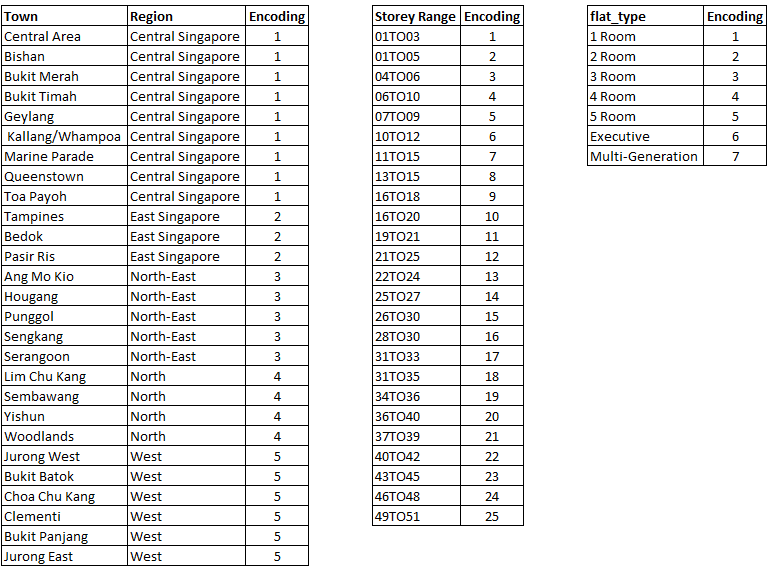

In [163]:
hdb

month  flat_type block        street_name  storey_range  \
0       1/1/2015     3 Room   174   ANG MO KIO AVE 4             5   
1       1/1/2015     3 Room   541  ANG MO KIO AVE 10             1   
2       1/1/2015     3 Room   163   ANG MO KIO AVE 4             1   
3       1/1/2015     3 Room   446  ANG MO KIO AVE 10             1   
4       1/1/2015     3 Room   557  ANG MO KIO AVE 10             5   
...          ...        ...   ...                ...           ...   
110468  1/6/2020  Executive   326     YISHUN RING RD             5   
110469  1/6/2020  Executive   281       YISHUN ST 22             1   
110470  1/6/2020  Executive   611       YISHUN ST 61             1   
110471  1/6/2020  Executive   611       YISHUN ST 61             5   
110472  1/6/2020  Executive   828       YISHUN ST 81             3   

        floor_area_sqm      flat_model  lease_commence_date  resale_price  \
0                 60.0        Improved                 1986      255000.0   
1                 68.0  New Generation                 1981      275000.0   
2                 69.0  New Generation                 1980      285000.0   
3                 68.0  New Generation                 1979      290000.0   
4                 68.0  New Generation                 1980      290000.0   
...                ...             ...                  ...           ...   
110468           146.0      Maisonette                 1988      590000.0   
110469           152.0      Maisonette                 1985      583000.0   
110470           142.0       Apartment                 1987      550000.0   
110471           146.0      Maisonette                 1987      595000.0   
110472           142.0       Apartment                 1988      618000.0   

        price_per_sqm  ...  town_Pasir Ris  town_Punggol  town_Queenstown  \
0         4250.000000  ...               0             0                0   
1         4044.117647  ...               0             0                0   
2         4130.434783  ...               0             0                0   
3         4264.705882  ...               0             0                0   
4         4264.705882  ...               0             0                0   
...               ...  ...             ...           ...              ...   
110468    4041.095890  ...               0             0                0   
110469    3835.526316  ...               0             0                0   
110470    3873.239437  ...               0             0                0   
110471    4075.342466  ...               0             0                0   
110472    4352.112676  ...               0             0                0   

        town_Sembawang  town_Sengkang town_Serangoon  town_Tampines  \
0                    0              0              0              0   
1                    0              0              0              0   
2                    0              0              0              0   
3                    0              0              0              0   
4                    0              0              0              0   
...                ...            ...            ...            ...   
110468               0              0              0              0   
110469               0              0              0              0   
110470               0              0              0              0   
110471               0              0              0              0   
110472               0              0              0              0   

        town_Toa Payoh town_Woodlands  town_Yishun  
0                    0              0            0  
1                    0              0            0  
2                    0              0            0  
3                    0              0            0  
4                    0              0            0  
...                ...            ...          ...  
110468               0              0            1  
110469               0              0      

In [8]:
hdb.T

0       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     174   
street_name                                  ANG MO KIO AVE 4   
storey_range                                                5   
floor_area_sqm                                             60   
flat_model                                           Improved   
lease_commence_date                                      1986   
resale_price                                           255000   
price_per_sqm                                            4250   
region                                                      3   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            65   
trx_year                                                 2015   
full address                 174 ANG MO KIO AVE 4 , Singapore   
lat                                                   1.37524   
long                                                  103.837   
coords                               (1.3752431, 103.8374311)   
PSch Dist                                            0.438992   
PSch Name                            Mayflower Primary School   
SSch Dist                                            0.606734   
SSch Name                       Yio Chu Kang Secondary School   
JC Dist                                              0.982626   
JC Name                     Anderson Serangoon Junior College   
Poly Dist                                             1.38317   
Poly Name                                 Nanyang Polytechnic   
ITE Dist                                              2.09069   
ITE Name                                  ITE College Central   
Uni Dist                                              5.26624   
Uni Name             East Asia Institute of Management (EASB)   

                                                       1       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     541   
street_name                                 ANG MO KIO AVE 10   
storey_range                                                1   
floor_area_sqm                                             68   
flat_model                                     New Generation   
lease_commence_date                                      1981   
resale_price                                           275000   
price_per_sqm                                         4044.12   
region                                                      3   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            60   
trx_year                                                 2015   
full address                541 ANG MO KIO AVE 10 , Singapore   
lat                                                   1.37329   
long                                                  103.856   
coords                                (1.373289, 103.8560821)   
PSch Dist                                             0.32098   
PSch Name                              Da Qiao Primary School   
SSch Dist                                            0.799051   
SSch Name                           Anderson Secondary School   
JC Dist                                               1.32757   
JC Name                     Anderson Serangoon Junior College   
Poly Dist                                             1.08508   
Poly Name                                 Nanyang Polytechnic   
ITE Dist                

In [166]:
#use one-hot encoding for the individual towns in singapore
hdb = pd.get_dummies(hdb, columns=["region"])
hdb.T

0       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     174   
street_name                                  ANG MO KIO AVE 4   
storey_range                                                5   
floor_area_sqm                                             60   
flat_model                                           Improved   
lease_commence_date                                      1986   
resale_price                                           255000   
price_per_sqm                                            4250   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            65   
trx_year                                                 2015   
full address                 174 ANG MO KIO AVE 4 , Singapore   
lat                                                   1.37524   
long                                                  103.837   
coords                               (1.3752431, 103.8374311)   
PSch Dist                                            0.438992   
PSch Name                            Mayflower Primary School   
SSch Dist                                            0.606734   
SSch Name                       Yio Chu Kang Secondary School   
JC Dist                                              0.982626   
JC Name                     Anderson Serangoon Junior College   
Poly Dist                                             1.38317   
Poly Name                                 Nanyang Polytechnic   
ITE Dist                                              2.09069   
ITE Name                                  ITE College Central   
Uni Dist                                              5.26624   
Uni Name             East Asia Institute of Management (EASB)   
region_1                                                    0   
region_2                                                    0   
region_3                                                    1   
region_4                                                    0   
region_5                                                    0   

                                                       1       \
month                                                1/1/2015   
town                                               Ang Mo Kio   
flat_type                                              3 Room   
block                                                     541   
street_name                                 ANG MO KIO AVE 10   
storey_range                                                1   
floor_area_sqm                                             68   
flat_model                                     New Generation   
lease_commence_date                                      1981   
resale_price                                           275000   
price_per_sqm                                         4044.12   
type_index                                                  3   
type_region                                               3.3   
remaining_lease                                            60   
trx_year                                                 2015   
full address                541 ANG MO KIO AVE 10 , Singapore   
lat                                                   1.37329   
long                                                  103.856   
coords                                (1.373289, 103.8560821)   
PSch Dist                                             0.32098   
PSch Name                              Da Qiao Primary School   
SSch Dist                                            0.799051   
SSch Name                           Anderson Secondary School   
JC Dist                                               1.32757   
JC Name                 

In [167]:
hdb.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'price_per_sqm', 'type_index', 'type_region', 'remaining_lease',
       'trx_year', 'full address', 'lat', 'long', 'coords', 'PSch Dist',
       'PSch Name', 'SSch Dist', 'SSch Name', 'JC Dist', 'JC Name',
       'Poly Dist', 'Poly Name', 'ITE Dist', 'ITE Name', 'Uni Dist',
       'Uni Name', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5'],
      dtype='object')

In [168]:
#make a copy of the original dataframe which only includes the numerical data
hdb_data = hdb.copy()
hdb_data = hdb_data[['storey_range',  'resale_price',  'price_per_sqm', 'floor_area_sqm',
                     'type_index', 'remaining_lease', 'PSch Dist', 'SSch Dist', 'JC Dist', 'Poly Dist', 'ITE Dist', 'Uni Dist',
                     'lat', 'long', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5'
                    ]]

In [170]:
hdb_data.T

0              1              2              3       \
storey_range          5.000000       1.000000       1.000000       1.000000   
resale_price     255000.000000  275000.000000  285000.000000  290000.000000   
price_per_sqm      4250.000000    4044.117647    4130.434783    4264.705882   
floor_area_sqm       60.000000      68.000000      69.000000      68.000000   
type_index            3.000000       3.000000       3.000000       3.000000   
remaining_lease      65.000000      60.000000      59.000000      58.000000   
PSch Dist             0.438992       0.320980       0.530940       0.575910   
SSch Dist             0.606734       0.799051       0.611093       0.325005   
JC Dist               0.982626       1.327571       1.055961       1.631064   
Poly Dist             1.383174       1.085076       1.447198       1.517372   
ITE Dist              2.090693       0.495597       2.105228       1.109022   
Uni Dist              5.266236       5.096500       5.080539       4.480802   
lat                   1.375243       1.373289       1.373576       1.367812   
long                103.837431     103.856082     103.837598     103.855186   
region_1              0.000000       0.000000       0.000000       0.000000   
region_2              0.000000       0.000000       0.000000       0.000000   
region_3              1.000000       1.000000       1.000000       1.000000   
region_4              0.000000       0.000000       0.000000       0.000000   
region_5              0.000000       0.000000       0.000000       0.000000   

                        4              5              6              7       \
storey_range          5.000000       5.000000       1.000000       1.000000   
resale_price     290000.000000  290000.000000  290000.000000  293000.000000   
price_per_sqm      4264.705882    4328.358209    4264.705882    4308.823529   
floor_area_sqm       68.000000      67.000000      68.000000      68.000000   
type_index            3.000000       3.000000       3.000000       3.000000   
remaining_lease      59.000000      59.000000      59.000000      60.000000   
PSch Dist             0.110752       0.494838       0.468309       0.275136   
SSch Dist             0.813868       0.609262       0.479044       0.565376   
JC Dist               1.578020       1.098985       0.887463       1.363906   
Poly Dist             1.346081       1.471829       0.988529       2.094013   
ITE Dist              0.706939       2.279296       1.187568       1.892122   
Uni Dist              4.959972       5.839194       4.733442       3.692712   
lat                   1.371606       1.380163       1.371153       1.361313   
long                103.857722     103.835710     103.847667     103.851653   
region_1              0.000000       0.000000       0.000000       0.000000   
region_2              0.000000       0.000000       0.000000       0.000000   
region_3              1.000000       1.000000       1.000000       1.000000   
region_4              0.000000       0.000000       0.000000       0.000000   
region_5              0.000000       0.000000       0.000000       0.000000   

                        8              9       ...         110463  \
storey_range          1.000000       8.000000  ...       3.000000   
resale_price     300000.000000  307500.000000  ...  775000.000000   
price_per_sqm      4477.611940    4522.058824  ...    4281.767956   
floor_area_sqm       67.000000      68.000000  ...     181.000000   
type_index            3.000000       3.000000  ...       6.000000   
remaining_lease      57.000000      64.000000  ...      71.000000   
PSch Dist             0.255897       0.257214  ...       0.313757   
SSch Dist             0.320364       0.835465  ...       0.448276   
JC Dist               0.861064       1.840218  ...       1.237020   
Poly Dist             1.662242       1.618699  ...       4.564812   
ITE Dist              2.214365       0.959487  ...       5.010962   
Uni Dist              4.704885    

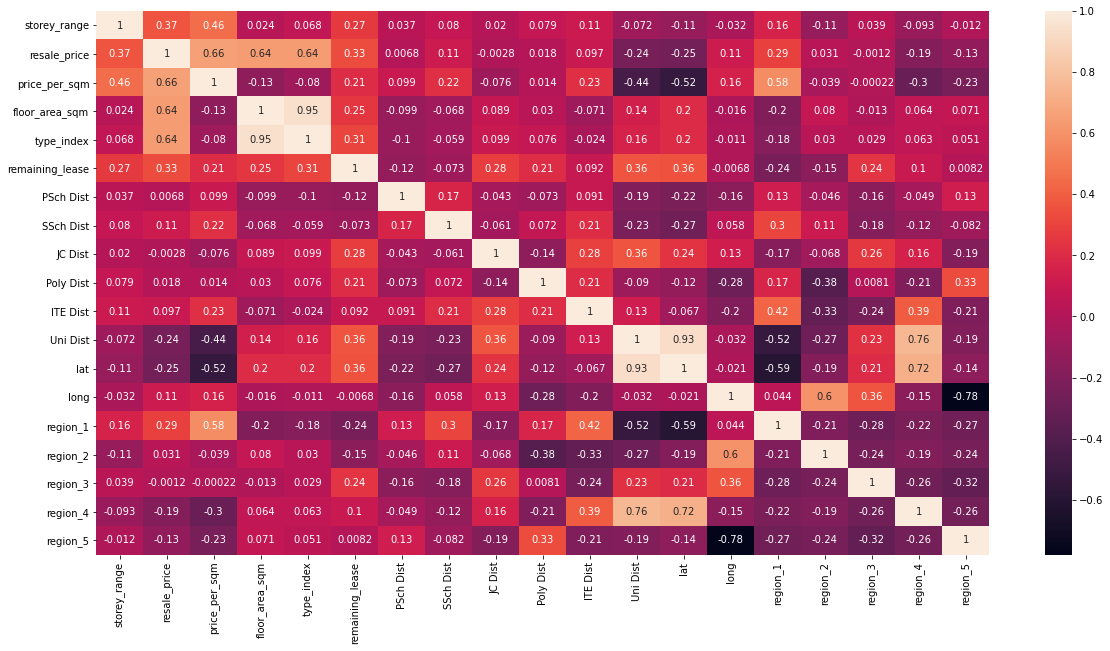

In [171]:
plt.figure(figsize = (20,10))
sns.heatmap(hdb_data.corr(), annot=True)

Floor area sqm has a high correlation to type_index (type of house)

<Figure size 720x1440 with 0 Axes>

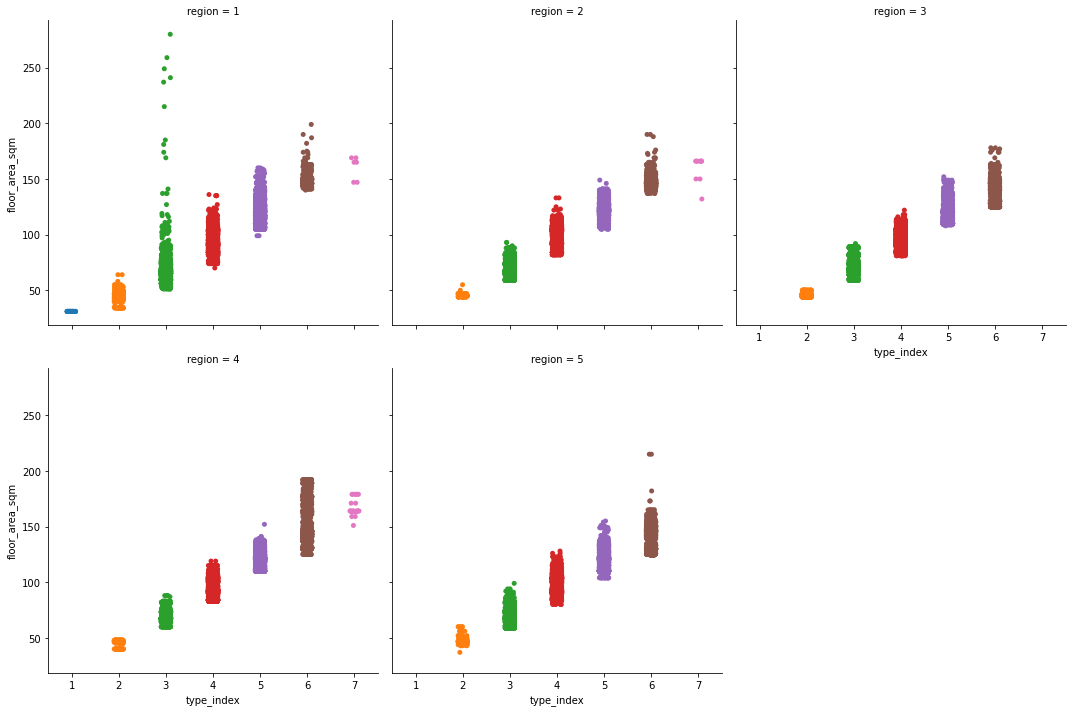

In [182]:
plt.figure(figsize = (10,20))
sns.catplot(x="type_index", y="floor_area_sqm", col="region", col_wrap = 3, data=hdb)

There is no consistent trend for housing sizes by sqm across all regions in singapore. As such, we will be dropping floor_area_sqm for the rest of this analysis

In [183]:
hdb_data = hdb_data[['storey_range',  'resale_price',  'price_per_sqm', 
                     'type_index', 'remaining_lease', 'PSch Dist', 'SSch Dist', 'JC Dist', 'Poly Dist', 'ITE Dist', 'Uni Dist',
                     'lat', 'long', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5'
                    ]]

- PCA for feature importance
- Corr before PCA
- Use PCA to fit into any model
- Customizing result per house type

### Perform PCA

We are trying to determine feature importance for this dataset, as such we will utilize PCA

In [255]:
#dump PCA results to dataframe in order to 
#detemine the appropriate number of PCs to achieve and acceptable explained variance rate
features = ['storey_range',    'price_per_sqm', 'type_index', 'remaining_lease', 'PSch Dist', 
            'SSch Dist', 'JC Dist', 'Poly Dist', 'ITE Dist', 'Uni Dist',
            'lat', 'long', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5']
target = ['resale_price']


X = hdb_data[features]
y= hdb_data[target]
X = StandardScaler().fit_transform(X)

z=0
comp_var = pd.DataFrame(columns=['no. of components', 'explained variance'])

for i in range(len(features)) : 
    pca = PCA(n_components=z+1)
    principalComponents = pca.fit_transform(X)
    res = pd.DataFrame({'no. of components': [z+1],
                        'explained variance' : [pca.explained_variance_ratio_.sum()*100]})
    comp_var = comp_var.append(res)
    z += 1




In [258]:
comp_var

no. of components  explained variance
0                 1           22.514348
0                 2           37.445871
0                 3           50.732061
0                 4           61.446037
0                 5           68.635875
0                 6           74.817196
0                 7           80.527039
0                 8           85.354178
0                 9           89.718075
0                10           93.276537
0                11           96.334409
0                12           98.032619
0                13           99.113481
0                14           99.543215
0                15           99.797136
0                16          100.000000
0                17          100.000000

We'll be targetting 7 PCs here as it provides a relatively high explained variance ratio, whilst still being less than half of the 17 features available

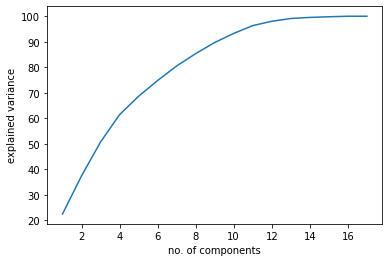

In [257]:
sns.lineplot(data=comp_var, x='no. of components', y='explained variance')

In [282]:
#Run PCA for the dataset
features = ['storey_range',    'price_per_sqm', 'type_index', 'remaining_lease', 'PSch Dist', 
            'SSch Dist', 'JC Dist', 'Poly Dist', 'ITE Dist', 'Uni Dist',
            'lat', 'long', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5']
target = ['resale_price']


X = hdb_data[features]
y= hdb_data[target]
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.22514348, 0.14931523, 0.1328619 , 0.10713977, 0.07189838,
       0.06181321, 0.05709843])

In [283]:
featimpt = pd.DataFrame(data = abs(pca.components_)
             , columns = ['storey_range',    'price_per_sqm', 'type_index', 'remaining_lease', 'PSch Dist', 
            'SSch Dist', 'JC Dist', 'Poly Dist', 'ITE Dist', 'Uni Dist',
            'lat', 'long', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5'])
featimpt

storey_range  price_per_sqm  type_index  remaining_lease  PSch Dist  \
0      0.093774       0.302468    0.133121         0.189445   0.138845   
1      0.062287       0.058207    0.030941         0.070013   0.114834   
2      0.298998       0.383139    0.037569         0.278211   0.006557   
3      0.266524       0.157170    0.228405         0.401989   0.172724   
4      0.300203       0.109718    0.509713         0.304530   0.122286   
5      0.219705       0.094699    0.273319         0.024624   0.687086   
6      0.456227       0.263574    0.226277         0.032473   0.201560   

   SSch Dist   JC Dist  Poly Dist  ITE Dist  Uni Dist       lat      long  \
0   0.199001  0.200496   0.074631  0.020401  0.476629  0.484102  0.013355   
1   0.001520  0.078751   0.344849  0.229035  0.042336  0.014386  0.580344   
2   0.163215  0.263404   0.072074  0.464746  0.140312  0.029252  0.127268   
3   0.162918  0.047813   0.279504  0.289909  0.079263  0.047525  0.033359   
4   0.216284  0.025684   0.153072  0.030020  0.024871  0.029796  0.020564   
5   0.058856  0.309147   0.419863  0.095243  0.015577  0.033692  0.127548   
6   0.420430  0.503981   0.243473  0.203445  0.047871  0.118936  0.075714   

   region_1  region_2  region_3  region_4  region_5  
0  0.357508  0.085212  0.145542  0.346885  0.052464  
1  0.057828  0.435597  0.227426  0.109399  0.447802  
2  0.320475  0.215277  0.104743  0.178485  0.372999  
3  0.166565  0.119660  0.447637  0.430413  0.179766  
4  0.169449  0.434732  0.452663  0.104901  0.151751  
5  0.189582  0.092488  0.178030  0.054021  0.119242  
6  0.069090  0.086569  0.113313  0.215762  0.065168

The implied feature importance based on the above results is as follows : 

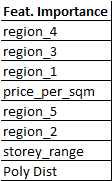

In [263]:
pca.explained_variance_ratio_

array([0.22514348, 0.14931523, 0.1328619 , 0.10713977, 0.07189838,
       0.06181321, 0.05709843])

We need to relook the PCA process as the explained variance ratio is low relative to number of PCs. One of the possible reasons could be the combining of multiple house types into one resale price dataframe. Let's see what happens when we split the dataframe by house type. As a quick refresher this is what the housing encoding looks like again : 

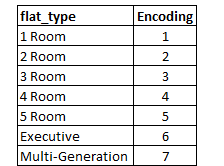

In [229]:
#split hdb_data into separate dataframes based on room type
room_1 = hdb_data[hdb_data['type_index'] == 1]
room_2 = hdb_data[hdb_data['type_index'] == 2]
room_3 = hdb_data[hdb_data['type_index'] == 3]
room_4 = hdb_data[hdb_data['type_index'] == 4]
room_5 = hdb_data[hdb_data['type_index'] == 5]
room_exec = hdb_data[hdb_data['type_index'] == 6]

room_mg = hdb_data[hdb_data['type_index'] == 7]

In [279]:
#run PCA in a for loop, and store results in a dataframe

features = ['storey_range',   'price_per_sqm', 
                     'type_index', 'remaining_lease', 'PSch Dist', 'SSch Dist', 'JC Dist', 'Poly Dist', 'ITE Dist', 'Uni Dist',
                     'lat', 'long', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5']
target = ['resale_price']

datasets = [room_1, room_2, room_3, room_4, room_5, room_exec, room_mg]
titles = ['room_1', 'room_2', 'room_3', 'room_4', 'room_5', 'room_exec', 'room_mg']
pca_results = pd.DataFrame(columns=['dataset','PC1','PC2','PC3','PC4','PC5', 'PC6', 'PC7',  'Exp_Var_Ttl'])
featimpt = pd.DataFrame(columns = ['storey_range',   'price_per_sqm', 
                     'type_index', 'remaining_lease', 'PSch Dist', 'SSch Dist', 'JC Dist', 'Poly Dist', 'ITE Dist', 'Uni Dist',
                     'lat', 'long', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'data source'] )


z=0

for i in datasets : 
    X = i[features]
    y= i[target]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=7)
    principalComponents = pca.fit_transform(X)
    res = pd.DataFrame({'dataset' : [titles[z]],
                    'PC1' : [pca.explained_variance_ratio_[0]],
                    'PC2' : [pca.explained_variance_ratio_[1]],
                    'PC3' : [pca.explained_variance_ratio_[2]],
                    'PC4' : [pca.explained_variance_ratio_[3]],
                    'PC5' : [pca.explained_variance_ratio_[4]],   
                    'PC6' : [pca.explained_variance_ratio_[5]],
                    'PC7' : [pca.explained_variance_ratio_[6]],    
                    'Exp_Var_Ttl' : [pca.explained_variance_ratio_.sum()]   })
    feat = pd.DataFrame(data =abs(pca.components_), columns = features )
    feat['data source'] = titles[z]
    pca_results = pca_results.append(res)
    featimpt = featimpt.append(feat)
    z += 1

    
pca_results

dataset       PC1       PC2       PC3       PC4       PC5       PC6  \
0     room_1  0.557929  0.442071  0.000000  0.000000  0.000000  0.000000   
0     room_2  0.276790  0.150915  0.126660  0.104073  0.078864  0.061867   
0     room_3  0.242762  0.163244  0.126150  0.097290  0.085766  0.069791   
0     room_4  0.234823  0.160507  0.152361  0.114519  0.066456  0.058577   
0     room_5  0.246636  0.167888  0.137005  0.115026  0.065351  0.060997   
0  room_exec  0.262521  0.184354  0.107057  0.095305  0.074626  0.062822   
0    room_mg  0.619339  0.224940  0.084909  0.053100  0.010236  0.007143   

        PC7  Exp_Var_Ttl  
0  0.000000     1.000000  
0  0.051548     0.850717  
0  0.056416     0.841419  
0  0.057689     0.844933  
0  0.058332     0.851235  
0  0.059042     0.845726  
0  0.000332     1.000000

- The explained variance here has improved vs performing PCA on the entire dataframe
- Next we need to identify the most important features to utilize across all of the different datasets

In [274]:
featimpt

storey_range  price_per_sqm    type_index  remaining_lease  PSch Dist  \
0      0.707107       0.707107  0.000000e+00         0.000000   0.000000   
1      0.707107       0.707107  0.000000e+00         0.000000   0.000000   
2      0.000000       0.000000  0.000000e+00         0.000000   1.000000   
3      0.000000       0.000000  0.000000e+00         0.000000   0.000000   
4      0.000000       0.000000  0.000000e+00         0.000000   0.000000   
5      0.000000       0.000000  0.000000e+00         0.000000   0.000000   
6      0.000000       0.000000  0.000000e+00         0.000000   0.000000   
0      0.141755       0.008464  0.000000e+00         0.388612   0.154905   
1      0.113212       0.077826  2.775558e-16         0.174385   0.088352   
2      0.032312       0.068959  9.714451e-17         0.023816   0.184446   
3      0.407612       0.468839  3.330669e-16         0.153203   0.158760   
4      0.356998       0.457696  2.220446e-16         0.198580   0.335185   
5      0.266305       0.278248  1.804112e-16         0.207904   0.331070   
6      0.298054       0.233225  8.326673e-17         0.130030   0.252540   
0      0.094048       0.271861  2.220446e-16         0.180151   0.106430   
1      0.084428       0.005732  8.326673e-17         0.122767   0.109345   
2      0.207350       0.320941  1.387779e-16         0.226338   0.025650   
3      0.456003       0.407514  2.775558e-16         0.525034   0.055219   
4      0.043581       0.008720  3.469447e-17         0.135450   0.394410   
5      0.035114       0.079695  1.734723e-17         0.195997   0.645995   
6      0.491426       0.061476  5.551115e-17         0.057707   0.269362   
0      0.142278       0.336821  0.000000e+00         0.086015   0.134123   
1      0.197115       0.322585  5.551115e-17         0.242443   0.111138   
2      0.249792       0.212748  2.220446e-16         0.306536   0.063141   
3      0.108845       0.007653  8.326673e-17         0.290505   0.166774   
4      0.453037       0.125362  5.551115e-17         0.278911   0.573009   
5      0.329819       0.038184  8.326673e-17         0.301038   0.491724   
6      0.345180       0.207938  2.775558e-16         0.105601   0.219145   
0      0.163182       0.325251  0.000000e+00         0.113353   0.138057   
1      0.014229       0.173769  3.989864e-17         0.080870   0.084241   
2      0.282786       0.354594  5.551115e-17         0.233155   0.044023   
3      0.166166       0.091720  5.551115e-17         0.371615   0.173137   
4      0.539968       0.223855  1.665335e-16         0.230290   0.463010   
5      0.116489       0.010780  2.428613e-16         0.482525   0.222784   
6      0.304478       0.141482  2.775558e-17         0.114688   0.722656   
0      0.001248       0.255688  6.938894e-18         0.222710   0.126145   
1      0.067000       0.198531  3.330669e-16         0.129682   0.159102   
2      0.178377       0.008327  5.551115e-17         0.298682   0.192476   
3      0.272040       0.504905  2.081668e-16         0.058527   0.169578   
4      0.495318       0.029856  1.387779e-16         0.422328   0.139083   
5      0.434638       0.078803  8.326673e-17         0.123276   0.558232   
6      0.487920       0.156110  2.220446e-16         0.132262   0.519865   
0      0.092773       0.270209  5.551115e-17         0.124300   0.308033   
1      0.035123       0.249904  2.775558e-17         0.056280   0.232001   
2      0.728725       0.142698  0.000000e+00         0.621666   0.001766   
3      0.611591       0.210776  5.551115e-17         0.728739   0.050637   
4      0.290557       0.873579  3.330669e-16         0.046445   0.024080   
5      0.024555       0.191152  1.387779e-16         0.124181   0.147434   
6      0.006974       0.008151  1.110223e-16         0.049392   0.881353   

   SSch Dist   JC Dist  Poly Dist  ITE Dist  Uni Dist       lat      long  \
0   0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.000000   0.000000  0.000000  0.0

In [281]:
pca_results.to_csv('pca.csv')

After running some additional analysis in excel, we have the following details for feature importance :

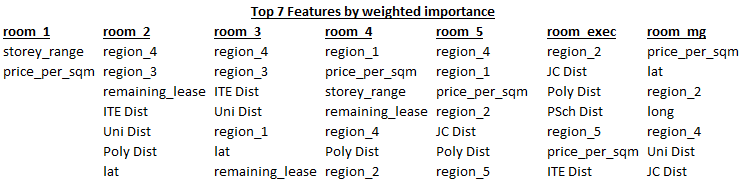


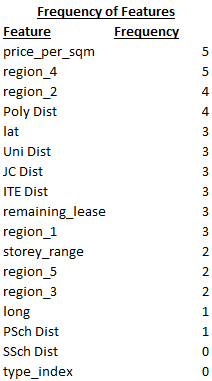

Aside from price_per_sqm, the results here show that geographic factors and proximity to education institutions do have some importance on the overall price of a resale flat.

- region_4 (North Singapore), region_2(east singapore) have some bearing on the overall price of a house in singapore
- type_index is effectively excluded from this PCA result as we have already split out the dataframes based on the type of house involved
- PSch Dist and SSch Dist surprisingly do not have a strong influence on resale prices, could this be due to the fact that these type of schools are evenly distributed throughout singapore ? Making them harder to use as a determinant of house pricing

## Modelling and Prediction

### Linear Regression on combined dataframe
We will first perform linear regression on the combined dataframe, using the features we have found previously

In [286]:
hdb_data.head()

storey_range  resale_price  price_per_sqm  type_index  remaining_lease  \
0             5      255000.0    4250.000000           3               65   
1             1      275000.0    4044.117647           3               60   
2             1      285000.0    4130.434783           3               59   
3             1      290000.0    4264.705882           3               58   
4             5      290000.0    4264.705882           3               59   

   PSch Dist  SSch Dist   JC Dist  Poly Dist  ITE Dist  Uni Dist       lat  \
0   0.438992   0.606734  0.982626   1.383174  2.090693  5.266236  1.375243   
1   0.320980   0.799051  1.327571   1.085076  0.495597  5.096500  1.373289   
2   0.530940   0.611093  1.055961   1.447198  2.105228  5.080539  1.373576   
3   0.575910   0.325005  1.631064   1.517372  1.109022  4.480802  1.367812   
4   0.110752   0.813868  1.578020   1.346081  0.706939  4.959972  1.371606   

         long  region_1  region_2  region_3  region_4  region_5  
0  103.837431         0         0         1         0         0  
1  103.856082         0         0         1         0         0  
2  103.837598         0         0         1         0         0  
3  103.855186         0         0         1         0         0  
4  103.857722         0         0         1         0         0

In [311]:
room_1.head()

storey_range  resale_price  price_per_sqm  type_index  remaining_lease  \
1458              1      220000.0    7096.774194           1               54   
2667              5      210000.0    6774.193548           1               54   
4026              1      208000.0    6709.677419           1               54   
5642              1      200000.0    6451.612903           1               54   
11883             1      200000.0    6451.612903           1               54   

       PSch Dist  SSch Dist   JC Dist  Poly Dist   ITE Dist  Uni Dist  \
1458    0.622646   0.433494  4.241488   5.813179  11.770522  2.034878   
2667    0.622646   0.433494  4.241488   5.813179  11.770522  2.034878   
4026    0.622646   0.433494  4.241488   5.813179  11.770522  2.034878   
5642    0.622646   0.433494  4.241488   5.813179  11.770522  2.034878   
11883   0.622646   0.433494  4.241488   5.813179  11.770522  2.034878   

           lat        long  region_1  region_2  region_3  region_4  region_5  
1458   1.27844  103.819407         1         0         0         0         0  
2667   1.27844  103.819407         1         0         0         0         0  
4026   1.27844  103.819407         1         0         0         0         0  
5642   1.27844  103.819407         1         0         0         0         0  
11883  1.27844  103.819407         1         0         0         0         0

Refresh of most important features for dataset split by house type

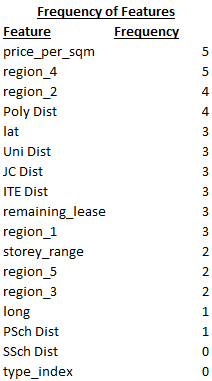

In [344]:


from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

features = ['price_per_sqm', 'region_4', 'region_2', 'Poly Dist', 'lat', 'Uni Dist', 'JC Dist' ]
target = ['resale_price']
datasets = [hdb_data, room_1, room_2, room_3, room_4, room_5, room_exec, room_mg]
titles = ['hdb_data','room_1', 'room_2', 'room_3', 'room_4', 'room_5', 'room_exec', 'room_mg']
model_scores = pd.DataFrame(columns=['Dataset', 'Accuracy Score'])
model_view = pd.DataFrame(columns=['price_per_sqm', 'region_4', 'region_2', 'Poly Dist', 'lat', 
                                   'Uni Dist', 'JC Dist', 'intercept', 'Dataset'])
z=0

for i in datasets :
    
    #scaling and fitting model based on various dataframes
    X = i[features]
    y = i[target]
    X = StandardScaler().fit_transform(X)
    y = StandardScaler().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    
    #store results in model_score dataframe
    temp = pd.DataFrame({'Dataset' : [titles[z]],
                         'Accuracy Score' : model.score(X_test, y_test)})
    model_scores = model_scores.append(temp)
    
    
    #store coefficients and intercept in model_view dataframe
    temp2 = pd.DataFrame(columns = features, data = model.coef_)
    temp2['intercept'] = model.intercept_
    temp2['Dataset'] = titles[z]
    model_view = model_view.append(temp2)
    
    #iterate loop, and zero out temp variables
    z += 1
    temp2 = 0
    temp = 0
    
model_scores

Dataset  Accuracy Score
0   hdb_data        0.476961
0     room_1        1.000000
0     room_2        0.686334
0     room_3        0.786718
0     room_4        0.926206
0     room_5        0.958925
0  room_exec        0.887339
0    room_mg        0.727823

In [345]:
model_view

price_per_sqm  region_4  region_2  Poly Dist       lat  Uni Dist   JC Dist  \
0       0.765843 -0.058582  0.089410   0.069149  0.468640 -0.289087  0.071467   
0       1.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
0       0.841523 -0.112205  0.010394   0.041982 -0.163312  0.299524 -0.020045   
0       0.912872 -0.038061  0.022429  -0.035822  0.097478 -0.030113  0.013172   
0       0.944508  0.003182  0.018554  -0.004238  0.095237 -0.154472  0.022677   
0       0.898591  0.031809 -0.010143  -0.089240 -0.078422 -0.054488 -0.032285   
0       0.815727  0.131231 -0.069279  -0.207710 -0.017707 -0.204982 -0.030842   
0       0.486916 -1.568162 -2.566066   5.848734 -0.502449 -0.305281  6.712226   

      intercept    Dataset  
0 -2.017759e-03   hdb_data  
0  3.741120e-11     room_1  
0  1.261740e-03     room_2  
0  1.449097e-04     room_3  
0  1.592010e-04     room_4  
0  5.400633e-04     room_5  
0 -2.133552e-03  room_exec  
0  3.670797e-02    room_mg

In [ ]:
hdb_data[hdb]

- We can confirm that the splitting of the dataset, coupled with the use of the principal components obtained in the separate approach leads to a greater quality of results
- The accuracy scores for room_1 and room_mg need to be explored in further detail as there are not enough observations relative to all other room types
- There doesn't seem to a be a universal trend across house types, aside from the price_per_sqm. Coefficient signs tend to change based on the type of house
- 

- splitting data by region instead ?
- clustering


- zoning
- classification
- high/low density areas
-  transportation
- demographics